## Version & History

This worksheet was created by Lauren C Kennedy for Effect of disinfectant residual, pH, and temperature on microbial abundance in piped drinking water distribution systems

## 1. Import libraries and data

In [1]:
#load stuff
library(ggplot2)
library(reshape2)
library(scales)
library(tidyr)
library(extrafont)
library(ggpubr)
library(Hmisc)
library(stargazer)#output tables
library(DescTools) #gmean and gstd
library(dplyr)
library(lme4)
library(effects) #plot predicted values for models
library(broom.mixed)#to extract info from models
library(MuMIn) #model selection for glmms
library(goft)#goodness of fit test for gamma distribution
library(GGally) #check for multicolinearity
library(merTools)#glmms plot variation in fixed and random effects


options(jupyter.plot_mimetypes = c("text/plain", "image/png" )) #to make conversion to pdf work properly

library(viridis)#great color options designed to be visible to people with colorblindness

colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861")

blue_s<- c("#29453E","#7DD1BC","#508577","#579183", "#406B60")
pink_s<- c("#E97CFC","#AE5CBD","#683770","#733D7D","#502A57")
green_s<- c("#35593A", "#87E694","#5A9963","#62A66B","#4B8052")
brown_s<- c("#F2645C", "#B34944","#662A27","#732F2C","#4D1F1D")
grey_s<- c("#4A4235", "#D6C09A","#8A7C63","#96876C","#706551")

#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Registering fonts with R

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘DescTools’


The following objects are masked from ‘package:Hmisc’:

    %nin%, Label, Mean, Quantile



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The 

In [2]:
set.seed(30)
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.5.1       viridisLite_0.3.0   merTools_0.5.0     
 [4] arm_1.11-1          GGally_2.0.0        goft_1.3.4         
 [7] fitdistrplus_1.0-14 npsurv_0.4-0        lsei_1.2-0         
[10] MASS_7.3-51.5       MuMIn_1.43.15       broom.mixed_0.2.4  
[13] effects_4.1-4       carData_3.0-3       lme4_1.1-23        
[16] Matrix_1.2-18       dplyr_1.0.2         DescTools_0.99.32  
[19] stargazer_5.2.2     Hmisc_4.3-1         Formula_1.2-3      
[22] survival_3.1-8      lattice_0.20-4

In [3]:
#following the recommendation from this article https://www.r-bloggers.com/how-to-cite-packages/
#here are all the packages used
library(knitr)
write_bib(x = .packages(), file="/Users/owner/Desktop/R_packages.bib", tweak = TRUE, width = NULL, 
    prefix = getOption("knitr.bib.prefix", "R-"))



tweaking Hmisc



In [4]:
give.n <- function(x){
  return(c(y = -.2, label = length(x))) 
  # experiment with the multiplier to find the perfect position
}

### import csv files

In [5]:
#import worksheet
#where is the data?
path="/your/path/to/data/"

#where should figures and tables go?
path_fig="/your/output/path/for/figures"
path_tab="/your/output/path/for/tables"

SGPI_all<-read.csv(file=paste(path,"SGPI_all.csv",sep=""))
SG_all<-read.csv(file=paste(path,"SG_all.csv",sep=""))
SG_all$stain<-"SG"
SGPI_all$stain<-"SGPI"
DWDS_F_dat<-read.csv(file=paste(path,"DWDS_F.csv",sep=""))

SG_all<- dplyr::select(SG_all,-"X")
SGPI_all<- dplyr::select(SGPI_all,-"X")


### convert date columns

In [6]:
#set date columns
SG_all$sample_date <- as.Date(SG_all$sample_date, "%m/%d/%y") 
SGPI_all$sample_date <- as.Date(SGPI_all$sample_date, "%m/%d/%y") 


### set quantification limits

In [7]:
#quantification Limits 
HPC_lim<-0.9999
TCC_lim<-12
ICC_lim<-22
ATPt_lim<-0.0001
ATPi_lim<- 0.0000183
cl2_lim<-0.02

### set types of data

In [8]:
SG_all$intra_ATP_gmean_nM <- as.numeric(SG_all$intra_ATP_gmean_nM)
SG_all$extra_ATP_gmean_nM <- as.numeric(SG_all$extra_ATP_gmean_nM)
SG_all$total_ATP_gmean_nM <- as.numeric(SG_all$total_ATP_gmean_nM)
SG_all$intra_ATP_gmean_nM <- SG_all$intra_ATP_gmean_nM
SG_all$extra_ATP_gmean_nM <- SG_all$extra_ATP_gmean_nM
SG_all$total_ATP_gmean_nM <- SG_all$total_ATP_gmean_nM 
SG_all$sampling_year <- as.factor(SG_all$sampling_year)


SGPI_all$intra_ATP_gmean_nM <- as.numeric(SGPI_all$intra_ATP_gmean_nM)
SGPI_all$extra_ATP_gmean_nM <- as.numeric(SGPI_all$extra_ATP_gmean_nM)
SGPI_all$total_ATP_gmean_nM <- as.numeric(SGPI_all$total_ATP_gmean_nM)
SGPI_all$sampling_year <- as.factor(SGPI_all$sampling_year)

unique(SG_all$site)
unique(SG_all$disinfectant)
SG_all$disinfectant<-gsub("chloramine", "Chloramine", SG_all$disinfectant)
SGPI_all$disinfectant<-gsub("chloramine", "Chloramine", SGPI_all$disinfectant)
unique(SG_all$disinfectant)

[1] other_site_in_DWDS_F site_15              site_10             
 [4] site_24              site_ut              other_site_in_DWDS_D
 [7] other_site_in_DWDS_E other_site_in_DWDS_C other_site_in_DWDS_B
[10] other_site_in_DWDS_A
10 Levels: other_site_in_DWDS_A other_site_in_DWDS_B ... site_ut

[1] Chloramine Chlorine   chloramine
Levels: chloramine Chloramine Chlorine

[1] "Chloramine" "Chlorine"

## 2. Prep

### Make long format data frames

In [9]:
#make dfs in long format that need two parameters plotted
# ATP
ATP_long_avg= reshape2::melt(dplyr::select(SG_all,-core_id), id=c("std_note","flow_cytometer", "sample_date", "location_code", "broad_location", "disinfectant", "wtp", "total_Cl2_mg.L","free_Cl2_mg.L","site","sampling_year","water_age_h"), measure=c("intra_ATP_gmean_nM", "total_ATP_gmean_nM","extra_ATP_gmean_nM"))
ATP_long_std= reshape2::melt(dplyr::select(SG_all,-core_id), id=c("std_note","flow_cytometer", "sample_date", "location_code", "broad_location", "disinfectant", "wtp", "total_Cl2_mg.L","free_Cl2_mg.L","site","sampling_year","water_age_h"), measure=c("intra_ATP_gstd_nM", "total_ATP_gstd_nM","extra_ATP_gstd_nM"))
names(ATP_long_std)[names(ATP_long_std)=="value"] <- "ATP_stdev"
names(ATP_long_std)[names(ATP_long_std)=="variable"] <- "ATP_stdev_type"
ATP_long= full_join(ATP_long_avg, ATP_long_std)
ATP_long= subset(ATP_long, substring(ATP_long$variable,1,5)==substring(ATP_long$ATP_stdev_type,1,5))


#SG + SGPI together
fcm_all_long=full_join(dplyr::select(SG_all,-core_id),dplyr::select(SGPI_all,-core_id))


Joining, by = c("std_note", "flow_cytometer", "sample_date", "location_code", "broad_location", "disinfectant", "wtp", "total_Cl2_mg.L", "free_Cl2_mg.L", "site", "sampling_year", "water_age_h")

Joining, by = c("sample_date", "broad_location", "sampling_year", "location_code", "site", "disinfectant", "wtp", "flow_cytometer", "regrowth_key", "std_note", "HPC_label", "avg_cells_per_mL_gmean", "avg_cells_per_mL_gstd", "ICC_to_TCC", "ICC_to_TCC_stdev", "intra_ATP_gmean_nM", "intra_ATP_gstd_nM", "total_ATP_gmean_nM", "total_ATP_gstd_nM", "extra_ATP_gmean_nM", "extra_ATP_gstd_nM", "HPC_gmean_MPN_per_100mL", "HPC_gstd_MPN_per_100mL", "HPC_label.1", "pH", "temp_C", "total_Cl2_mg.L", "free_Cl2_mg.L", "water_age_h", "summer_water_age_h", "stain")



In [10]:
head(ATP_long)
dim(ATP_long)

std_note flow_cytometer sample_date location_code broad_location
1  NA       Canto          2018-02-09  site_9        DWDS_F        
4  NA       Canto          2018-02-09  site_1        DWDS_F        
7  NA       Canto          2018-02-09  site_7        DWDS_F        
10 NA       Canto          2018-02-09  site_15       DWDS_F        
13 NA       Canto          2018-02-09  site_10       DWDS_F        
16 NA       Canto          2018-02-09  site_16       DWDS_F        
   disinfectant wtp total_Cl2_mg.L free_Cl2_mg.L site                
1  Chloramine   No  1.78           0.00          other_site_in_DWDS_F
4  Chloramine   No  2.21           0.00          other_site_in_DWDS_F
7  Chloramine   No  0.31           0.06          other_site_in_DWDS_F
10 Chloramine   No  1.76           0.03          site_15             
13 Chloramine   No  2.16           0.01          site_10             
16 Chloramine   No  1.32           0.02          other_site_in_DWDS_F
   sampling_year water_age_h variable           value       ATP_stdev_type   
1  2018          50.07       intra_ATP_gmean_nM 0.000034100 intra_ATP_gstd_nM
4  2018          19.35       intra_ATP_gmean_nM 0.000010000 intra_ATP_gstd_nM
7  2018          34.69       intra_ATP_gmean_nM 0.001801706 intra_ATP_gstd_nM
10 2018          70.00       intra_ATP_gmean_nM 0.003975449 intra_ATP_gstd_nM
13 2018          50.61       intra_ATP_gmean_nM 0.000010000 intra_ATP_gstd_nM
16 2018          70.00       intra_ATP_gmean_nM 0.010599329 intra_ATP_gstd_nM
   ATP_stdev
1  1.600118 
4  1.000000 
7  1.449861 
10 1.583965 
13 1.000000 
16 4.279336

[1] 504  16

In [11]:
#mwq_all
FCM<-dcast(as.data.frame(fcm_all_long), sampling_year+water_age_h+std_note+HPC_label+ wtp+ pH+ free_Cl2_mg.L+ total_Cl2_mg.L+ temp_C+ disinfectant+ sample_date+  broad_location+ location_code+ HPC_gmean_MPN_per_100mL ~ stain,  value.var= c("avg_cells_per_mL_gmean"))
ATP<-dcast(as.data.frame(ATP_long), std_note+ sample_date+  broad_location+ location_code ~ variable,  value.var= c("value"))
mwq_all<-left_join(FCM,ATP)

FCM_s<-dcast(as.data.frame(fcm_all_long), sampling_year+water_age_h+std_note+HPC_label+ wtp+ pH+ free_Cl2_mg.L+ total_Cl2_mg.L+ temp_C+ disinfectant+ sample_date+  broad_location+ location_code+  HPC_gstd_MPN_per_100mL ~ stain,  value.var= c("avg_cells_per_mL_gstd"))
ATP_s<-dcast(as.data.frame(ATP_long), std_note+ sample_date+  broad_location+ location_code ~ ATP_stdev_type,  value.var= c("ATP_stdev"))
mwq_all_s<-left_join(FCM_s,ATP_s)
colnames(mwq_all_s)[colnames(mwq_all_s)== "SG"] <- "SG_gstd"
colnames(mwq_all_s)[colnames(mwq_all_s)== "SGPI"] <- "SGPI_gstd"

mwq_all<-left_join(mwq_all,mwq_all_s)


#define mwq_quant to be used for modeling purposes -- samples bdl are assigned to be at the detection limit
#this value was chossen because it is a conservative representation of the BDL values 
#ADL values were not included (HPC only 5 samples) because they cannot be conservatively represented

length(mwq_all$pH)#starting size
sum(!is.na(mwq_all$SGPI))#starting size
mwq_quant<-mwq_all
mwq_quant[(!is.na(mwq_quant$intra_ATP_gmean_nM))&(mwq_quant$intra_ATP_gmean_nM <= ATPi_lim),"intra_ATP_gmean_nM"]<- ATPi_lim
mwq_quant[!is.na(mwq_quant$total_ATP_gmean_nM)&(mwq_quant$total_ATP_gmean_nM <= ATPt_lim),"total_ATP_gmean_nM"]<- ATPt_lim
mwq_quant[!is.na(mwq_quant$SGPI)&(mwq_quant$SGPI <= ICC_lim),"SGPI"]<-ICC_lim
mwq_quant[!is.na(mwq_quant$SG)&(mwq_quant$SG <= TCC_lim),"SG"]<-TCC_lim
mwq_quant[!is.na(mwq_quant$free_Cl2_mg.L)&(mwq_quant$free_Cl2_mg.L <= cl2_lim),"free_Cl2_mg.L"]<-cl2_lim
mwq_quant[!is.na(mwq_quant$total_Cl2_mg.L)&(mwq_quant$total_Cl2_mg.L <= cl2_lim),"total_Cl2_mg.L"]<-cl2_lim
mwq_quant[!is.na(mwq_quant$HPC_label)&(mwq_quant$HPC_label == "BDL"),"HPC_gmean_MPN_per_100mL"]<-HPC_lim

length(mwq_quant$pH)#ending size
sum(!is.na(mwq_quant$SGPI))#starting size

#make copies to use if needed
mwq_all_c<- mwq_all
mwq_quant_c<- mwq_quant

## make dataframes from mwq_quant for individual assays to calculate ADL an BDL percentages
mwq_quant_ATPi<-mwq_all[((mwq_all$intra_ATP_gmean_nM > ATPi_lim) | is.na(mwq_all$intra_ATP_gmean_nM)),]
mwq_quant_ATPt<-mwq_all[((mwq_all$total_ATP_gmean_nM > ATPt_lim) | is.na(mwq_all$total_ATP_gmean_nM)),]
mwq_quant_SGPI<-mwq_all[((mwq_all$SGPI > ICC_lim) | is.na(mwq_all$SGPI)),]
mwq_quant_SG<-mwq_all[((mwq_all$SG > TCC_lim) | is.na(mwq_all$SG)),]
mwq_quant_HPC<-mwq_all[((mwq_all$HPC_label != "BDL")| is.na(mwq_all$HPC_label)),]
mwq_quant_HPC<-mwq_quant_HPC[((mwq_quant_HPC$HPC_label != "ADL")| is.na(mwq_quant_HPC$HPC_label)),]

dim(mwq_all)
dim(mwq_quant)

Joining, by = c("std_note", "sample_date", "broad_location", "location_code")

Joining, by = c("std_note", "sample_date", "broad_location", "location_code")

Joining, by = c("sampling_year", "water_age_h", "std_note", "HPC_label", "wtp", "pH", "free_Cl2_mg.L", "total_Cl2_mg.L", "temp_C", "disinfectant", "sample_date", "broad_location", "location_code")



[1] 168

[1] 166

[1] 168

[1] 166

[1] 168  25

[1] 168  25

In [12]:
a<-colnames(fcm_all_long)
b<-colnames(FCM)
# setdiff(a,b)



In [13]:
sum(!is.na(mwq_quant_HPC$HPC_gmean_MPN_per_100mL))
sum(!is.na(mwq_quant_HPC$HPC_gstd_MPN_per_100mL))
sum(!is.na(mwq_all$HPC_gmean_MPN_per_100mL))
sum(!is.na(mwq_all_c$HPC_gmean_MPN_per_100mL))

[1] 83

[1] 83

[1] 102

[1] 102

In [14]:
length(fcm_all_long$sample_date)
length(FCM$sample_date)
length(mwq_all$sample_date)
length(SGPI_all$sample_date)

[1] 336

[1] 168

[1] 168

[1] 168

## 3. Modeling

I am following the steps in this book: https://highstat.com/index.php/beginner-s-guide-to-glm-and-glmm

### A. Data Exploration (Zuur et al. 2010)

#### Subset out NAs

In [15]:
raw_dat<-mwq_quant
raw_dat<-subset(raw_dat,wtp=="No")
raw_dat$disinfectant<-droplevels(as.factor(raw_dat$disinfectant))
raw_dat$broad_location<-droplevels(as.factor(raw_dat$broad_location))
raw_dat$location_code<-droplevels(as.factor(raw_dat$location_code))
raw_dat<-subset(raw_dat,select=c( SGPI,intra_ATP_gmean_nM, HPC_gmean_MPN_per_100mL, pH, temp_C, total_Cl2_mg.L,free_Cl2_mg.L, broad_location, location_code,disinfectant  ))
dim(raw_dat)

raw_ICC<-subset(raw_dat,select=c( SGPI, pH, temp_C, total_Cl2_mg.L,free_Cl2_mg.L, broad_location, location_code,disinfectant  ))
raw_ICC<-raw_ICC[which(complete.cases(raw_ICC)),]

raw_ICC[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")]<-scale(raw_ICC[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")], center = TRUE, scale = TRUE)
dim(raw_ICC)

raw_ATPi<-subset(raw_dat,select=c( intra_ATP_gmean_nM, pH, temp_C, total_Cl2_mg.L,free_Cl2_mg.L, broad_location, location_code,disinfectant  ))
raw_ATPi<-raw_ATPi[which(complete.cases(raw_ATPi)),]

raw_ATPi[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")]<-scale(raw_ATPi[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")], center = TRUE, scale = TRUE)
dim(raw_ATPi)

raw_HPC<-subset(raw_dat,select=c( HPC_gmean_MPN_per_100mL, pH, temp_C, total_Cl2_mg.L,free_Cl2_mg.L, broad_location, location_code,disinfectant  ))
raw_HPC<-raw_HPC[which(complete.cases(raw_HPC)),]

raw_HPC[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")]<-scale(raw_HPC[,c("pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")], center = TRUE, scale = TRUE)
dim(raw_HPC)

CAM_ICC<-subset(raw_ICC, raw_ICC$disinfectant=="Chloramine")
CAM_ATPi<-subset(raw_ATPi, raw_ATPi$disinfectant=="Chloramine")
CAM_HPC<-subset(raw_HPC, raw_HPC$disinfectant=="Chloramine")


#p should be >0.05
# gamma_test(raw_dat$HPC_gmean_MPN_per_100mL) #yes -- thus cannot rule out gamma
# gamma_test(raw_dat$intra_ATP_gmean_nM) #yes -- thus cannot rule out gamma

gamma_test(raw_dat$SGPI) #yes -- thus cannot rule out gamma
lnorm_test(raw_dat$SGPI)#no
shapiro.test(raw_dat$SGPI) # NO

gamma_test(CAM_ICC$SGPI) #yes -- thus cannot rule out gamma
lnorm_test(CAM_ICC$SGPI)#no
shapiro.test(CAM_ICC$SGPI) #NO



[1] 168  10

[1] 103   8

[1] 102   8

[1] 88  8


	Test of fit for the Gamma distribution

data:  raw_dat$SGPI
V = 1.4929, p-value = 0.2911



	Test for the lognormal distribution based on a transformation to
	normality

data:  raw_dat$SGPI
p-value = 0.0124



	Shapiro-Wilk normality test

data:  raw_dat$SGPI
W = 0.58834, p-value < 2.2e-16



	Test of fit for the Gamma distribution

data:  CAM_ICC$SGPI
V = 2.5479, p-value = 0.0716



	Test for the lognormal distribution based on a transformation to
	normality

data:  CAM_ICC$SGPI
p-value = 0.001115



	Shapiro-Wilk normality test

data:  CAM_ICC$SGPI
W = 0.54411, p-value = 2.266e-14


#### Add sampling_frequency column to each

In [16]:
raw_ICC<- left_join(raw_ICC, summarise(group_by(raw_ICC,location_code),count =n()))
raw_ICC$count<-as.factor(raw_ICC$count)

raw_ATPi<- left_join(raw_ATPi, summarise(group_by(raw_ATPi,location_code),count =n()))
raw_ATPi$count<-as.factor(raw_ATPi$count)

raw_HPC<- left_join(raw_HPC, summarise(group_by(raw_HPC,location_code),count =n()))
raw_HPC$count<-as.factor(raw_HPC$count)

raw_dat<- left_join(raw_dat, summarise(group_by(raw_dat,location_code),count =n()))
raw_dat$count<-as.factor(raw_dat$count)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "location_code"

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "location_code"

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "location_code"

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "location_code"



#### Are there outliers?

In [17]:
colnames(raw_dat)
head(raw_dat)

[1] "SGPI"                    "intra_ATP_gmean_nM"     
 [3] "HPC_gmean_MPN_per_100mL" "pH"                     
 [5] "temp_C"                  "total_Cl2_mg.L"         
 [7] "free_Cl2_mg.L"           "broad_location"         
 [9] "location_code"           "disinfectant"           
[11] "count"

SGPI       intra_ATP_gmean_nM HPC_gmean_MPN_per_100mL pH   temp_C
1  1721.4856 0.000034100        2999.90000              8.10 17.8  
2   862.8820 0.000018300         275.70305              8.21 16.5  
3 31952.1376 0.001801706        1149.55878              8.02 18.3  
4  7889.9774 0.003975449          53.93774              8.15 16.7  
5   614.4766 0.000018300           4.64758              8.09 16.9  
6 16469.3871 0.010599329         117.89665              8.14 17.8  
  total_Cl2_mg.L free_Cl2_mg.L broad_location location_code disinfectant count
1 1.78           0.02          DWDS_F         site_9        Chloramine   1    
2 2.21           0.02          DWDS_F         site_1        Chloramine   2    
3 0.31           0.06          DWDS_F         site_7        Chloramine   3    
4 1.76           0.03          DWDS_F         site_15       Chloramine   9    
5 2.16           0.02          DWDS_F         site_10       Chloramine   8    
6 1.32           0.02          DWDS_F         site_16       Chloramine   3

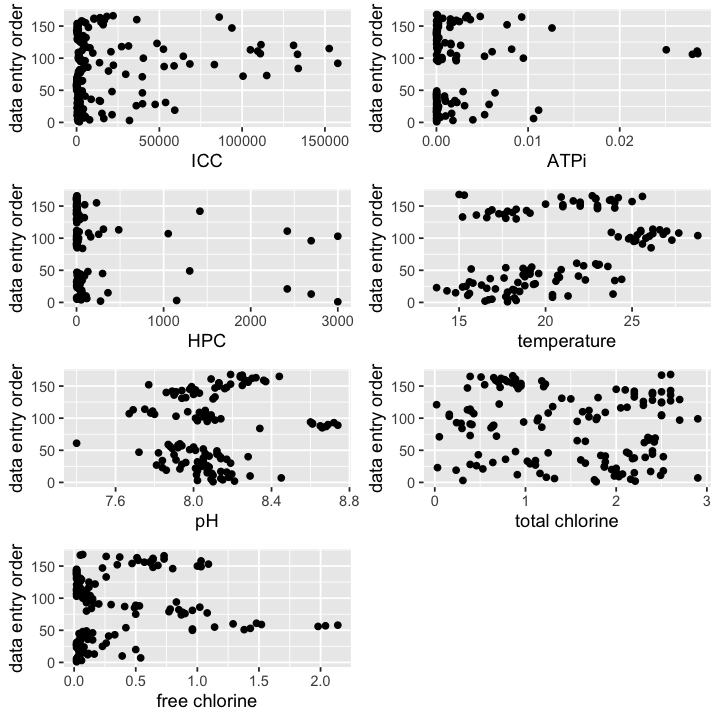

In [18]:
options(warn=-1)# turn off warnings for plots + font extra


a<-raw_dat
a$rw<-seq.int(nrow(a))
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


ylabel<-ylab("data entry order")
plt<-geom_point()
options(repr.plot.width = 6, repr.plot.height = 6) #for plotting size in jupyter

aa<-ggplot(a, aes(x = SGPI, y = rw)) +
    plt+
    xlab("ICC") +
    ylabel
b<-ggplot(a, aes(x = intra_ATP_gmean_nM, y = rw)) +
    plt+
    xlab("ATPi") +
    ylabel 
c<-ggplot(a, aes(x = HPC_gmean_MPN_per_100mL, y = rw)) +
    plt+
    xlab("HPC") +
    ylabel
d<-ggplot(a, aes(x = temp_C, y = rw)) +
    plt+
    xlab("temperature") +
    ylabel
e<-ggplot(a, aes(x = pH, y = rw)) +
    geom_point()+
    xlab("pH") +
    ylabel
f<-ggplot(a, aes(x = total_Cl2_mg.L, y = rw)) +
    plt+
    xlab("total chlorine") +
   ylabel
g<-ggplot(a, aes(x = free_Cl2_mg.L, y = rw)) +
    plt+
    xlab("free chlorine") +
    ylabel

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")


Possibly some outliers at the high end of ATPi and HPC

#### Is there colinearity in continuous variables?

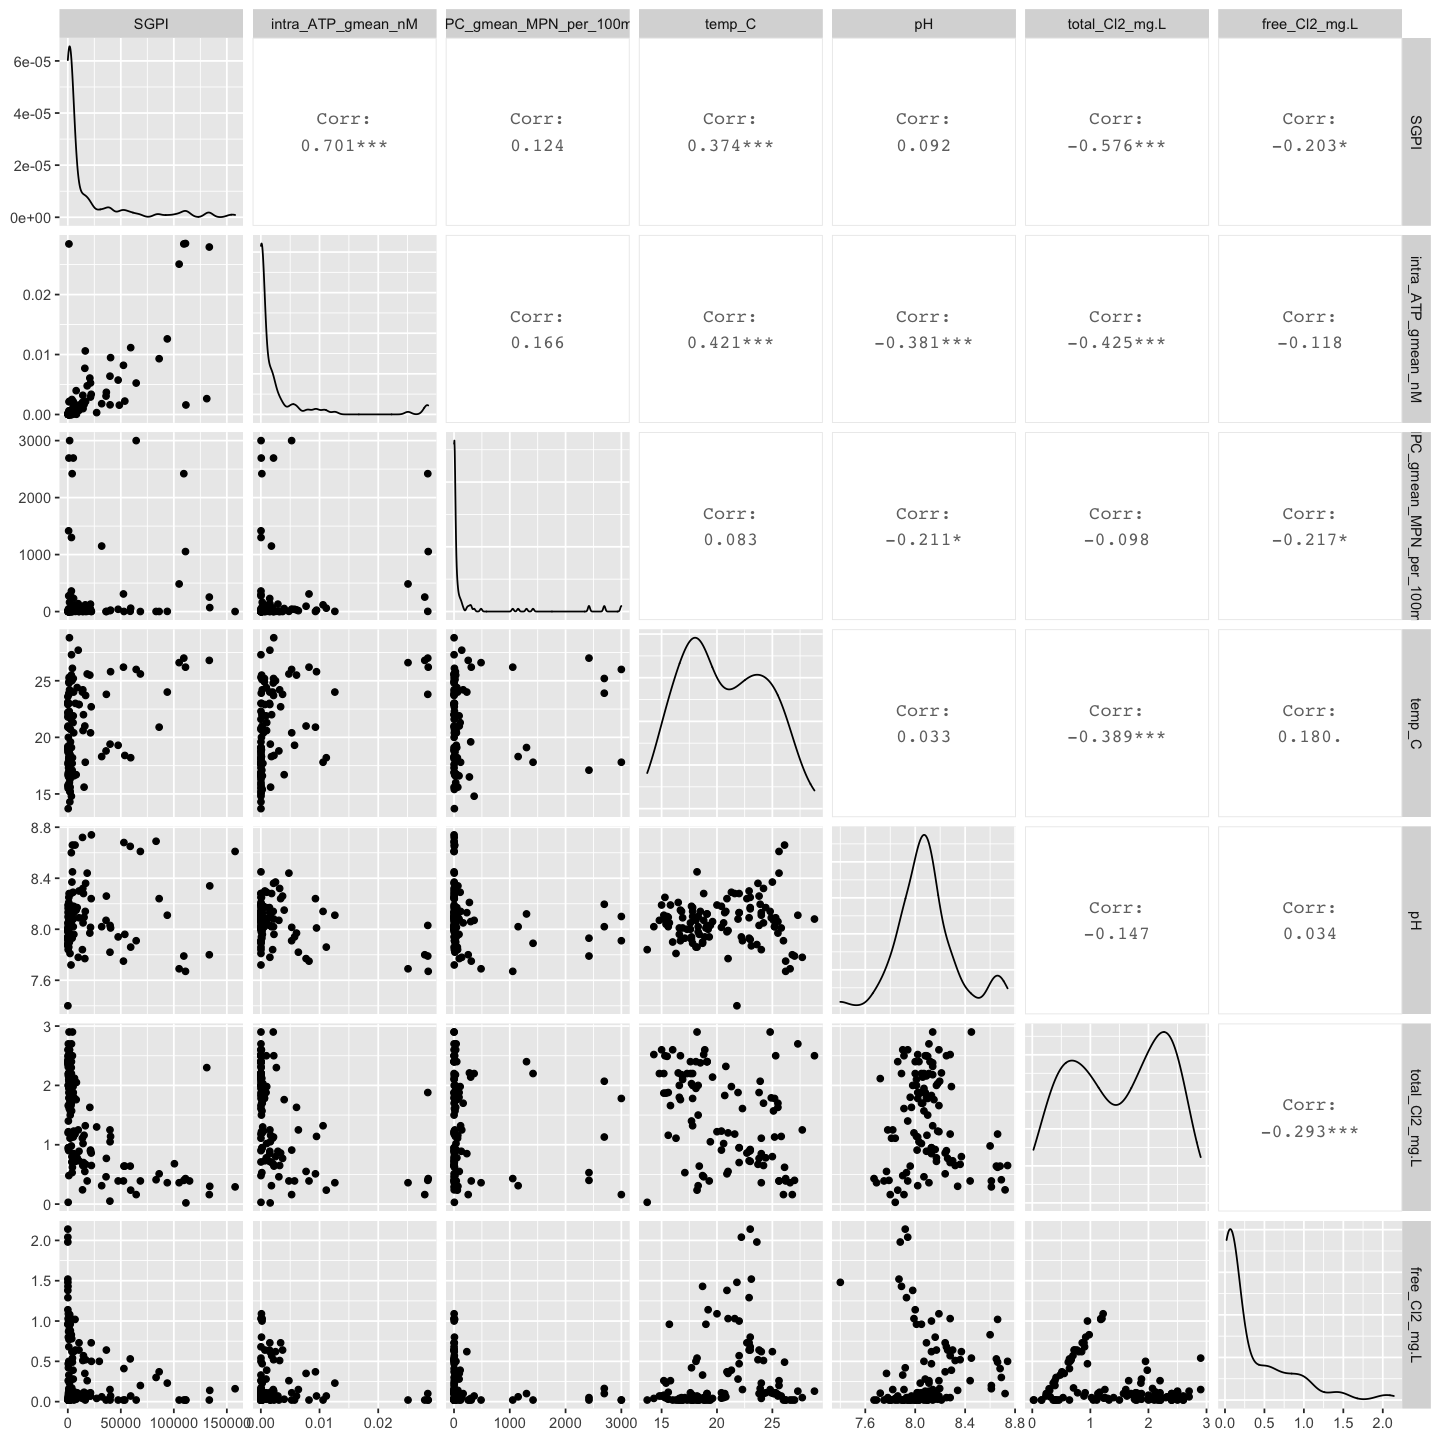

In [19]:
options(repr.plot.width = 12, repr.plot.height = 12) #for plotting size in jupyter
ggpairs(raw_dat_num)


yes, pH and free chlorine covary

#### Is there covariation in categorical variable (disinfectant used)?

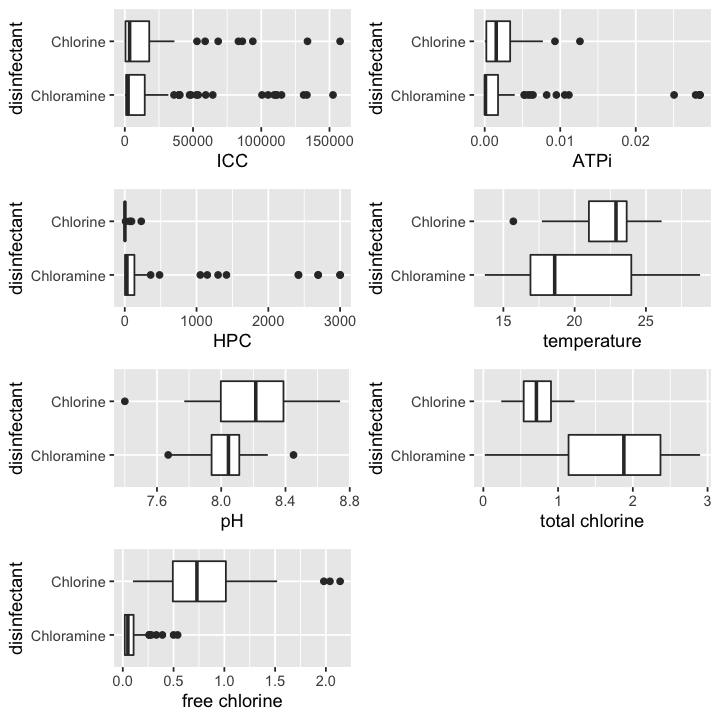

In [20]:
a<-raw_dat
a<-a%>% rename("rw" = disinfectant)
ylabel<-ylab("disinfectant")
plt<-geom_boxplot()
options(repr.plot.width = 6, repr.plot.height = 6) #for plotting size in jupyter

aa<-ggplot(a, aes(x = SGPI, y = rw)) +
    plt+
    xlab("ICC") +
    ylabel
b<-ggplot(a, aes(x = intra_ATP_gmean_nM, y = rw)) +
    plt+
    xlab("ATPi") +
    ylabel 
c<-ggplot(a, aes(x = HPC_gmean_MPN_per_100mL, y = rw)) +
    plt+
    xlab("HPC") +
    ylabel
d<-ggplot(a, aes(x = temp_C, y = rw)) +
    plt+
    xlab("temperature") +
    ylabel
e<-ggplot(a, aes(x = pH, y = rw)) +
    plt+
    xlab("pH") +
    ylabel
f<-ggplot(a, aes(x = total_Cl2_mg.L, y = rw)) +
    plt+
    xlab("total chlorine") +
   ylabel
g<-ggplot(a, aes(x = free_Cl2_mg.L, y = rw)) +
    plt+
    xlab("free chlorine") +
    ylabel


ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")


all covariates depend on the disinfectant type used in the DWDSs

#### What is the relationship between each fixed variable and each microbial abundance measure?

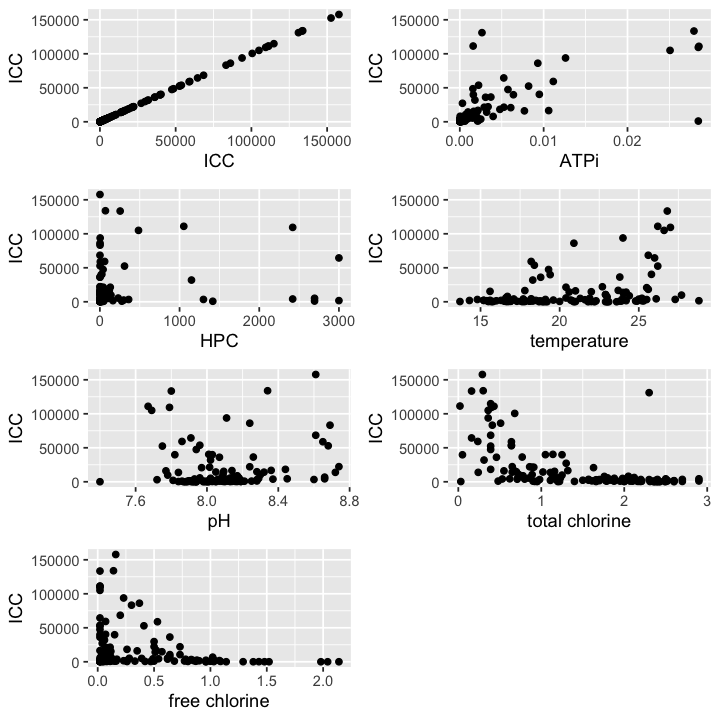

In [21]:
a<-raw_dat
a$rw<-a$SGPI
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


ylabel<-ylab("ICC")
plt<-geom_point()
options(repr.plot.width = 6, repr.plot.height = 6) #for plotting size in jupyter

aa<-ggplot(a, aes(x = SGPI, y = rw)) +
    plt+
    xlab("ICC") +
    ylabel
b<-ggplot(a, aes(x = intra_ATP_gmean_nM, y = rw)) +
    plt+
    xlab("ATPi") +
    ylabel 
c<-ggplot(a, aes(x = HPC_gmean_MPN_per_100mL, y = rw)) +
    plt+
    xlab("HPC") +
    ylabel
d<-ggplot(a, aes(x = temp_C, y = rw)) +
    plt+
    xlab("temperature") +
    ylabel
e<-ggplot(a, aes(x = pH, y = rw)) +
    geom_point()+
    xlab("pH") +
    ylabel
f<-ggplot(a, aes(x = total_Cl2_mg.L, y = rw)) +
    plt+
    xlab("total chlorine") +
   ylabel
g<-ggplot(a, aes(x = free_Cl2_mg.L, y = rw)) +
    plt+
    xlab("free chlorine") +
    ylabel

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")


Only a linear realitonship between SGPI and ATPi

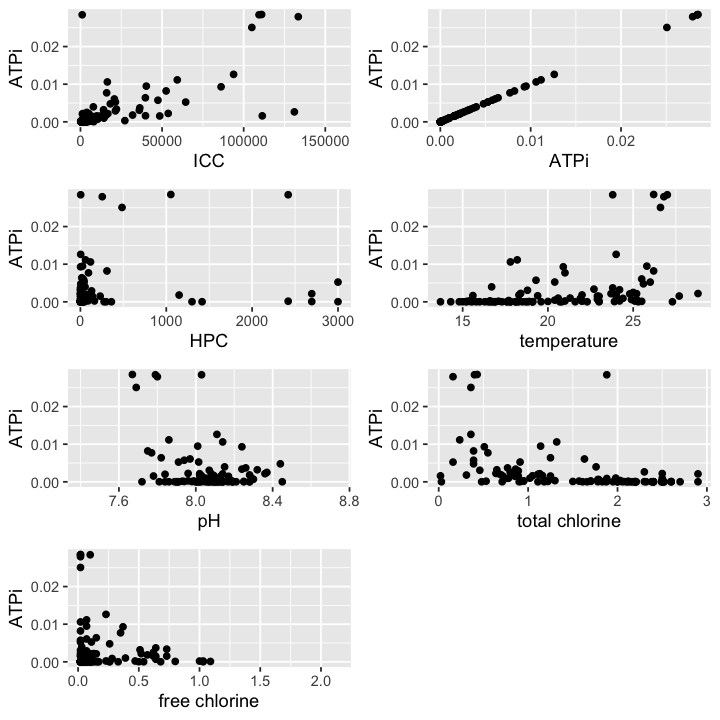

In [22]:
a<-raw_dat
a$rw<-a$intra_ATP_gmean_nM
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


ylabel<-ylab("ATPi")
plt<-geom_point()
options(repr.plot.width = 6, repr.plot.height = 6) #for plotting size in jupyter

aa<-ggplot(a, aes(x = SGPI, y = rw)) +
    plt+
    xlab("ICC") +
    ylabel
b<-ggplot(a, aes(x = intra_ATP_gmean_nM, y = rw)) +
    plt+
    xlab("ATPi") +
    ylabel 
c<-ggplot(a, aes(x = HPC_gmean_MPN_per_100mL, y = rw)) +
    plt+
    xlab("HPC") +
    ylabel
d<-ggplot(a, aes(x = temp_C, y = rw)) +
    plt+
    xlab("temperature") +
    ylabel
e<-ggplot(a, aes(x = pH, y = rw)) +
    geom_point()+
    xlab("pH") +
    ylabel
f<-ggplot(a, aes(x = total_Cl2_mg.L, y = rw)) +
    plt+
    xlab("total chlorine") +
   ylabel
g<-ggplot(a, aes(x = free_Cl2_mg.L, y = rw)) +
    plt+
    xlab("free chlorine") +
    ylabel

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")


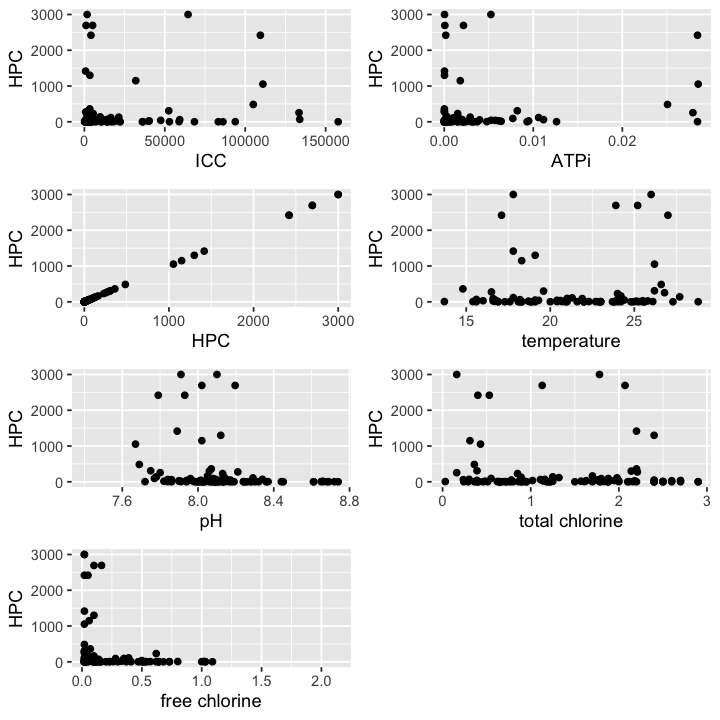

In [23]:
a<-raw_dat
a$rw<-a$HPC_gmean_MPN_per_100mL
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


ylabel<-ylab("HPC")
plt<-geom_point()
options(repr.plot.width = 6, repr.plot.height = 6) #for plotting size in jupyter

aa<-ggplot(a, aes(x = SGPI, y = rw)) +
    plt+
    xlab("ICC") +
    ylabel
b<-ggplot(a, aes(x = intra_ATP_gmean_nM, y = rw)) +
    plt+
    xlab("ATPi") +
    ylabel 
c<-ggplot(a, aes(x = HPC_gmean_MPN_per_100mL, y = rw)) +
    plt+
    xlab("HPC") +
    ylabel
d<-ggplot(a, aes(x = temp_C, y = rw)) +
    plt+
    xlab("temperature") +
    ylabel
e<-ggplot(a, aes(x = pH, y = rw)) +
    geom_point()+
    xlab("pH") +
    ylabel
f<-ggplot(a, aes(x = total_Cl2_mg.L, y = rw)) +
    plt+
    xlab("total chlorine") +
   ylabel
g<-ggplot(a, aes(x = free_Cl2_mg.L, y = rw)) +
    plt+
    xlab("free chlorine") +
    ylabel

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")


#### Are there clear dependency structures in the data?

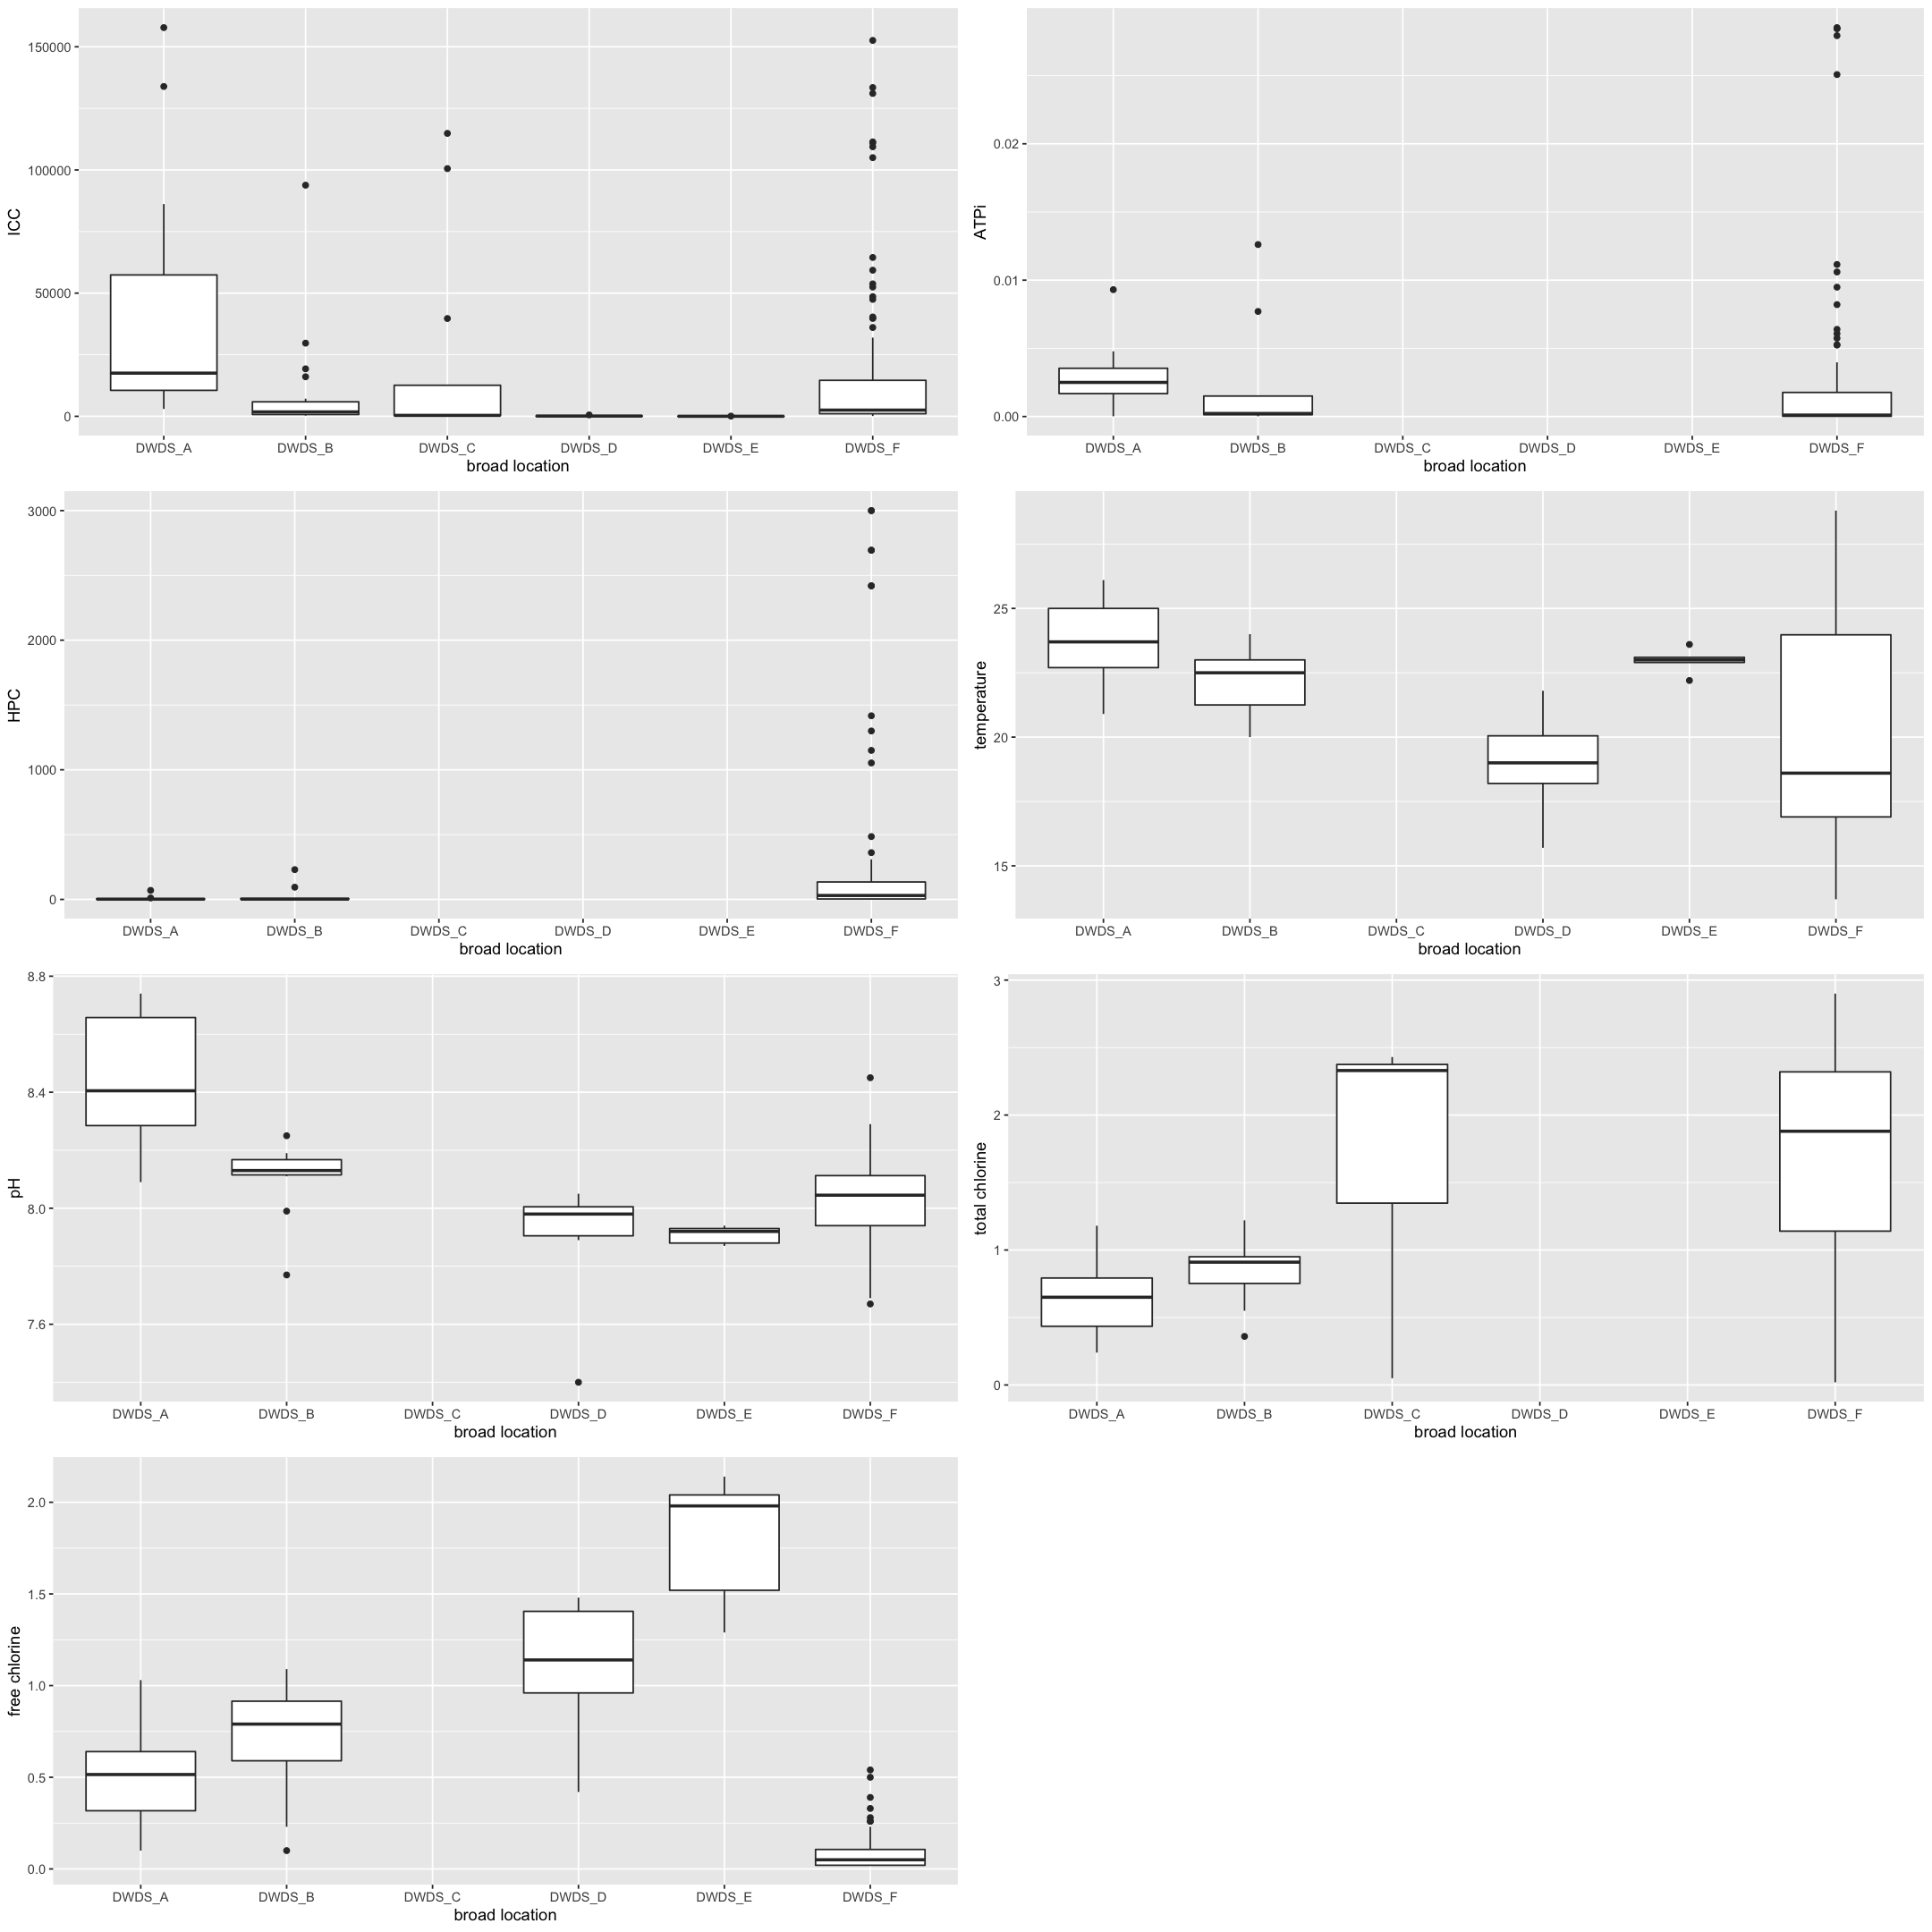

In [24]:
a<-raw_dat
a$rw<-a$broad_location
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("broad location")
wrap<-theme()
plt<-geom_boxplot()
options(repr.plot.width = 18, repr.plot.height = 18) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap
d<-ggplot(a, aes(y = temp_C, x = rw)) +
    plt+
    ylab("temperature") +
    xlabel +
    wrap
e<-ggplot(a, aes(y = pH, x = rw)) +
    plt+
    ylab("pH") +
    xlabel +
    wrap
f<-ggplot(a, aes(y = total_Cl2_mg.L, x = rw)) +
    plt+
    ylab("total chlorine") +
    xlabel +
    wrap
g<-ggplot(a, aes(y = free_Cl2_mg.L, x = rw)) +
    plt+
    ylab("free chlorine") +
    xlabel +
    wrap

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")

variation by broad locaion for most variables

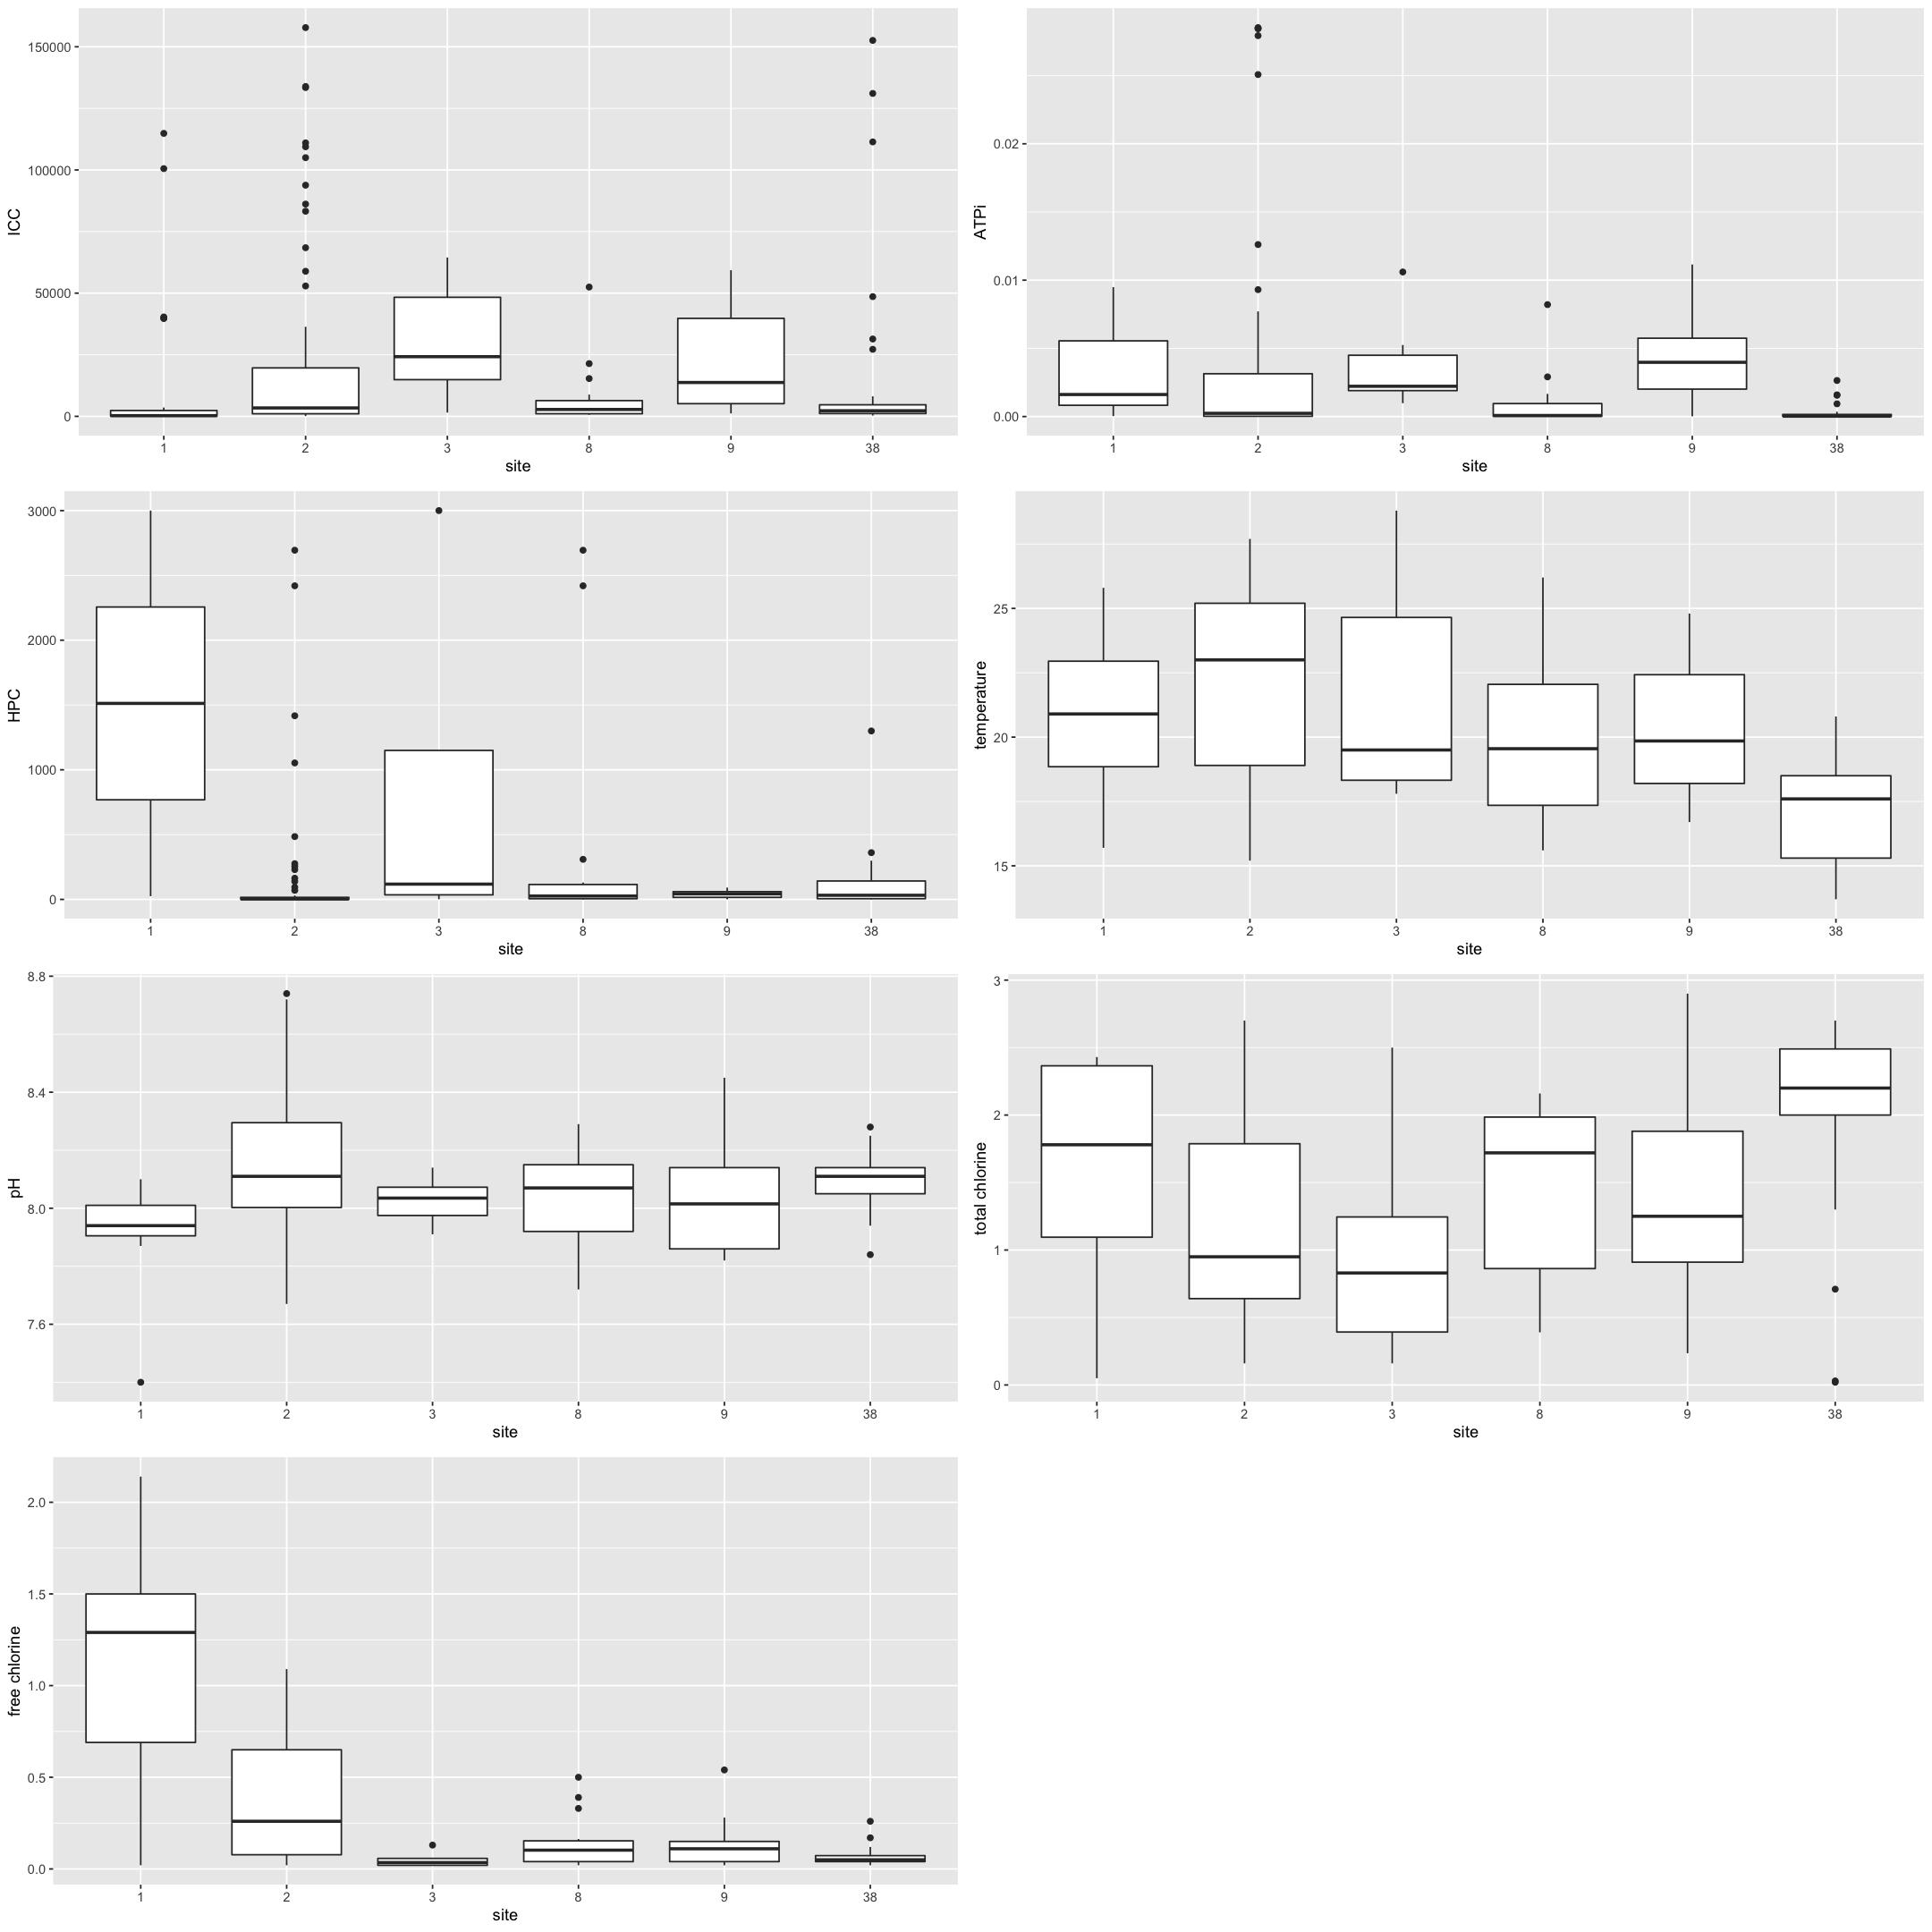

In [25]:
a<-raw_dat
a$rw<-a$count
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("site")
wrap<-theme()
plt<-geom_boxplot()
options(repr.plot.width = 18, repr.plot.height = 18) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap
d<-ggplot(a, aes(y = temp_C, x = rw)) +
    plt+
    ylab("temperature") +
    xlabel +
    wrap
e<-ggplot(a, aes(y = pH, x = rw)) +
    plt+
    ylab("pH") +
    xlabel +
    wrap
f<-ggplot(a, aes(y = total_Cl2_mg.L, x = rw)) +
    plt+
    ylab("total chlorine") +
    xlabel +
    wrap
g<-ggplot(a, aes(y = free_Cl2_mg.L, x = rw)) +
    plt+
    ylab("free chlorine") +
    xlabel +
    wrap

ggarrange(aa,  b,c,d,e,f,g,
           ncol = 2, nrow = 4 , legend="none")

variation by site in most variables

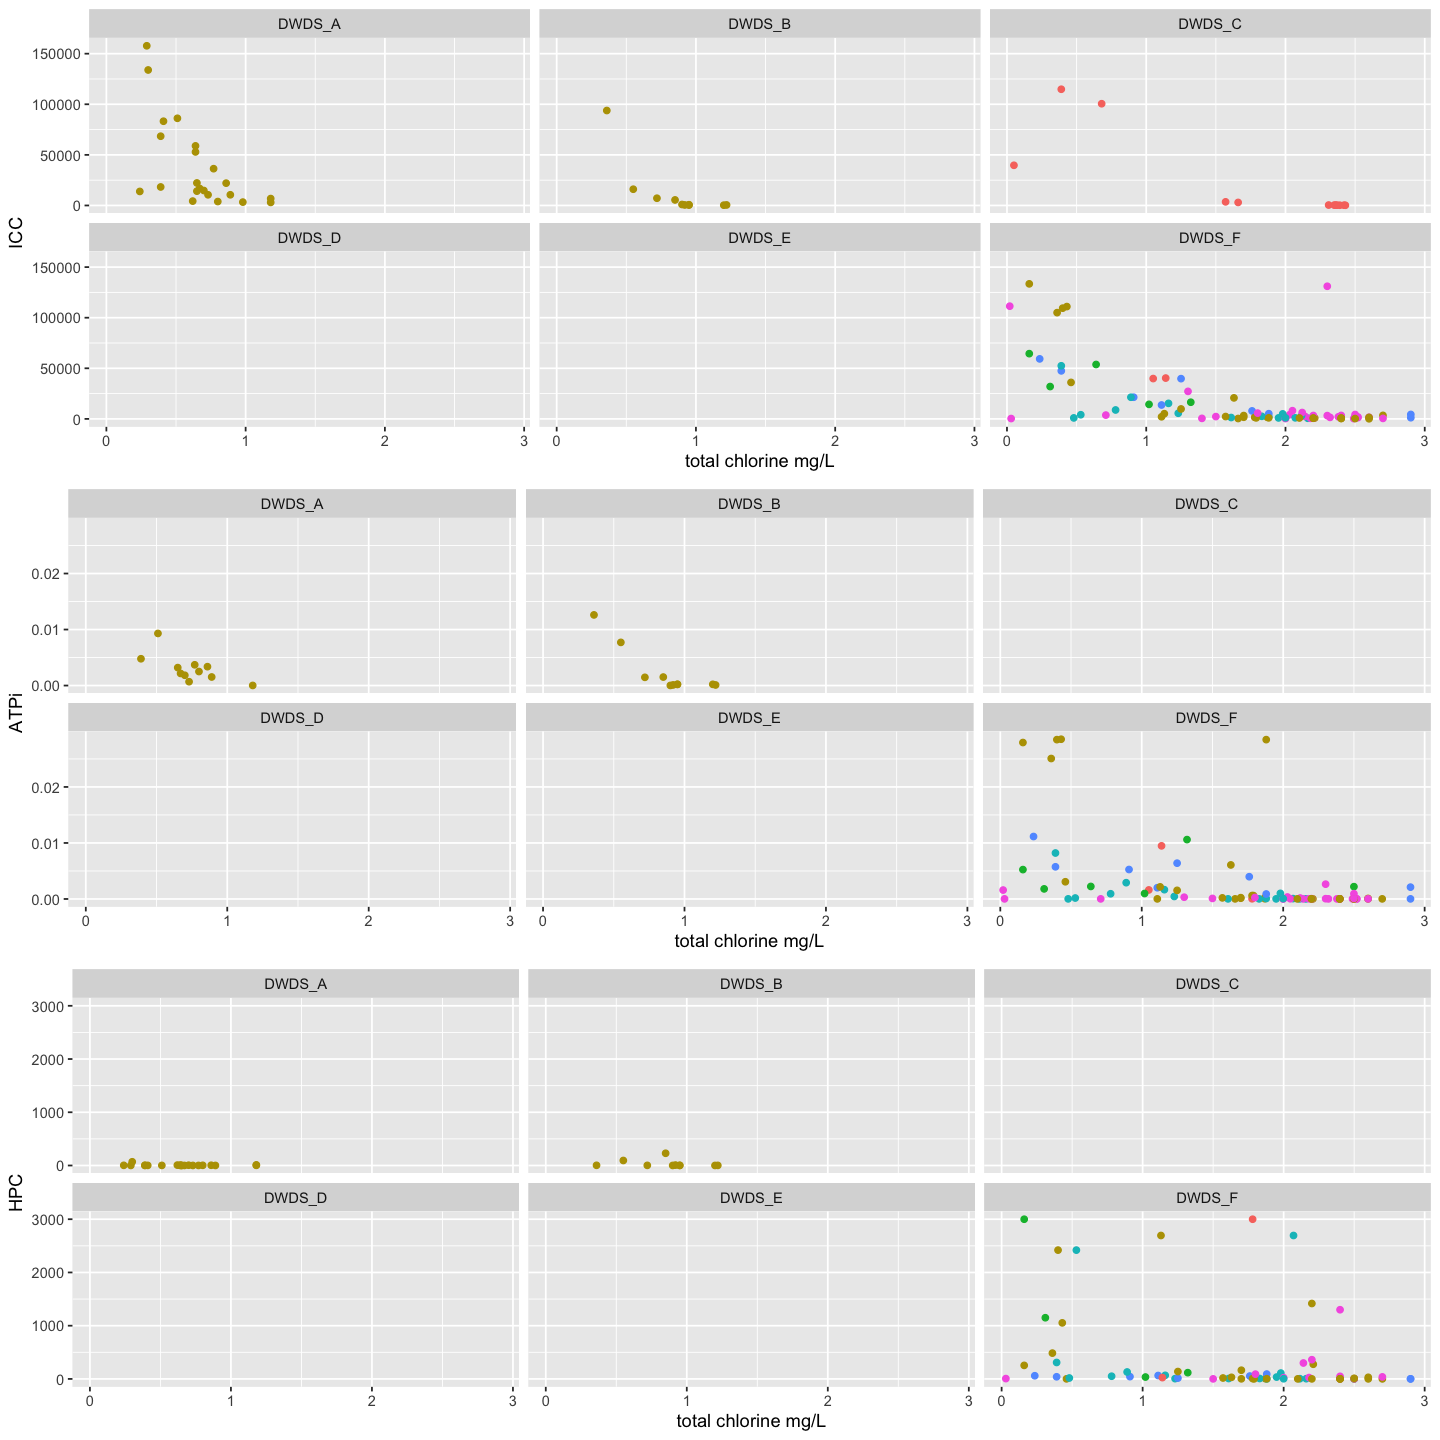

In [26]:
a<-raw_dat
a$rw<-a$total_Cl2_mg.L
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("total chlorine mg/L")
wrap<-facet_wrap(~broad_location)
plt<-geom_point()
options(repr.plot.width = 12, repr.plot.height = 12) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw, color= count)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw, color= count)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw, color= count)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap


ggarrange(aa,  b,c,
           ncol = 1, nrow = 3, legend="none")

possibly exponential relationship between ICC & total chlorine and ATPi & total chlorine, looks similar by site, but chlorinated systems (A & B) tend to have lower total chlorine

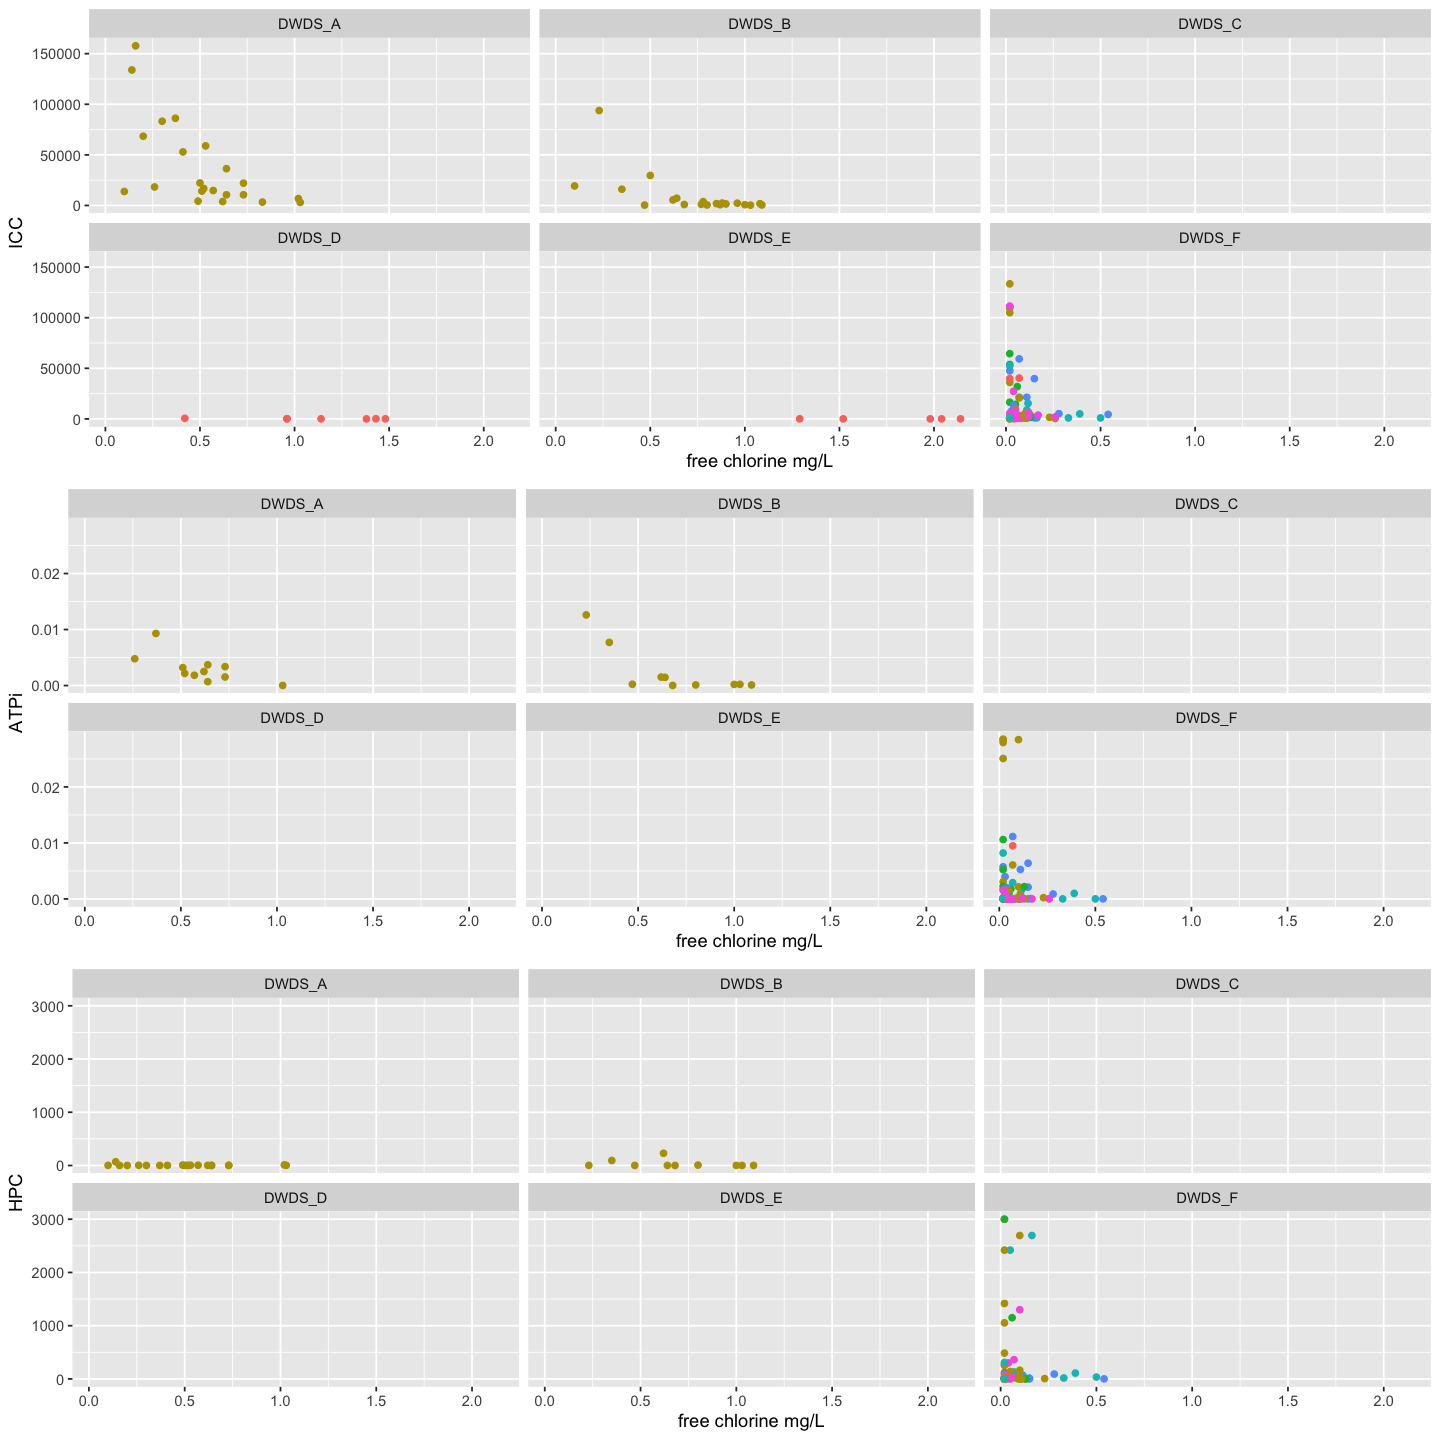

In [27]:
a<-raw_dat
a$rw<-a$free_Cl2_mg.L
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("free chlorine mg/L")
wrap<-facet_wrap(~broad_location)
plt<-geom_point()
options(repr.plot.width = 12, repr.plot.height = 12) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw, color= count)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw, color= count)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw, color= count)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap


ggarrange(aa,  b,c,
           ncol = 1, nrow = 3, legend="none")

possibly exponential relationship between ICC & total chlorine and ATPi & total chlorine, looks similar by site, but free chlorinated systems have higher free chlorine concentrations

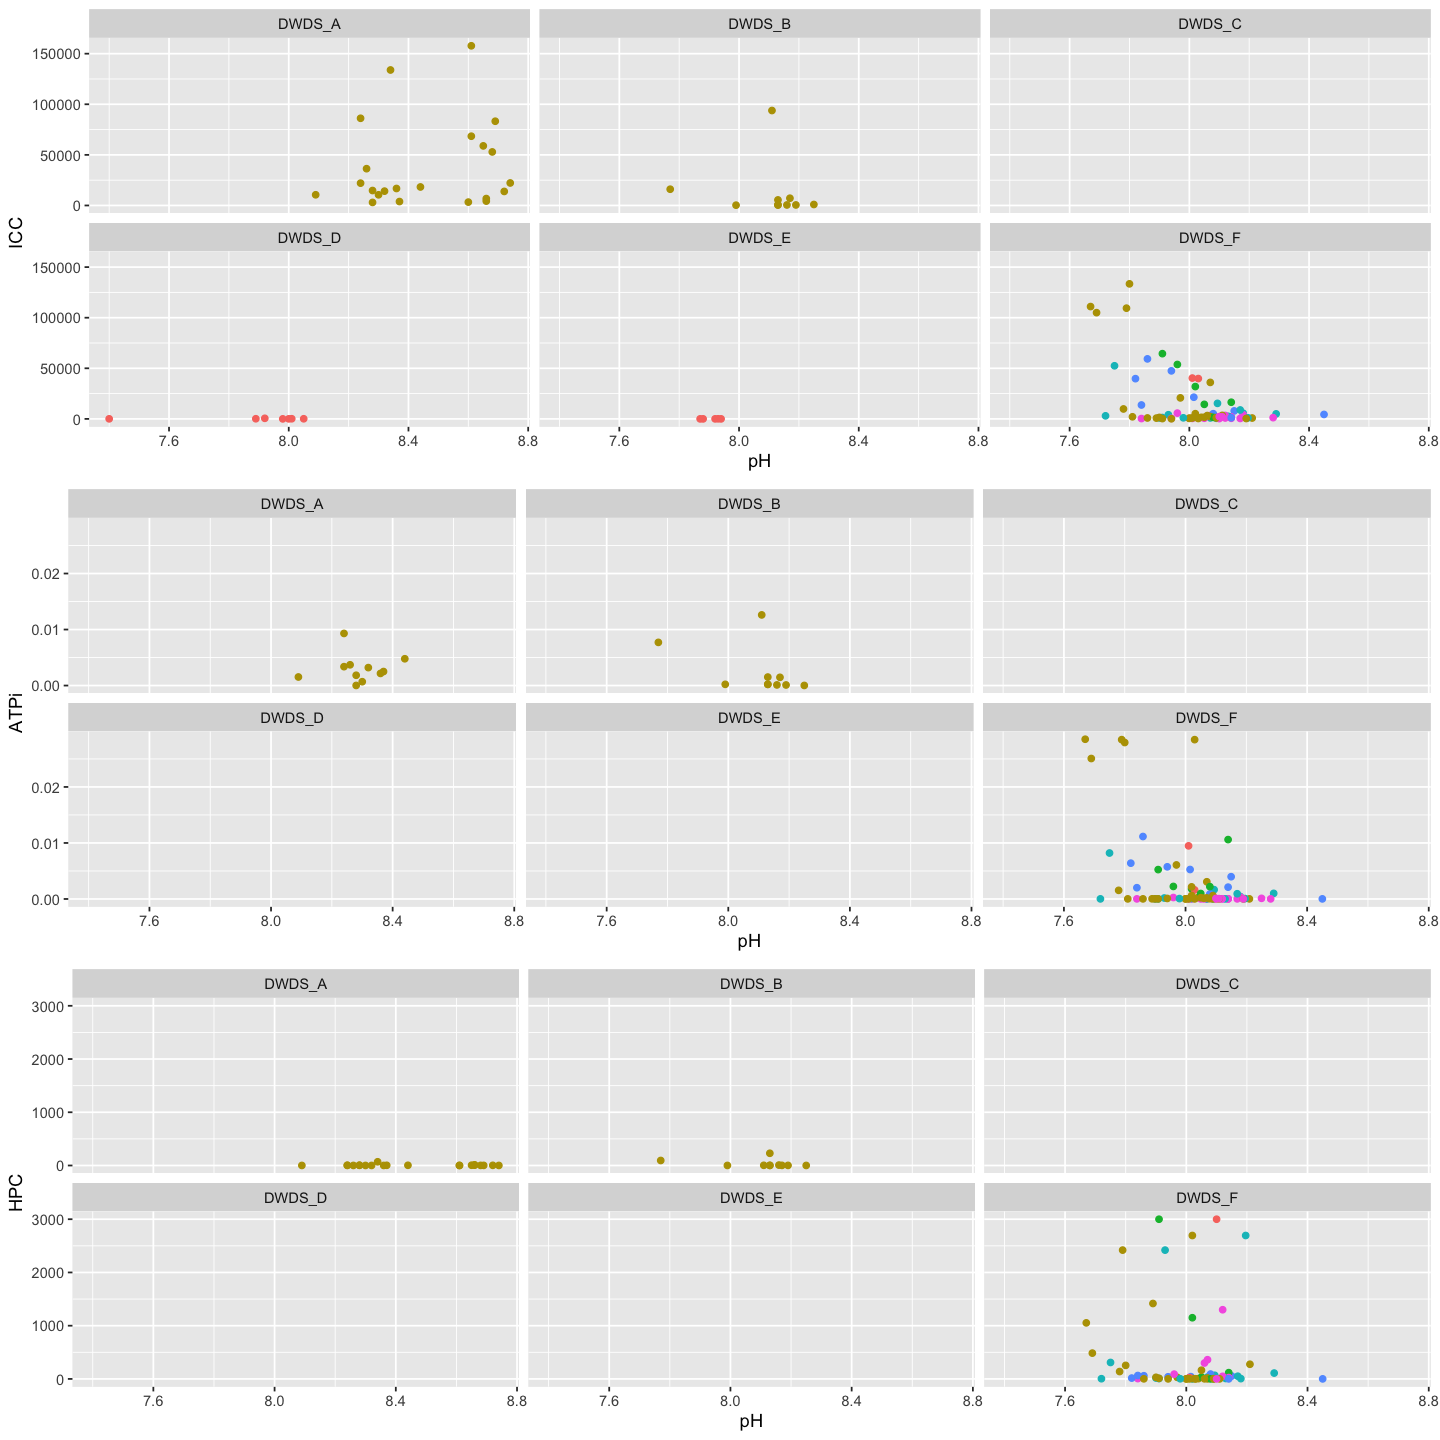

In [28]:
a<-raw_dat
a$rw<-a$pH
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("pH")
wrap<-facet_wrap(~broad_location)
plt<-geom_point()
options(repr.plot.width = 12, repr.plot.height = 12) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw, color= count)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw, color= count)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw, color= count)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap


ggarrange(aa,  b,c,
           ncol = 1, nrow = 3, legend="none")

no clear relationship

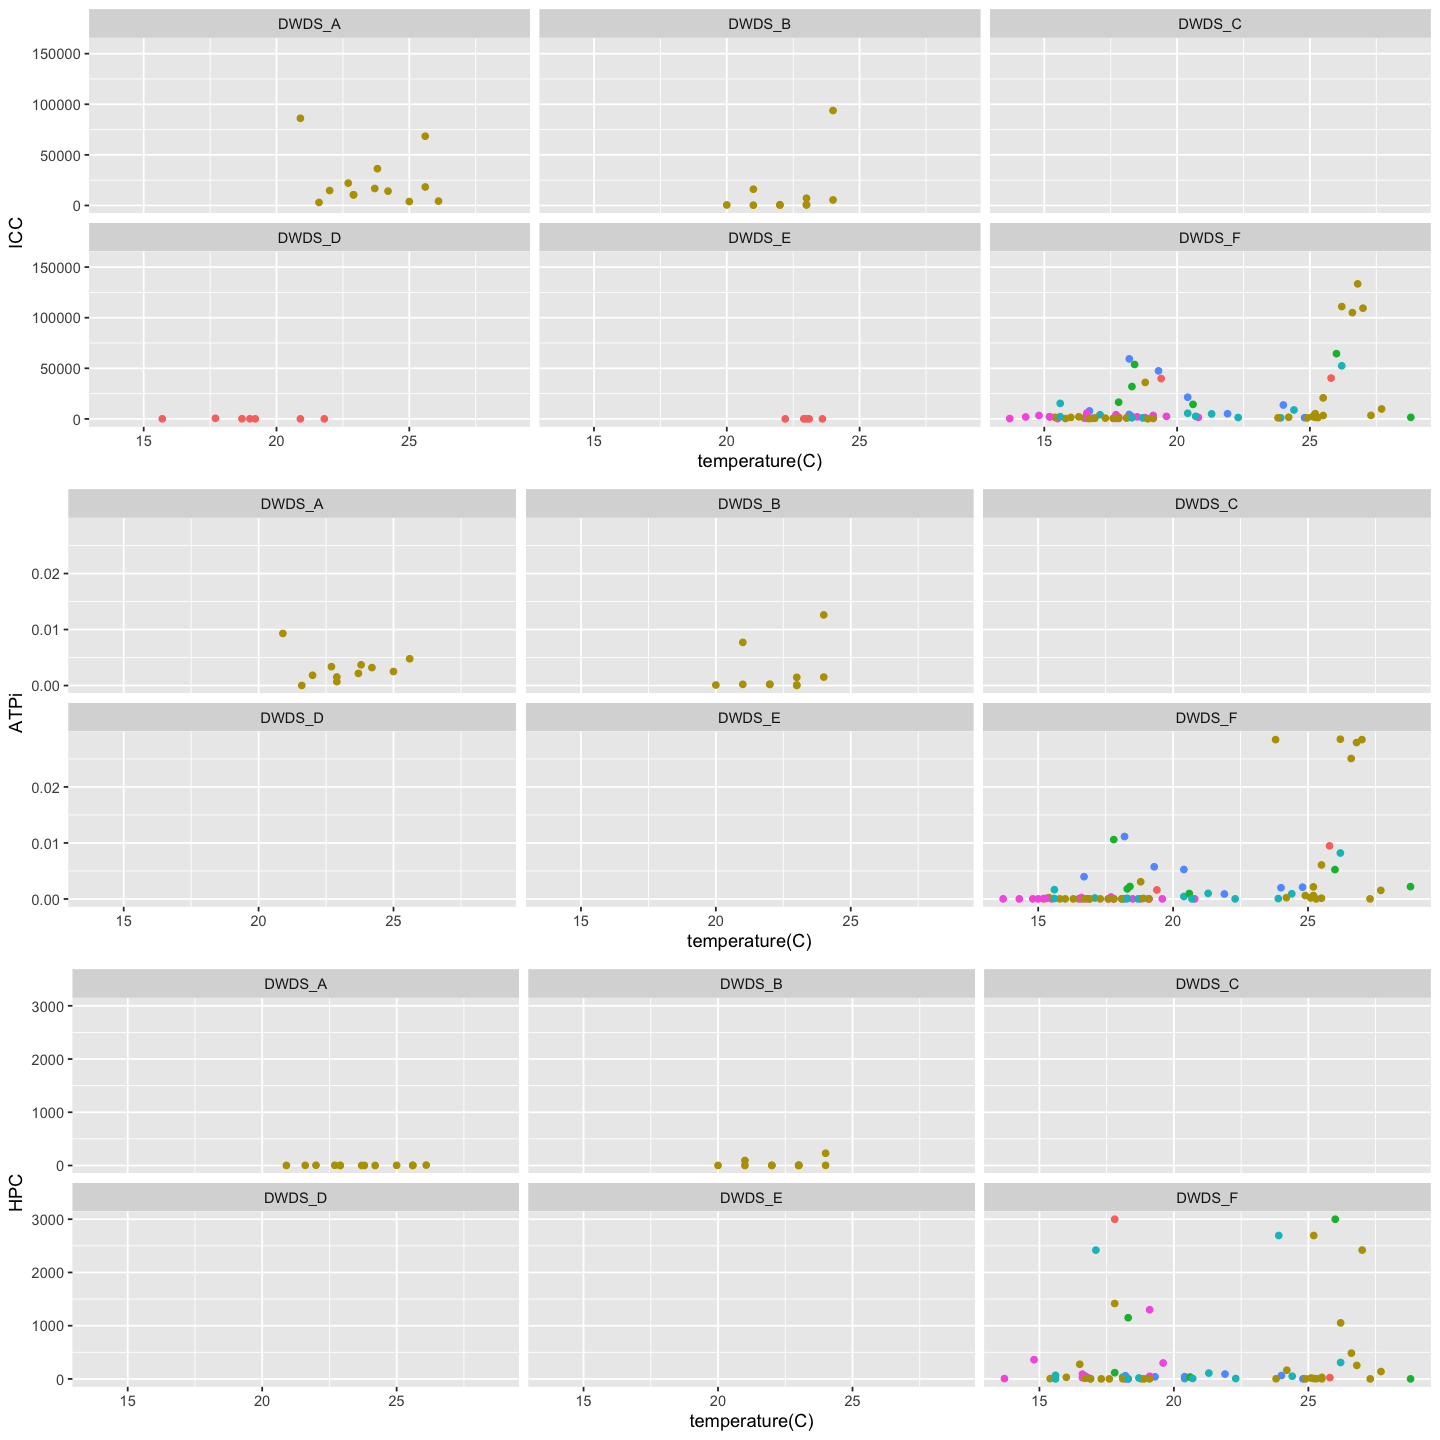

In [29]:
a<-raw_dat
a$rw<-a$temp_C
raw_dat_num<-raw_dat[,c("SGPI", "intra_ATP_gmean_nM","HPC_gmean_MPN_per_100mL", "temp_C","pH","total_Cl2_mg.L","free_Cl2_mg.L")]


xlabel<-xlab("temperature(C)")
wrap<-facet_wrap(~broad_location)
plt<-geom_point()
options(repr.plot.width = 12, repr.plot.height = 12) #for plotting size in jupyter

aa<-ggplot(a, aes(y = SGPI, x = rw, color= count)) +
    plt+
    ylab("ICC") +
    xlabel +
    wrap
b<-ggplot(a, aes(y = intra_ATP_gmean_nM, x = rw, color= count)) +
    plt+
    ylab("ATPi") +
    xlabel +
    wrap
c<-ggplot(a, aes(y = HPC_gmean_MPN_per_100mL, x = rw, color= count)) +
    plt+
    ylab("HPC") +
    xlabel +
    wrap


ggarrange(aa,  b,c,
           ncol = 1, nrow = 3, legend="none")

no clear relationship

Also checking for correlations between data from the same broad location and location code (dependency)

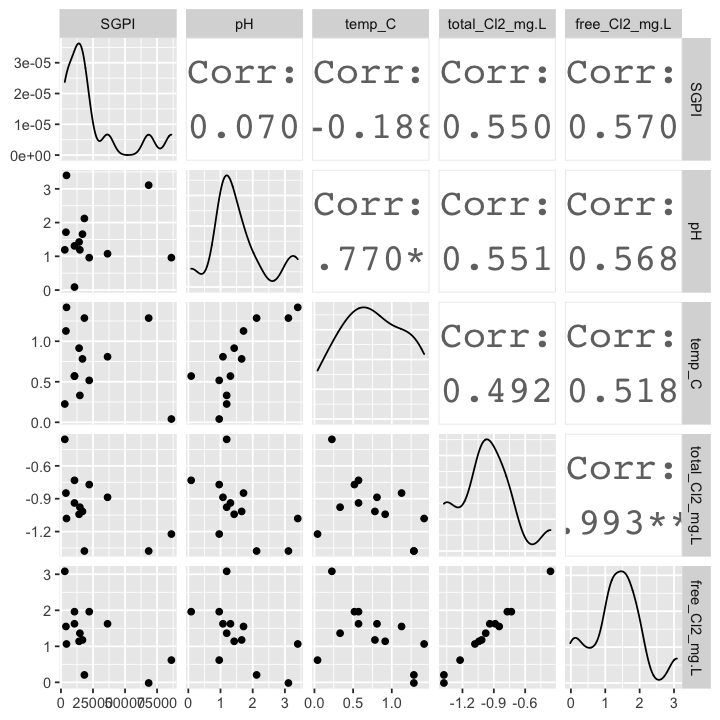

In [30]:
options(repr.plot.width =6, repr.plot.height = 6) #for plotting size in jupyter
df<-raw_ICC

col<-c('SGPI','pH','temp_C','total_Cl2_mg.L','free_Cl2_mg.L')
a<-df[df$broad_location=="DWDS_A",]
a<-a[,col]

ggpairs(a, upper = list(continuous = wrap('cor', size = 8) ) )

# b<-df[df$broad_location=="DWDS_B",]
# b<-b[,col]
#  ggpairs(b, upper = list(continuous = wrap('cor', size = 8) ) )

# f<-df[df$broad_location=="DWDS_F",]
# f<-f[,col]
#  ggpairs(f, upper = list(continuous = wrap('cor', size = 8) ) )

# g<-df[df$location_code=="site_15",]
# g<-g[,col]
#  ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

# h<-df[df$location_code=="site_10",]
# h<-h[,col]
#  ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

# i<-df[df$location_code=="site_24",]
# i<-i[,col]
#  ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

# j<-df[df$location_code=="site_ut",]
# j<-j[,col]
#  ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )





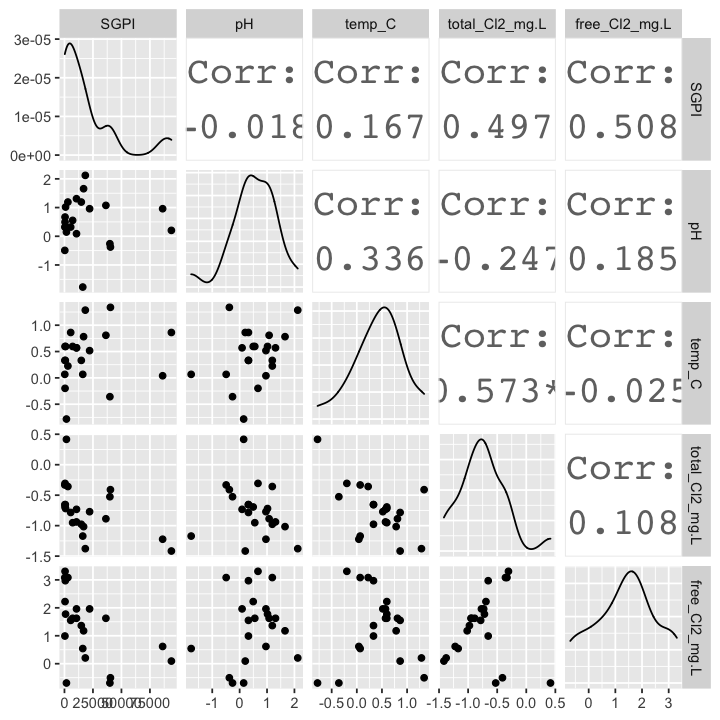

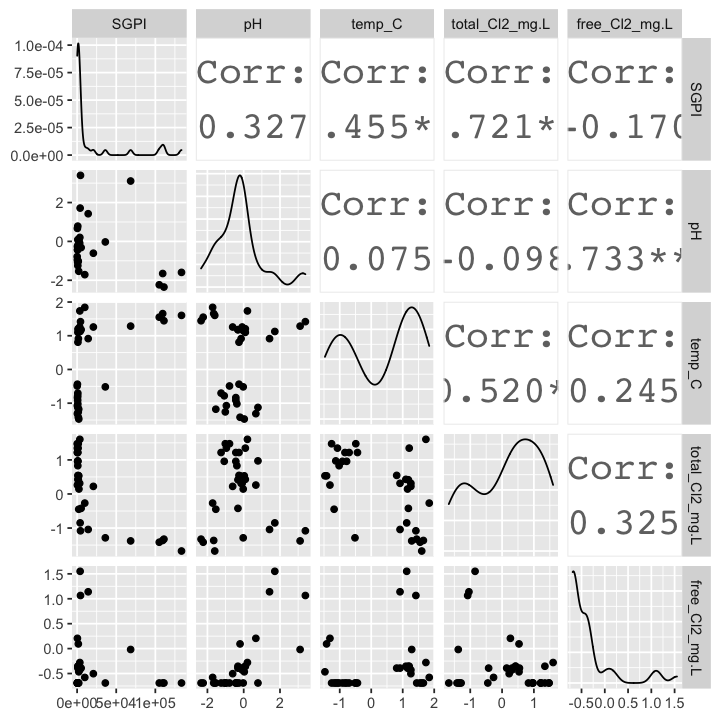

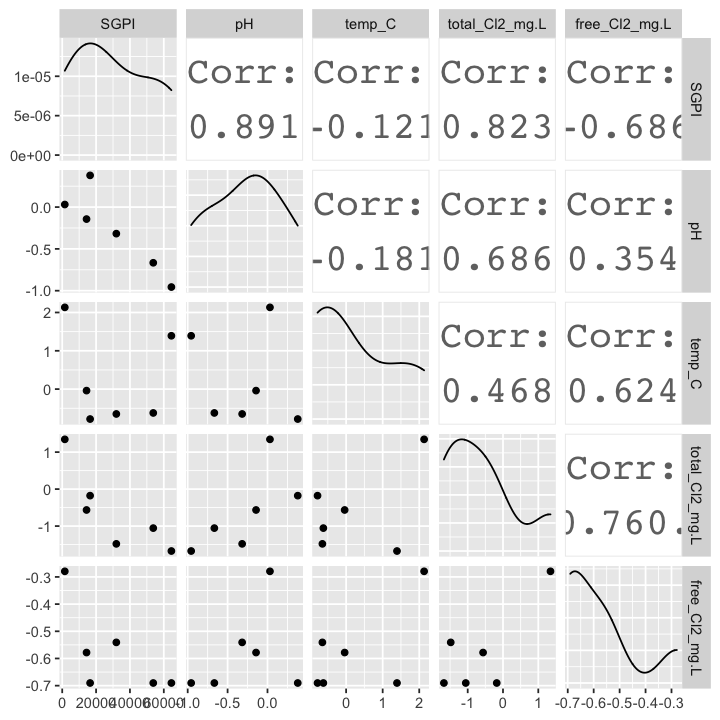

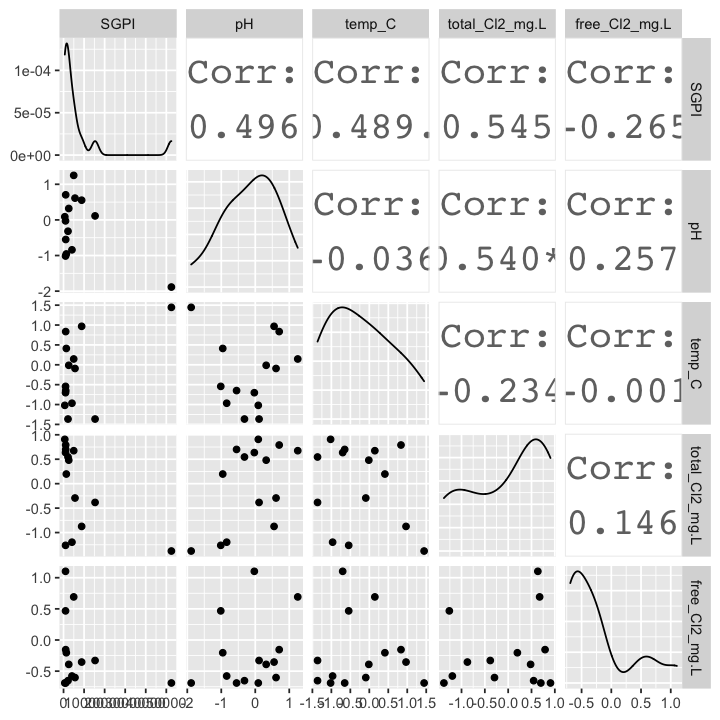

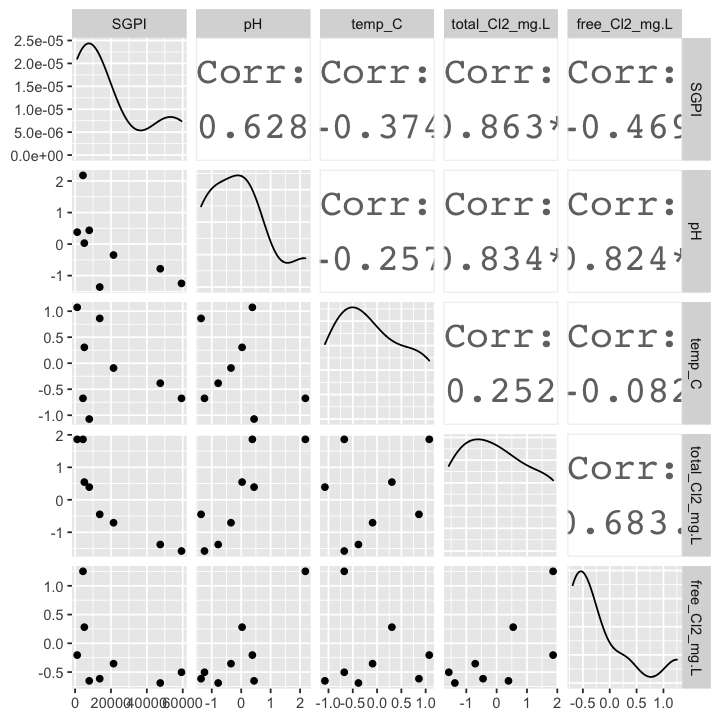

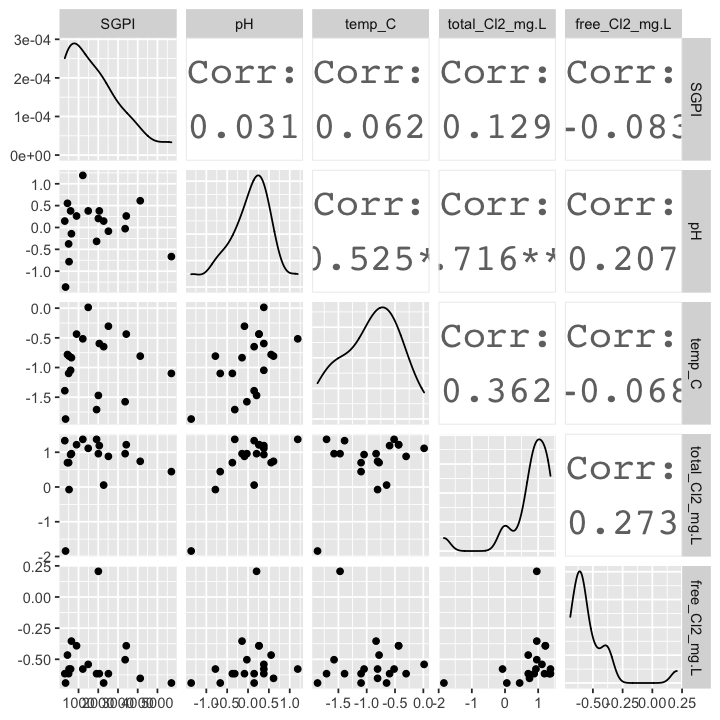

In [31]:
g<-df[df$count== 1,]
g<-g[,col]
 ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

h<-df[df$count==2,]
h<-h[,col]
 ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

i<-df[df$count==3,]
i<-i[,col]
 ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

j<-df[df$count==7,]
j<-j[,col]
 ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )

k<-df[df$count==8,] #includes 2 sites but still correlated
k<-k[,col]
 ggpairs(k, upper = list(continuous = wrap('cor', size = 8) ) )

l<-df[df$count==19,]
l<-l[,col]
 ggpairs(l, upper = list(continuous = wrap('cor', size = 8) ) )

In [32]:
unique(raw_ATPi$count)

[1] 1  2  3  8  7  20
Levels: 1 2 3 7 8 20

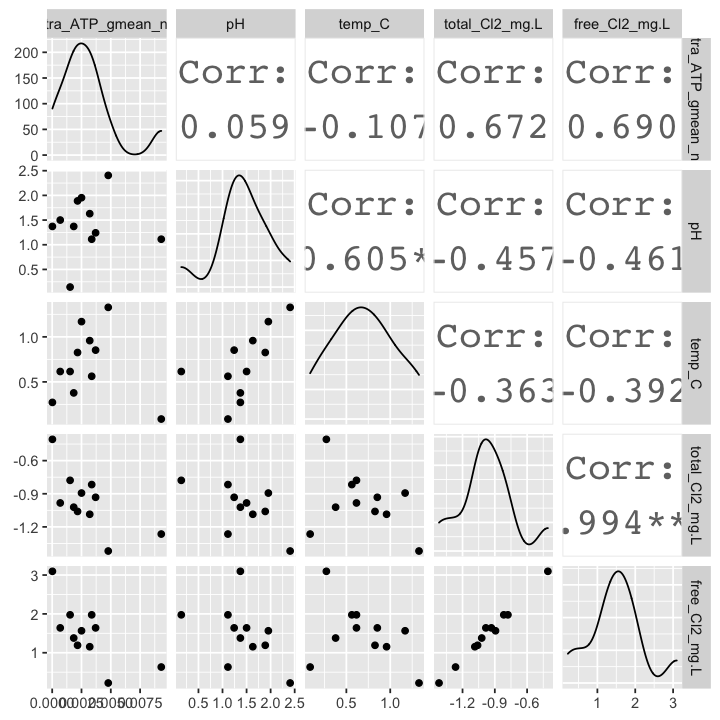

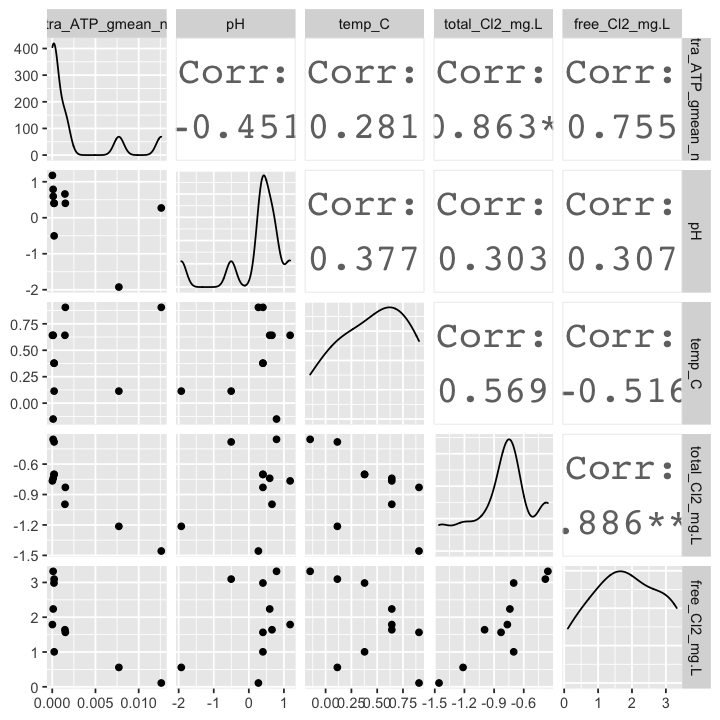

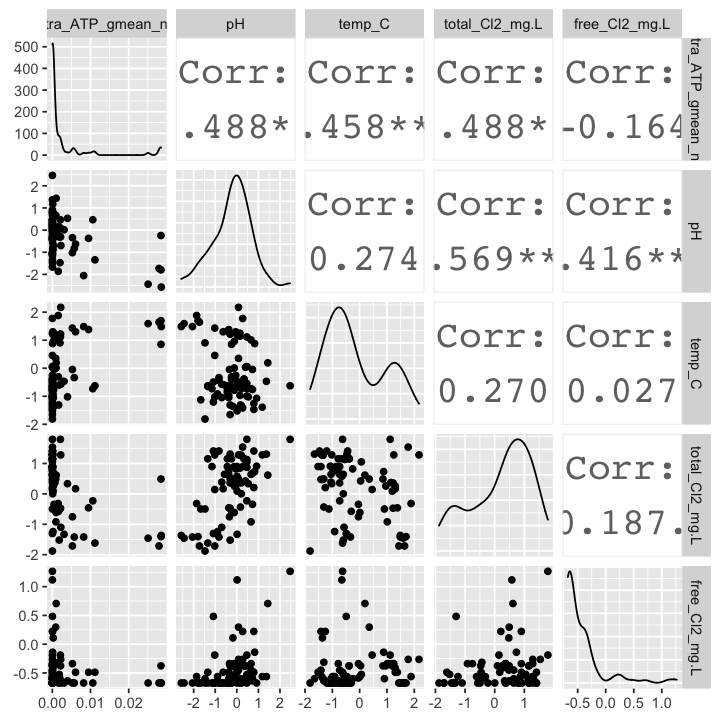

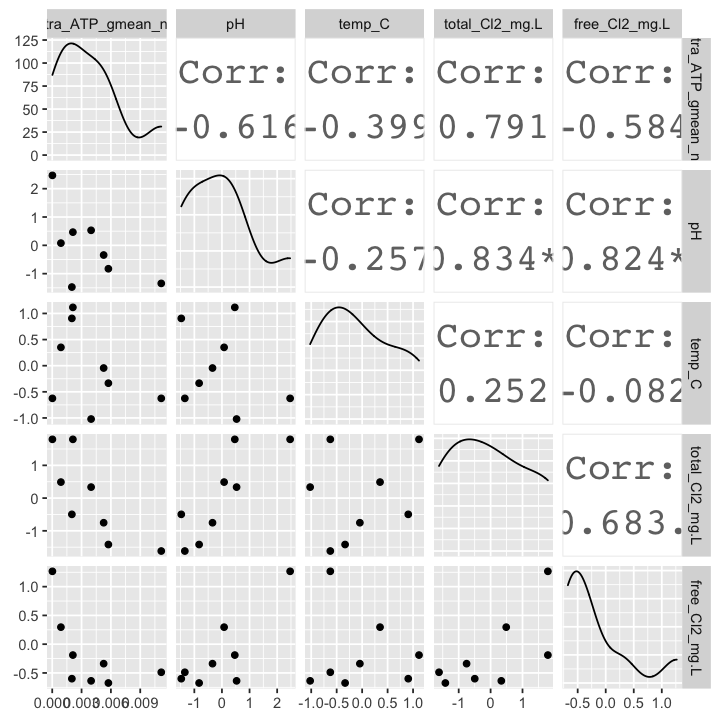

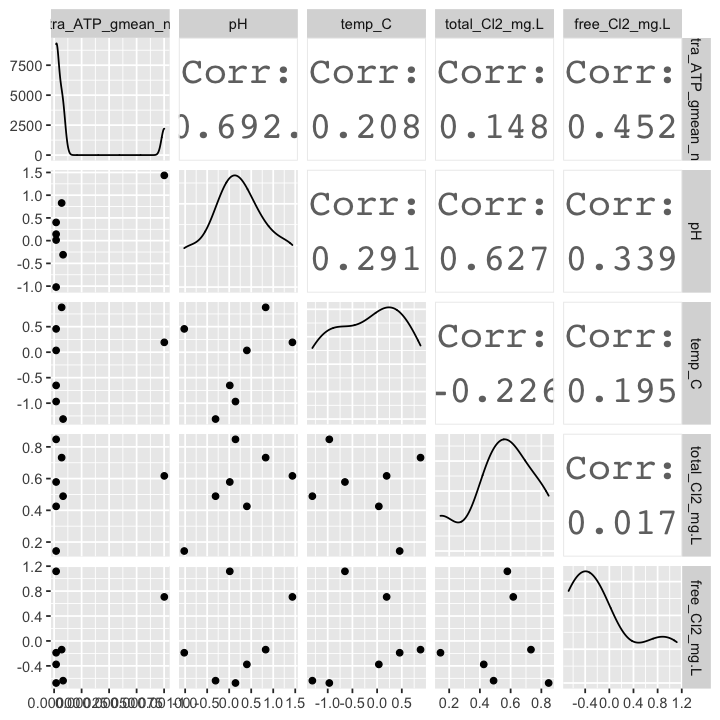

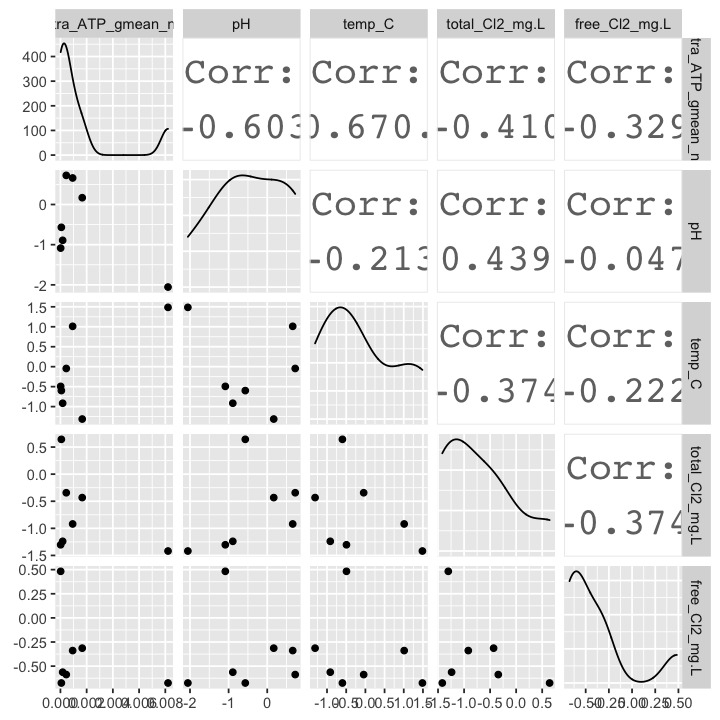

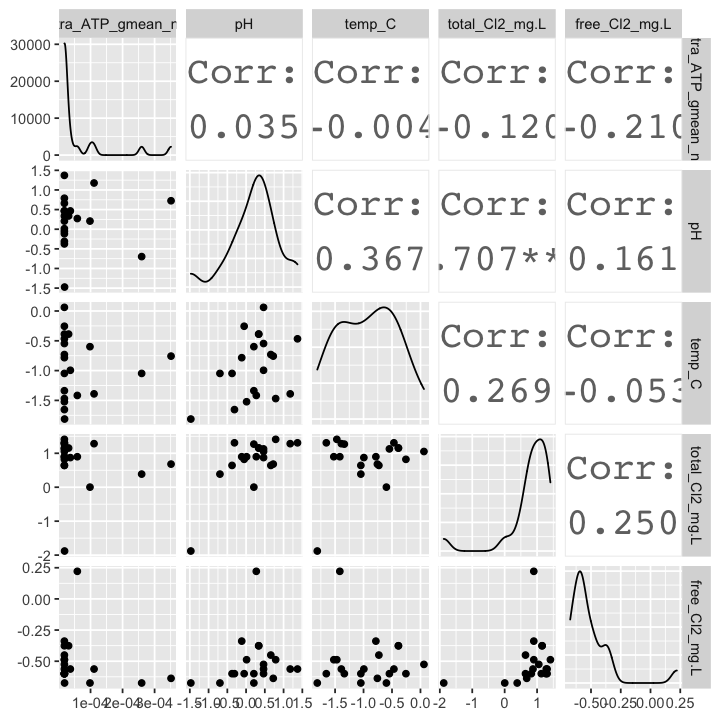

In [33]:
options(repr.plot.width =6, repr.plot.height = 6) #for plotting size in jupyter
df<-raw_ATPi
col<-c('intra_ATP_gmean_nM','pH','temp_C','total_Cl2_mg.L','free_Cl2_mg.L')
a<-df[df$broad_location=="DWDS_A",]
a<-a[,col]
ggpairs(a, upper = list(continuous = wrap('cor', size = 8) ) )

b<-df[df$broad_location=="DWDS_B",]
b<-b[,col]
 ggpairs(b, upper = list(continuous = wrap('cor', size = 8) ) )

f<-df[df$broad_location=="DWDS_F",]
f<-f[,col]
 ggpairs(f, upper = list(continuous = wrap('cor', size = 8) ) )

g<-df[df$location_code=="site_15",]
g<-g[,col]
 ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

h<-df[df$location_code=="site_10",]
h<-h[,col]
 ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

i<-df[df$location_code=="site_24",]
i<-i[,col]
 ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

j<-df[df$location_code=="site_ut",]
j<-j[,col]
 ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )







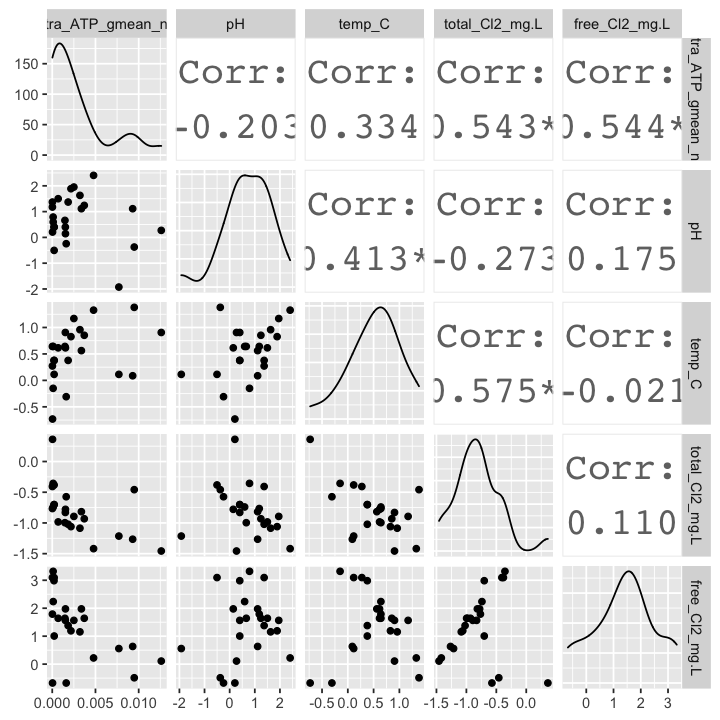

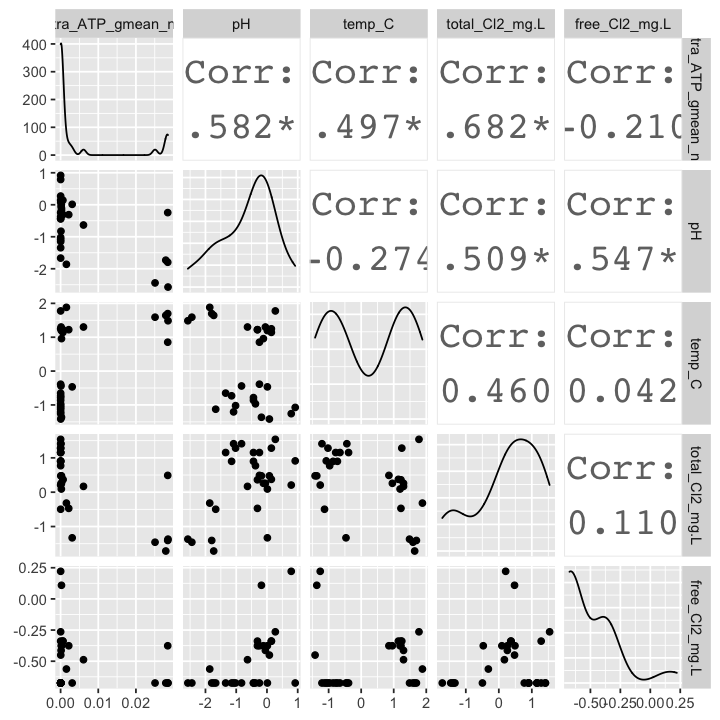

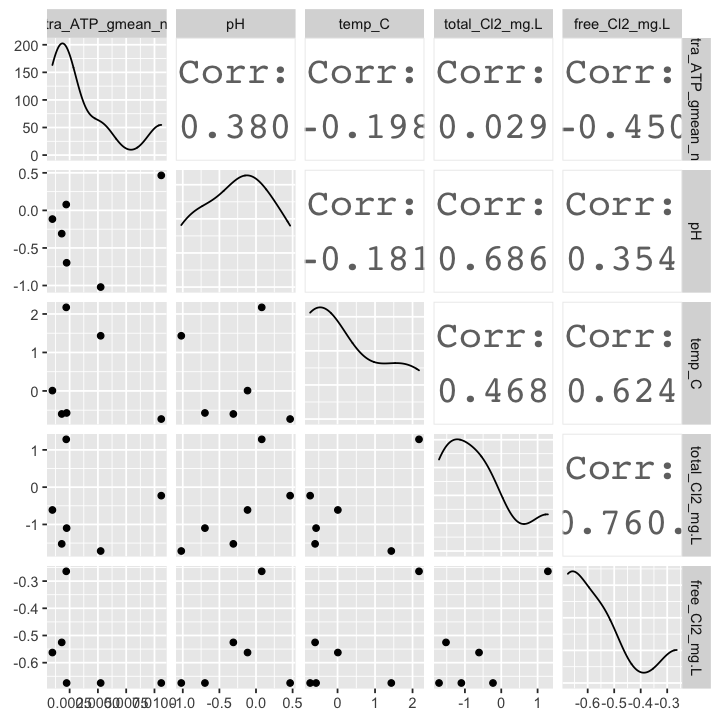

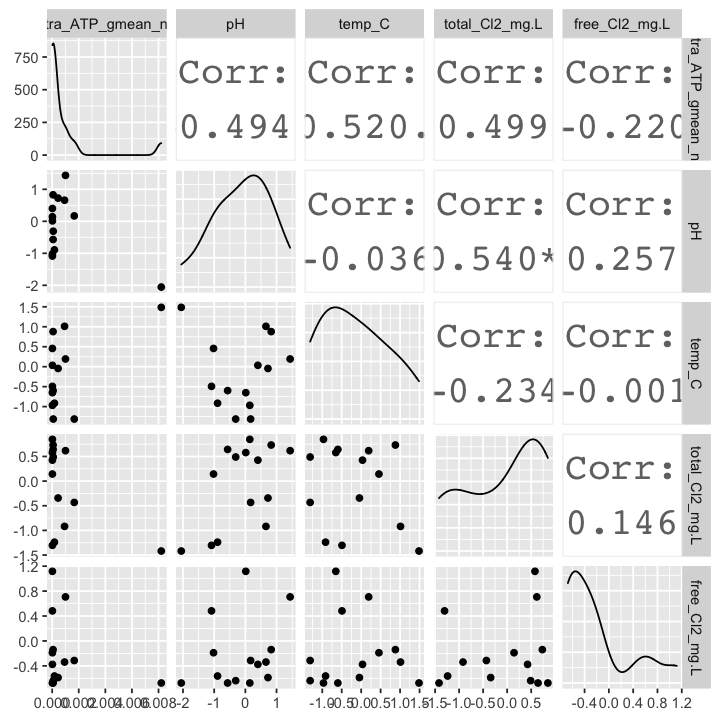

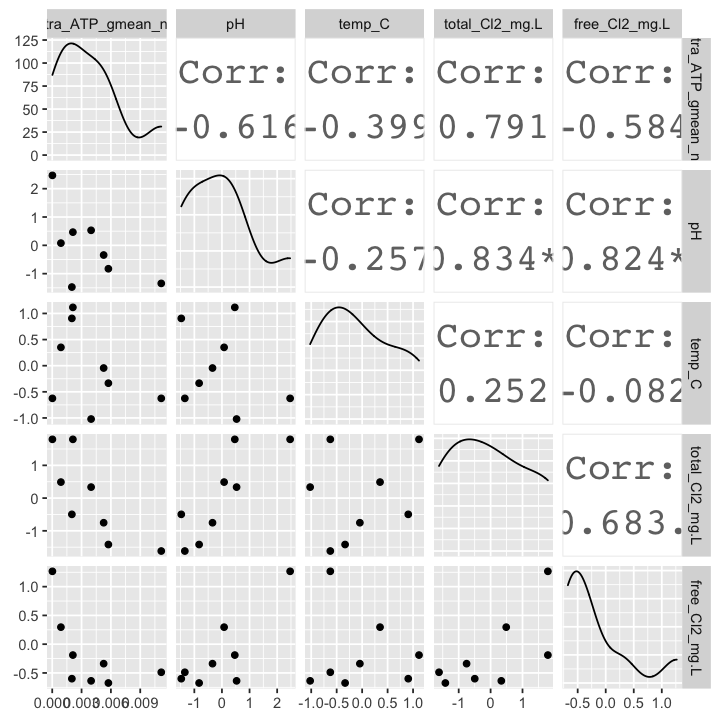

In [34]:
g<-df[df$count== 1,]
g<-g[,col]
 ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

h<-df[df$count==2,]
h<-h[,col]
 ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

i<-df[df$count==3,]
i<-i[,col]
 ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

j<-df[df$count==7,]
j<-j[,col]
 ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )

k<-df[df$count==8,] #includes 2 sites but still correlated
k<-k[,col]
 ggpairs(k, upper = list(continuous = wrap('cor', size = 8) ) )

# l<-df[df$count==19,]
# l<-l[,col]
#  ggpairs(l, upper = list(continuous = wrap('cor', size = 8) ) )







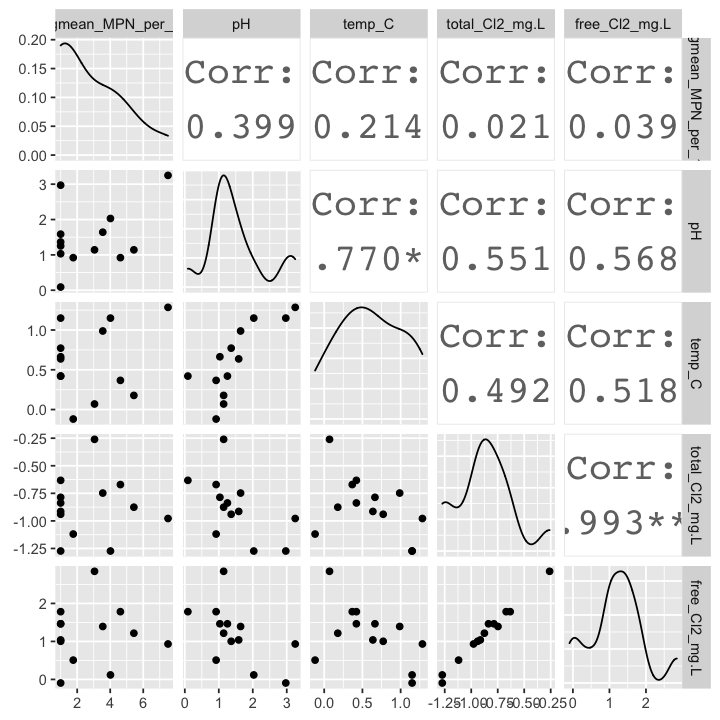

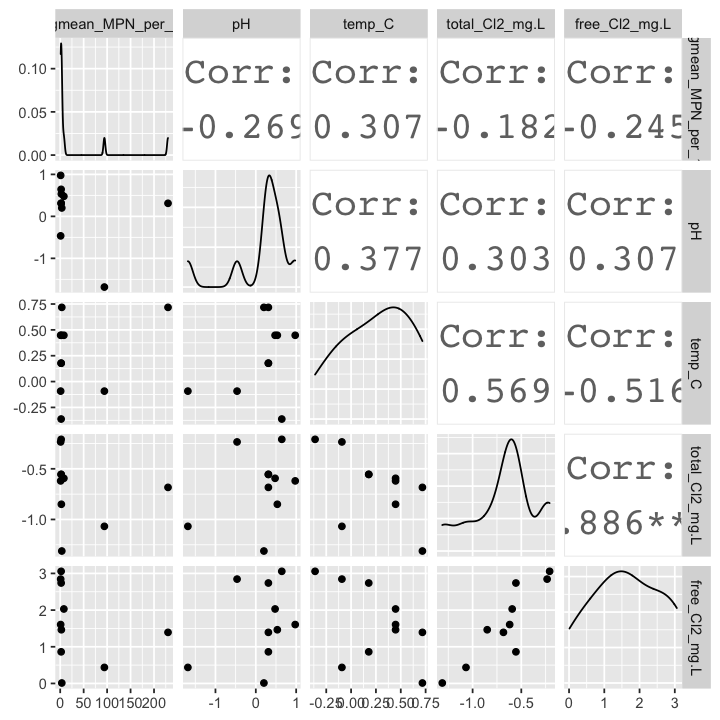

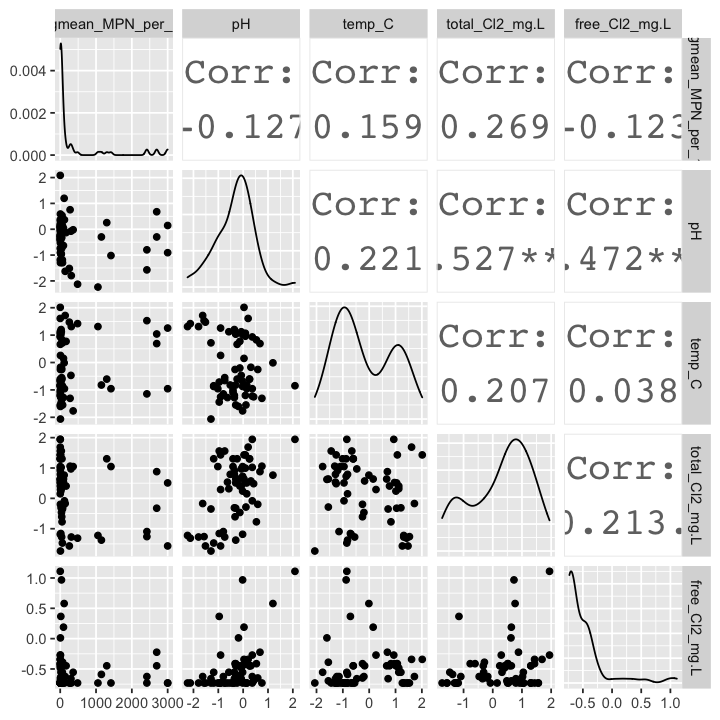

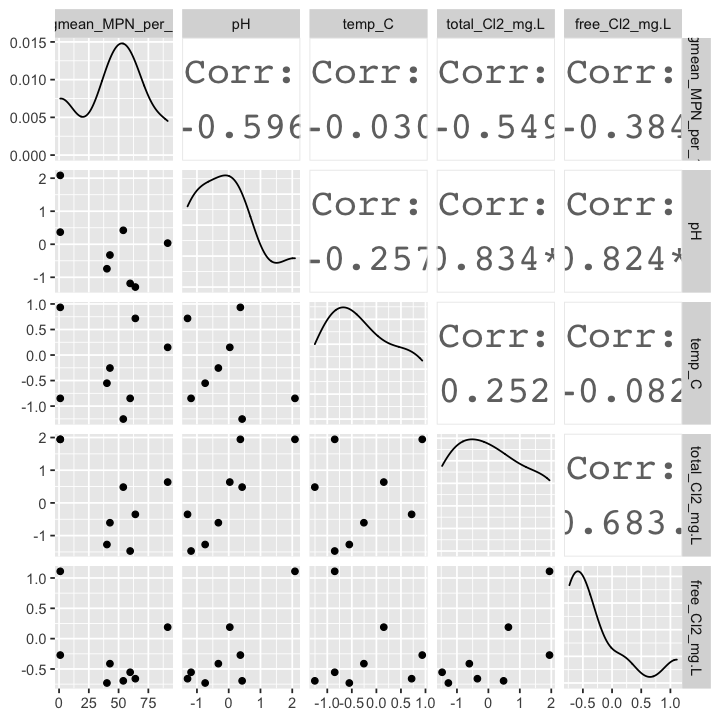

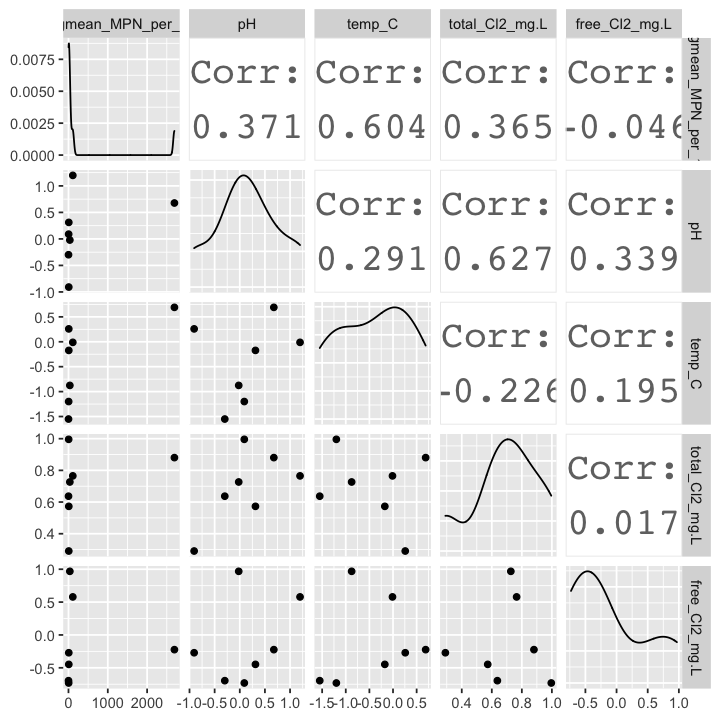

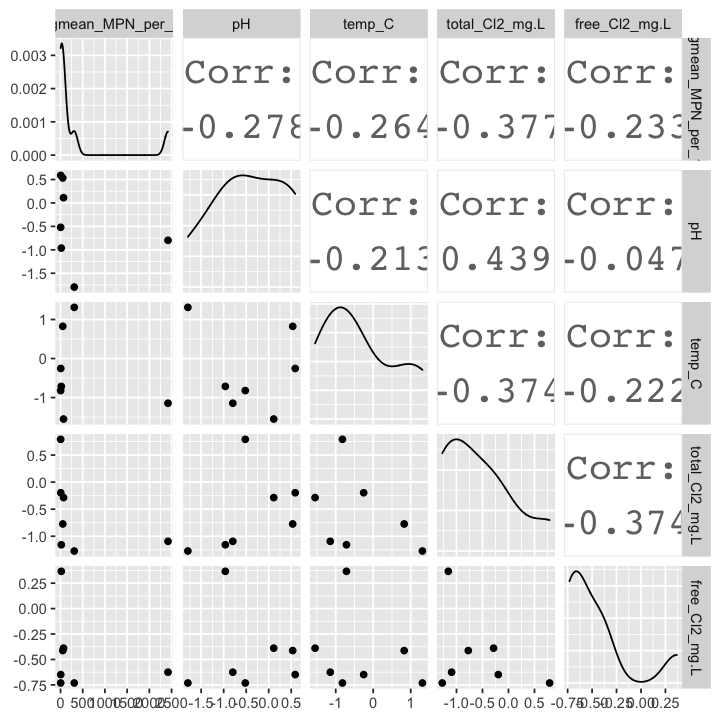

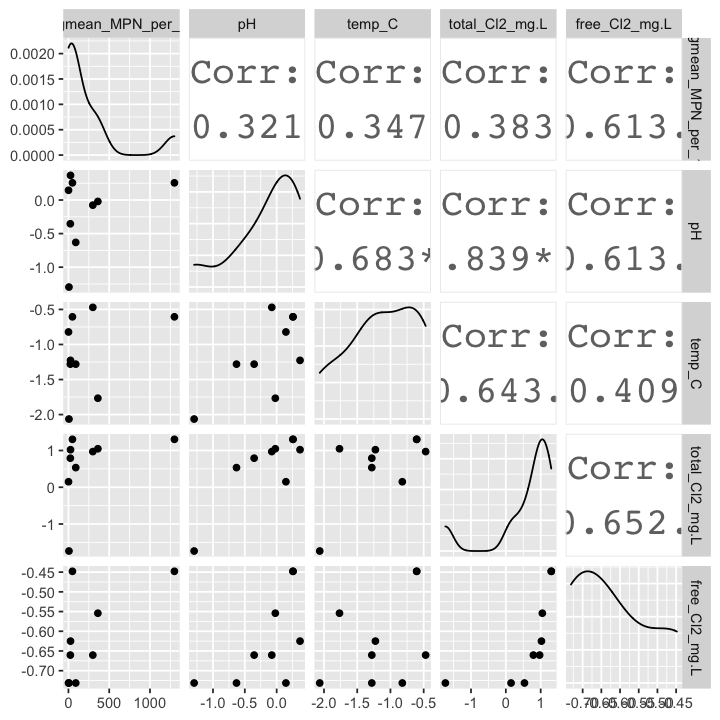

In [35]:
options(repr.plot.width =6, repr.plot.height = 6) #for plotting size in jupyter
df<-raw_HPC
col<-c('HPC_gmean_MPN_per_100mL','pH','temp_C','total_Cl2_mg.L','free_Cl2_mg.L')
a<-df[df$broad_location=="DWDS_A",]
a<-a[,col]
ggpairs(a, upper = list(continuous = wrap('cor', size = 8) ) )

b<-df[df$broad_location=="DWDS_B",]
b<-b[,col]
 ggpairs(b, upper = list(continuous = wrap('cor', size = 8) ) )

f<-df[df$broad_location=="DWDS_F",]
f<-f[,col]
 ggpairs(f, upper = list(continuous = wrap('cor', size = 8) ) )

g<-df[df$location_code=="site_15",]
g<-g[,col]
 ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

h<-df[df$location_code=="site_10",]
h<-h[,col]
 ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

i<-df[df$location_code=="site_24",]
i<-i[,col]
 ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

j<-df[df$location_code=="site_ut",]
j<-j[,col]
 ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )






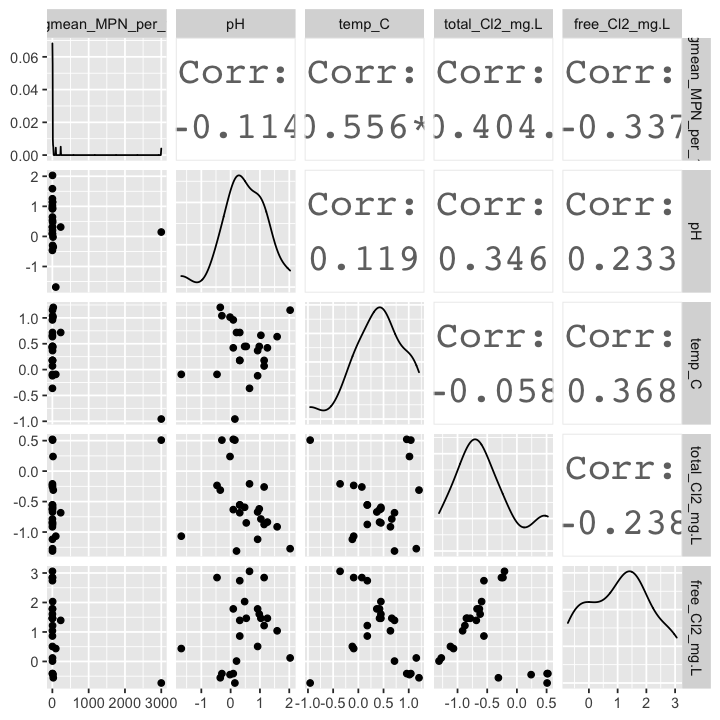

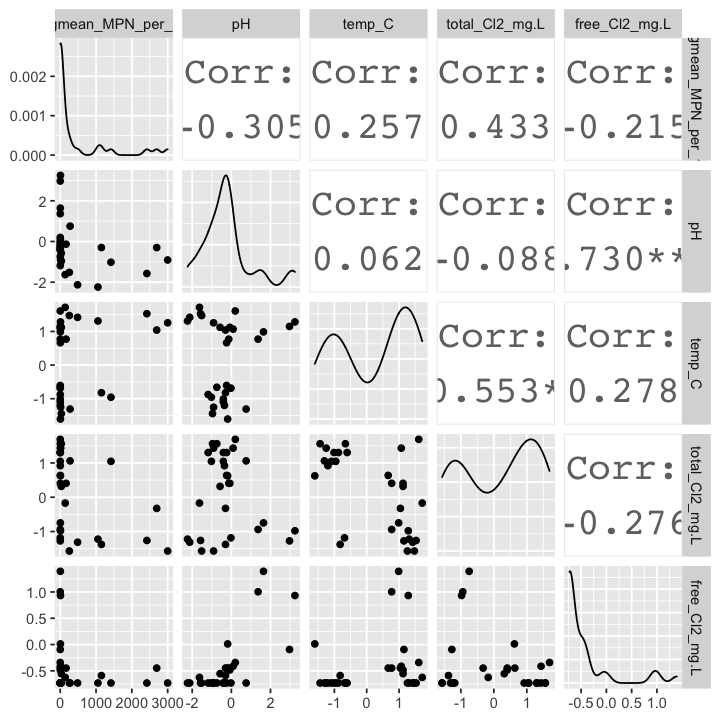

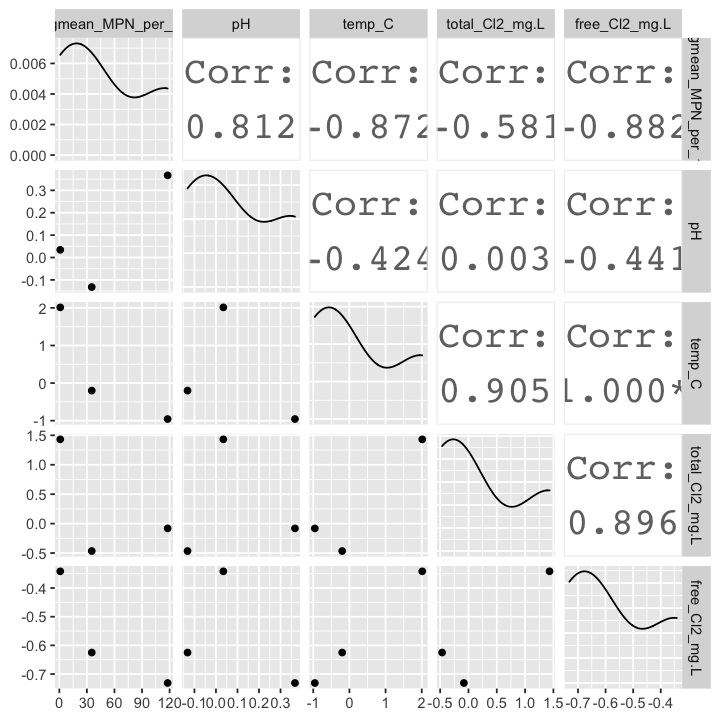

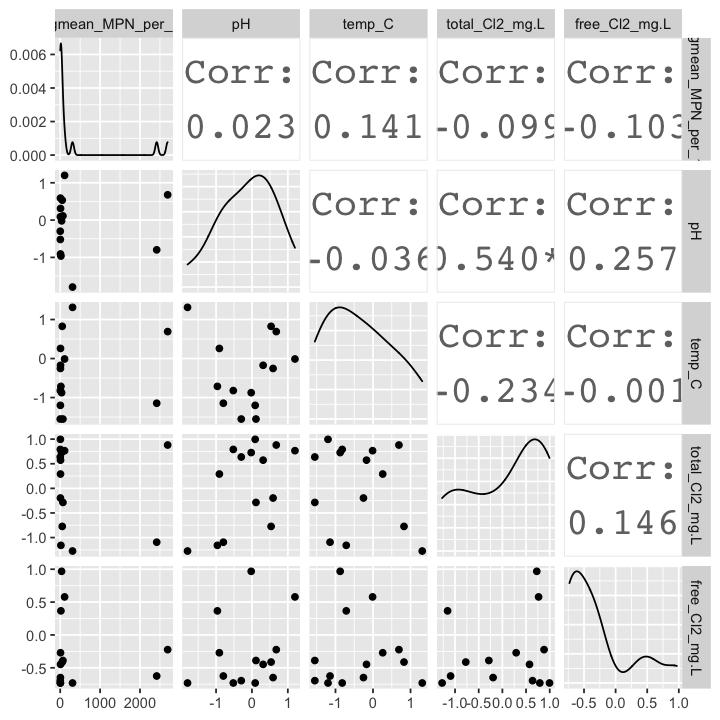

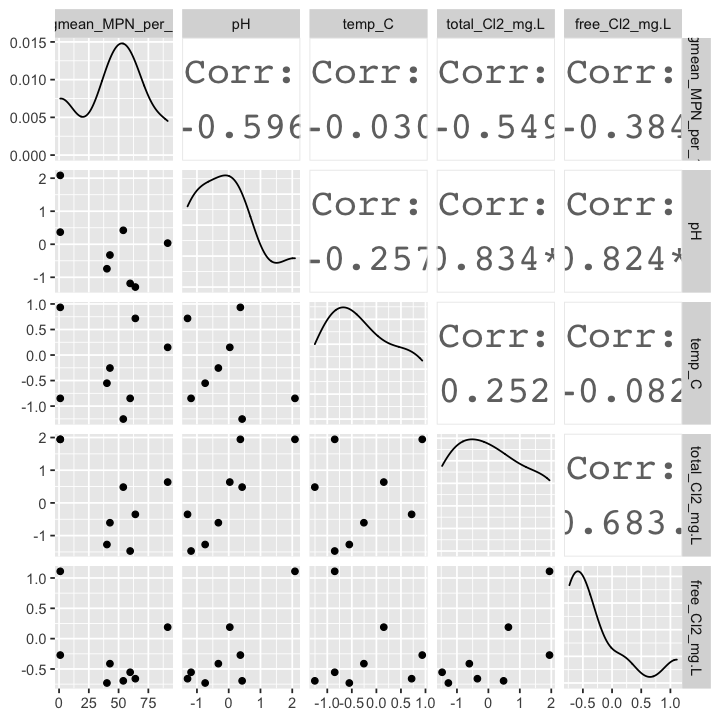

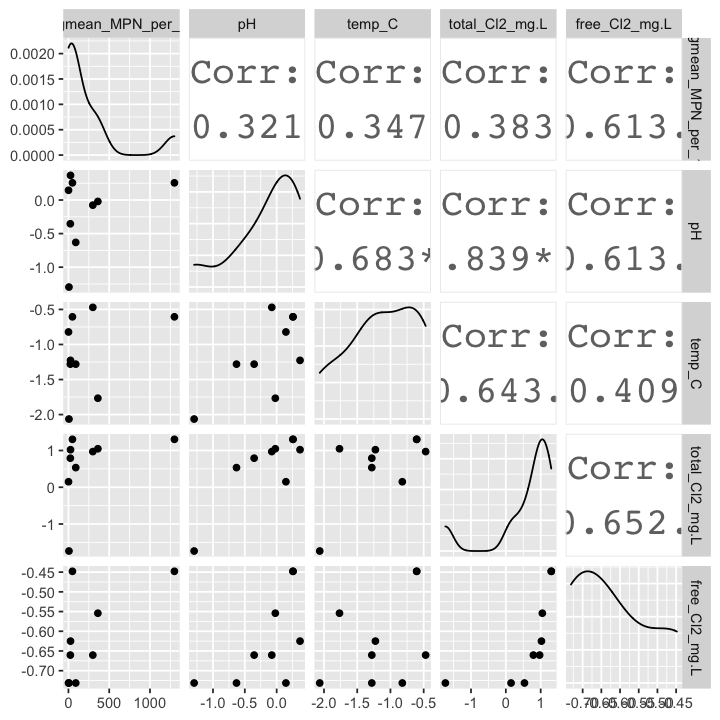

In [36]:
g<-df[df$count== 1,]
g<-g[,col]
 ggpairs(g, upper = list(continuous = wrap('cor', size = 8) ) )

h<-df[df$count==2,]
h<-h[,col]
 ggpairs(h, upper = list(continuous = wrap('cor', size = 8) ) )

i<-df[df$count==3,]
i<-i[,col]
 ggpairs(i, upper = list(continuous = wrap('cor', size = 8) ) )

j<-df[df$count==7,]
j<-j[,col]
 ggpairs(j, upper = list(continuous = wrap('cor', size = 8) ) )

k<-df[df$count==8,] #includes 2 sites but still correlated
k<-k[,col]
 ggpairs(k, upper = list(continuous = wrap('cor', size = 8) ) )

l<-df[df$count==9,]
l<-l[,col]
 ggpairs(l, upper = list(continuous = wrap('cor', size = 8) ) )

### B. Develop Models (Zuur et al. 2013)

In [37]:
#develop functions for later

fix_tab<- function(dfm, sci_lis, dci_lis){
    for (i in sci_lis) {
        dfm[,i]<-unlist(lapply(as.list(dfm[,i]), function (x) if(is.na(x)==FALSE){formatC(x, format='e', digits =2)} else{x=x}))
    }
    for (j in dci_lis) {
        dfm[,j]<-unlist(lapply(as.list(dfm[,j]), function (x) if(is.na(x)==FALSE){formatC(x, digits = 3)} else{x=x}))
    }
    
    return(dfm)
}

 make_stars <- function(pval) {
  stars = ""
  if(!is.na(pval)==TRUE){
      if(pval <= 0.0001)
          stars = "<0.0001"
      if(pval > 0.0001 & pval <= 0.001)
          stars = "<0.001"
      if(pval > 0.001 & pval <= 0.01)
          stars = "<0.01" 
      if(pval > 0.01 & pval <= 0.05)
          stars = "<0.05"
  
  }
  else{
      stars=as.character(pval)
  }
stars
} 

#### Model selection using AIC

##### stepwise model selection

In [38]:
# number of datapoints in the model
length(CAM_ICC$SGPI)

[1] 80

In [39]:
glmm_ICC.1<- glmer(SGPI~total_Cl2_mg.L+free_Cl2_mg.L+pH+temp_C+free_Cl2_mg.L:pH  +total_Cl2_mg.L:pH + free_Cl2_mg.L:temp_C  +total_Cl2_mg.L:temp_C +(1|location_code), data=CAM_ICC, family=Gamma(link="log"))
ss<-getME(glmm_ICC.1,c("theta","fixef"))
glmm_ICC.1<- update(glmm_ICC.1,start=ss)
# summary(glmm_ICC.1)
# allFit(glmm_ICC.1)

In [40]:
#remove free chlorine
glmm_ICC.2a<- update(glmm_ICC.1, ~ . -free_Cl2_mg.L, start=NULL)
ss<-getME(glmm_ICC.2a,c("theta","fixef"))
glmm_ICC.2a<- update(glmm_ICC.2a,start=ss)

# remove temp
glmm_ICC.2b<- update(glmm_ICC.1, ~ . -temp_C, start=NULL)
ss<-getME(glmm_ICC.2b,c("theta","fixef"))
glmm_ICC.2b<- update(glmm_ICC.2b,start=ss)

#remove total:pH
glmm_ICC.2c<- update(glmm_ICC.1, ~ . -total_Cl2_mg.L:pH , start=NULL)
ss<-getME(glmm_ICC.2c,c("theta","fixef"))
glmm_ICC.2c<- update(glmm_ICC.2c,start=ss)

#remove free chlorine:temp
glmm_ICC.2d<- update(glmm_ICC.1, ~ . -free_Cl2_mg.L:temp_C , start=NULL)
ss<-getME(glmm_ICC.2d,c("theta","fixef"))
glmm_ICC.2d<- update(glmm_ICC.2d,start=ss)

#total chlorine:temp
glmm_ICC.2e<- update(glmm_ICC.1, ~ . -total_Cl2_mg.L:temp_C , start=NULL)
ss<-getME(glmm_ICC.2e,c("theta","fixef"))
glmm_ICC.2e<- update(glmm_ICC.2e,start=ss)

#remove free:pH
glmm_ICC.2f<- update(glmm_ICC.1, ~ . -free_Cl2_mg.L:pH , start=NULL)
ss<-getME(glmm_ICC.2f,c("theta","fixef"))
glmm_ICC.2f<- update(glmm_ICC.2f,start=ss)

#remove pH
glmm_ICC.2g<- update(glmm_ICC.1, ~ . -pH , start=NULL)
ss<-getME(glmm_ICC.2g,c("theta","fixef"))
glmm_ICC.2g<- update(glmm_ICC.2g,start=ss)


sel_t1=model.sel(glmm_ICC.1,glmm_ICC.2a,glmm_ICC.2b,glmm_ICC.2c,glmm_ICC.2d,glmm_ICC.2e,glmm_ICC.2f,glmm_ICC.2g)
# summary(glmm_ICC.2c)

In [41]:
#remove free chlorine
glmm_ICC.3a<- update(glmm_ICC.2c, ~ . -free_Cl2_mg.L , start=NULL)
ss<-getME(glmm_ICC.3a,c("theta","fixef"))
glmm_ICC.3a<- update(glmm_ICC.3a,start=ss)

# remove temp
glmm_ICC.3b<- update(glmm_ICC.2c, ~ . -temp_C , start=NULL)
ss<-getME(glmm_ICC.3b,c("theta","fixef"))
glmm_ICC.3b<- update(glmm_ICC.3b,start=ss)

# remove free:temp
glmm_ICC.3c<- update(glmm_ICC.2c, ~ . -free_Cl2_mg.L:temp_C , start=NULL)
ss<-getME(glmm_ICC.3c,c("theta","fixef"))
glmm_ICC.3c<- update(glmm_ICC.3c,start=ss)

# remove total:temp
glmm_ICC.3d<- update(glmm_ICC.2c, ~ . -total_Cl2_mg.L:temp_C , start=NULL)
ss<-getME(glmm_ICC.3d,c("theta","fixef"))
glmm_ICC.3d<- update(glmm_ICC.3d,start=ss)

# remove free:pH
glmm_ICC.3e<- update(glmm_ICC.2c, ~ . -free_Cl2_mg.L:pH , start=NULL)
ss<-getME(glmm_ICC.3e,c("theta","fixef"))
glmm_ICC.3e<- update(glmm_ICC.3e,start=ss)

# remove total:pH
glmm_ICC.3f<- update(glmm_ICC.2c, ~ . -total_Cl2_mg.L:pH , start=NULL)
ss<-getME(glmm_ICC.3f,c("theta","fixef"))
glmm_ICC.3f<- update(glmm_ICC.3f,start=ss)

# remove pH
glmm_ICC.3g<- update(glmm_ICC.2c, ~ . -pH , start=NULL)
ss<-getME(glmm_ICC.3g,c("theta","fixef"))
glmm_ICC.3g<- update(glmm_ICC.3g,start=ss)



sel_t2=model.sel(glmm_ICC.2c,glmm_ICC.3a,glmm_ICC.3b,glmm_ICC.3c,glmm_ICC.3d,glmm_ICC.3e,glmm_ICC.3f,glmm_ICC.3g)
# summary(glmm_ICC.3c)

In [42]:
#remove free chlorine
glmm_ICC.4a<- update(glmm_ICC.3c, ~ . -free_Cl2_mg.L, start=NULL)
ss<-getME(glmm_ICC.4a,c("theta","fixef"))
glmm_ICC.4a<- update(glmm_ICC.4a,start=ss)

# remove temp
glmm_ICC.4b<- update(glmm_ICC.3c, ~ . -temp_C, start=NULL)
ss<-getME(glmm_ICC.4b,c("theta","fixef"))
glmm_ICC.4b<- update(glmm_ICC.4b,start=ss)

# remove total:temp
glmm_ICC.4c<- update(glmm_ICC.3c, ~ . -total_Cl2_mg.L:temp_C, start=NULL)
ss<-getME(glmm_ICC.4c,c("theta","fixef"))
glmm_ICC.4c<- update(glmm_ICC.4c,start=ss)

# remove free:pH
glmm_ICC.4d<- update(glmm_ICC.3c, ~ . -free_Cl2_mg.L:pH, start=NULL)
ss<-getME(glmm_ICC.4d,c("theta","fixef"))
glmm_ICC.4d<- update(glmm_ICC.4d,start=ss)

# remove total:pH
glmm_ICC.4e<- update(glmm_ICC.3c, ~ . -total_Cl2_mg.L:pH, start=NULL)
ss<-getME(glmm_ICC.4e,c("theta","fixef"))
glmm_ICC.4e<- update(glmm_ICC.4e,start=ss)

# remove pH
glmm_ICC.4f<- update(glmm_ICC.3f, ~ . -pH, start=NULL)
ss<-getME(glmm_ICC.4f,c("theta","fixef"))
glmm_ICC.4f<- update(glmm_ICC.4f,start=ss)

sel_t3=model.sel(glmm_ICC.3c,glmm_ICC.4a,glmm_ICC.4b,glmm_ICC.4c,glmm_ICC.4d,glmm_ICC.4e,glmm_ICC.4f)
# summary(glmm_ICC.4a)

In [43]:
# check by removing next term
glmm_ICC.5<- update(glmm_ICC.3c, ~ . -free_Cl2_mg.L:pH, start=NULL)
ss<-getME(glmm_ICC.5,c("theta","fixef"))
glmm_ICC.5<- update(glmm_ICC.5,start=ss)

sel_t4=model.sel(glmm_ICC.4a,glmm_ICC.5)
# summary(glmm_ICC.4a)

## Table S3

##### Final model output

In [44]:
table_fin=rbind(sel_t1,sel_t2,sel_t3,sel_t4)
table_fin 

stargazer(table_fin,type="html", summary=FALSE,  out=paste(path_tab,"Table_S3.doc"))
summary(glmm_ICC.2c)
summary(glmm_ICC.3c)
summary(glmm_ICC.4a)

(Intercept) free_Cl2_mg.L pH        temp_C     total_Cl2_mg.L
glmm_ICC.4a  8.634886              NA  0.3978666 0.34530163 -1.310262     
glmm_ICC.4a1 8.634886              NA  0.3978666 0.34530163 -1.310262     
glmm_ICC.3c  8.460388    -0.397228282  0.5242192 0.35741346 -1.302844     
glmm_ICC.3c1 8.460388    -0.397228282  0.5242192 0.35741346 -1.302844     
glmm_ICC.4e  8.460388    -0.397228282  0.5242192 0.35741346 -1.302844     
glmm_ICC.3b  8.244307    -0.868041059  0.5655500         NA -1.225143     
glmm_ICC.4c  8.467650    -0.508532806  0.5203894 0.30145193 -1.329605     
glmm_ICC.3a  8.636443              NA  0.4177871 0.40217811 -1.322224     
glmm_ICC.3d  8.287585    -0.863421217  0.5584155 0.05364703 -1.257774     
glmm_ICC.2c  8.342619    -0.648384125  0.5484776 0.19376017 -1.261160     
glmm_ICC.2c1 8.342619    -0.648384125  0.5484776 0.19376017 -1.261160     
glmm_ICC.3f  8.342619    -0.648384125  0.5484776 0.19376017 -1.261160     
glmm_ICC.4d  8.705280    -0.002713199  0.3377636 0.38791869 -1.298339     
glmm_ICC.5   8.705280    -0.002713199  0.3377636 0.38791869 -1.298339     
glmm_ICC.2d  8.433819    -0.400490617  0.4802220 0.32938549 -1.260422     
glmm_ICC.2b  8.242876    -0.854191074  0.5499711         NA -1.213378     
glmm_ICC.2a  8.606293              NA  0.3693416 0.39053566 -1.275764     
glmm_ICC.2e  8.287976    -0.836055972  0.5332802 0.05959847 -1.241108     
glmm_ICC.3e  8.620837    -0.192438622  0.3482131 0.25659834 -1.269300     
glmm_ICC.1   8.343099    -0.619998192  0.5231414 0.19911997 -1.243844     
glmm_ICC.2f  8.511057    -0.239277345  0.2957379 0.26793466 -1.182219     
glmm_ICC.3g  8.513812     0.017928886         NA 0.23390813 -1.135292     
glmm_ICC.4f  8.513812     0.017928886         NA 0.23390813 -1.135292     
glmm_ICC.2g  8.481886     0.014222615         NA 0.26923075 -1.086753     
glmm_ICC.4b  8.521356    -0.331218730  0.4017245         NA -1.339975     
             free_Cl2_mg.L:pH free_Cl2_mg.L:temp_C pH:total_Cl2_mg.L
glmm_ICC.4a  0.38531110                NA                  NA       
glmm_ICC.4a1 0.38531110                NA                  NA       
glmm_ICC.3c  0.53448200                NA                  NA       
glmm_ICC.3c1 0.53448200                NA                  NA       
glmm_ICC.4e  0.53448200                NA                  NA       
glmm_ICC.3b  0.58899226       -0.70269381                  NA       
glmm_ICC.4c  0.74107867                NA                  NA       
glmm_ICC.3a  0.41215593        0.11634255                  NA       
glmm_ICC.3d  0.70832700       -0.56582696                  NA       
glmm_ICC.2c  0.55252714       -0.35539985                  NA       
glmm_ICC.2c1 0.55252714       -0.35539985                  NA       
glmm_ICC.3f  0.55252714       -0.35539985                  NA       
glmm_ICC.4d          NA                NA                  NA       
glmm_ICC.5           NA                NA                  NA       
glmm_ICC.2d  0.45809049                NA          0.07779796       
glmm_ICC.2b  0.56299380       -0.68050655          0.02700381       
glmm_ICC.2a  0.32845422        0.16424786          0.09458522       
glmm_ICC.2e  0.66659376       -0.52162152          0.04118931       
glmm_ICC.3e          NA       -0.28226397                  NA       
glmm_ICC.1   0.51075561       -0.31184088          0.04133796       
glmm_ICC.2f          NA       -0.07646571          0.20543950       
glmm_ICC.3g  0.23505719       -0.16815889                  NA       
glmm_ICC.4f  0.23505719       -0.16815889                  NA       
glmm_ICC.2g  0.07866843        0.05585375          0.22872410       
glmm_ICC.4b  0.72697282                NA                  NA       
             temp_C:total_Cl2_mg.L df logLik    AICc     delta     weight      
glmm_ICC.4a  -0.23737433            8 -754.1752 1526.379  0.000000 0.1410344288
glmm_ICC.4a1 -0.23737433            8 -754.1752 1526.379  0.000000 0.1410344288
glmm_ICC.3c  -0.21379192     


<table style="text-align:center"><tr><td colspan="15" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>(Intercept)</td><td>free_Cl2_mg.L</td><td>pH</td><td>temp_C</td><td>total_Cl2_mg.L</td><td>free_Cl2_mg.L:pH</td><td>free_Cl2_mg.L:temp_C</td><td>pH:total_Cl2_mg.L</td><td>temp_C:total_Cl2_mg.L</td><td>df</td><td>logLik</td><td>AICc</td><td>delta</td><td>weight</td></tr>
<tr><td colspan="15" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">glmm_ICC.4a</td><td>8.635</td><td></td><td>0.398</td><td>0.345</td><td>-1.310</td><td>0.385</td><td></td><td></td><td>-0.237</td><td>8</td><td>-754.175</td><td>1,526.379</td><td>0</td><td>0.141</td></tr>
<tr><td style="text-align:left">glmm_ICC.4a1</td><td>8.635</td><td></td><td>0.398</td><td>0.345</td><td>-1.310</td><td>0.385</td><td></td><td></td><td>-0.237</td><td>8</td><td>-754.175</td><td>1,526.379</td><td>0</td><td>0.141</td></tr>
<tr><td style="text-align:left">glmm_ICC.

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: 
SGPI ~ total_Cl2_mg.L + free_Cl2_mg.L + pH + temp_C + (1 | location_code) +  
    free_Cl2_mg.L:pH + free_Cl2_mg.L:temp_C + total_Cl2_mg.L:temp_C
   Data: CAM_ICC

     AIC      BIC   logLik deviance df.resid 
  1526.3   1550.1   -753.2   1506.3       70 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2730 -0.7054 -0.1998  0.4558  3.2482 

Random effects:
 Groups        Name        Variance Std.Dev.
 location_code (Intercept) 0.2380   0.4879  
 Residual                  0.5875   0.7665  
Number of obs: 80, groups:  location_code, 24

Fixed effects:
                      Estimate Std. Error t value Pr(>|z|)    
(Intercept)             8.3426     0.2755  30.283  < 2e-16 ***
total_Cl2_mg.L         -1.2612     0.1418  -8.893  < 2e-16 ***
free_Cl2_mg.L          -0.6484     0.4503  -1.440  0.14990    
pH                      0.5485     0.2009   2.73

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: 
SGPI ~ total_Cl2_mg.L + free_Cl2_mg.L + pH + temp_C + (1 | location_code) +  
    free_Cl2_mg.L:pH + total_Cl2_mg.L:temp_C
   Data: CAM_ICC

     AIC      BIC   logLik deviance df.resid 
  1524.9   1546.3   -753.4   1506.9       71 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2767 -0.7013 -0.1678  0.4620  3.3463 

Random effects:
 Groups        Name        Variance Std.Dev.
 location_code (Intercept) 0.2283   0.4778  
 Residual                  0.5865   0.7658  
Number of obs: 80, groups:  location_code, 24

Fixed effects:
                      Estimate Std. Error t value Pr(>|z|)    
(Intercept)            8.46039    0.23068  36.676  < 2e-16 ***
total_Cl2_mg.L        -1.30284    0.13225  -9.851  < 2e-16 ***
free_Cl2_mg.L         -0.39723    0.31625  -1.256 0.209100    
pH                     0.52422    0.19786   2.649 0.008062 ** 
temp_C  

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: 
SGPI ~ total_Cl2_mg.L + pH + temp_C + (1 | location_code) + free_Cl2_mg.L:pH +  
    total_Cl2_mg.L:temp_C
   Data: CAM_ICC

     AIC      BIC   logLik deviance df.resid 
  1524.4   1543.4   -754.2   1508.4       72 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2783 -0.6711 -0.1629  0.4668  3.2411 

Random effects:
 Groups        Name        Variance Std.Dev.
 location_code (Intercept) 0.2608   0.5107  
 Residual                  0.5822   0.7630  
Number of obs: 80, groups:  location_code, 24

Fixed effects:
                      Estimate Std. Error t value Pr(>|z|)    
(Intercept)            8.63489    0.19228  44.909  < 2e-16 ***
total_Cl2_mg.L        -1.31026    0.13233  -9.902  < 2e-16 ***
pH                     0.39787    0.17138   2.322 0.020259 *  
temp_C                 0.34530    0.09709   3.557 0.000376 ***
pH:free_Cl2_mg.L       0

In [45]:
glmm_ICC<-glmm_ICC.4a
summary(glmm_ICC)
getME(glmm_ICC,"sigma")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: 
SGPI ~ total_Cl2_mg.L + pH + temp_C + (1 | location_code) + free_Cl2_mg.L:pH +  
    total_Cl2_mg.L:temp_C
   Data: CAM_ICC

     AIC      BIC   logLik deviance df.resid 
  1524.4   1543.4   -754.2   1508.4       72 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2783 -0.6711 -0.1629  0.4668  3.2411 

Random effects:
 Groups        Name        Variance Std.Dev.
 location_code (Intercept) 0.2608   0.5107  
 Residual                  0.5822   0.7630  
Number of obs: 80, groups:  location_code, 24

Fixed effects:
                      Estimate Std. Error t value Pr(>|z|)    
(Intercept)            8.63489    0.19228  44.909  < 2e-16 ***
total_Cl2_mg.L        -1.31026    0.13233  -9.902  < 2e-16 ***
pH                     0.39787    0.17138   2.322 0.020259 *  
temp_C                 0.34530    0.09709   3.557 0.000376 ***
pH:free_Cl2_mg.L       0

[1] 0.7630079

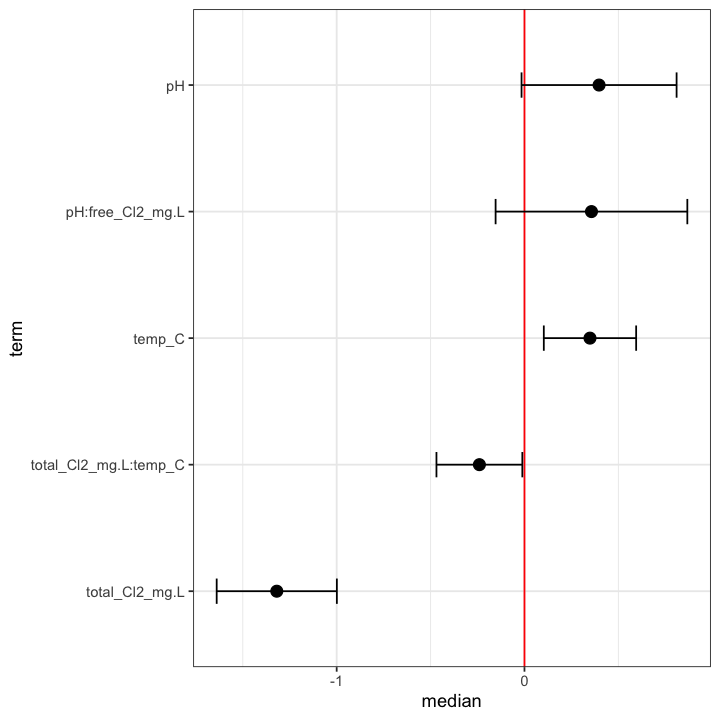

In [46]:
#following this guide https://cran.r-project.org/web/packages/merTools/vignettes/merToolsIntro.html
fe<-FEsim(glmm_ICC,1000, seed=30)
plotFEsim(fe, level=0.95)+
  theme_bw() 


most fixed effects are different than 0 except pH:total chlorine

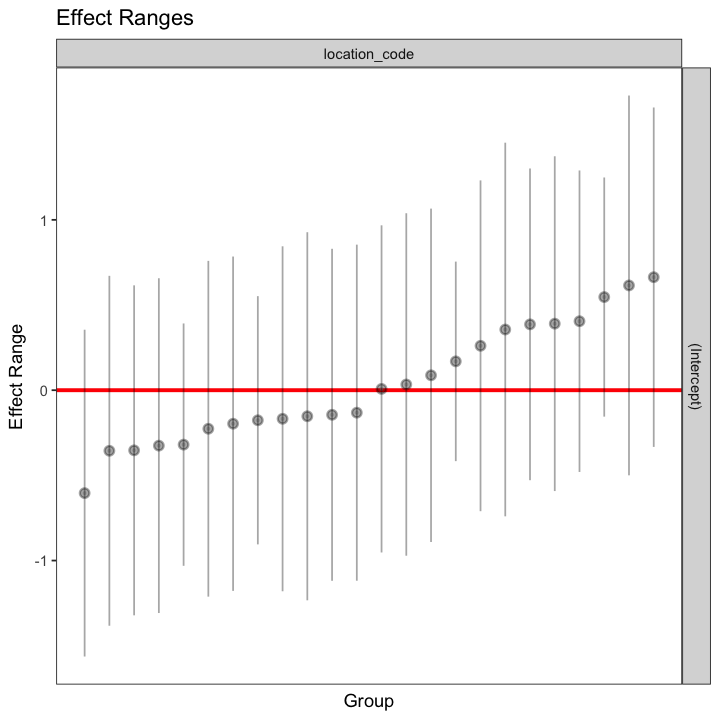

In [47]:
re<-REsim(glmm_ICC, 1000, seed=30)
plotREsim(re,level=0.95)

random effects were indistinguishable from 0 for all sites

## Table 2

###### model summary

In [48]:
#get info
allv.itdf<- tidy(glmm_ICC, effects = c("ran_pars","fixed"), scales = c("vcov",NA)) %>% mutate(signif = sapply(p.value, function(x) make_stars(x)))    
wald_ci<-as.data.frame(confint(glmm_ICC, method="Wald") )
wald_ci$term<- as.list(rownames(wald_ci))       
rownames(wald_ci)<-c()
wald_ci$term<-gsub( ".sig01", "var__(Intercept)",wald_ci$term) 
wald_ci$term<-gsub(".sigma", "var__Observation",wald_ci$term)  
                                                                                                             
allv.itdf<-left_join(allv.itdf,wald_ci)                                                                                                                                                                           
allv.itdf
                                                                                                              
                                                                                                             

allv_tdf<-allv.itdf[c("term","estimate","std.error","p.value","signif", "2.5 %", "97.5 %")]
colnames(allv_tdf)<-c( "parameter", "estimate", "std.error", "p.value","signif", "2.5", "97.5")
allv_tdf<-fix_tab(allv_tdf,NULL, c("estimate","97.5","2.5","std.error","p.value"))
allv_tdf$parameter<-gsub("_", " ", allv_tdf$parameter)
allv_tdf$parameter<-gsub("Cl2", "chlorine", allv_tdf$parameter)
allv_tdf$parameter<-gsub("mg.L", "", allv_tdf$parameter)
allv_tdf$parameter<-gsub("(Intercept)", "intercept", allv_tdf$parameter)
allv_tdf$parameter<-gsub("(intercept)", "intercept", allv_tdf$parameter)
allv_tdf$parameter<-gsub("sd", "standard deviation of the", allv_tdf$parameter)

allv_tdf                                                                                                                                                                                                       
stargazer(allv_tdf ,type="html", summary=FALSE,  out=paste(path_tab,"Table_2.doc"))                                                                                                           


Joining, by = "term"



effect   group         term                  estimate   std.error  statistic
1 fixed    NA            (Intercept)            8.6348860 0.19227716 44.908536
2 fixed    NA            total_Cl2_mg.L        -1.3102620 0.13232694 -9.901703
3 fixed    NA            pH                     0.3978666 0.17138239  2.321514
4 fixed    NA            temp_C                 0.3453016 0.09708671  3.556631
5 fixed    NA            pH:free_Cl2_mg.L       0.3853111 0.23019439  1.673851
6 fixed    NA            total_Cl2_mg.L:temp_C -0.2373743 0.11665247 -2.034885
7 ran_pars location_code var__(Intercept)       0.2607637         NA        NA
8 ran_pars Residual      var__Observation       0.5821811         NA        NA
  p.value      signif  2.5 %       97.5 %      
1 0.000000e+00 <0.0001  8.25802967  9.011742297
2 4.092477e-23 <0.0001 -1.56961802 -1.050905954
3 2.025913e-02 <0.05    0.06196328  0.733769894
4 3.756409e-04 <0.001   0.15501517  0.535588085
5 9.415989e-02         -0.06586160  0.836483813
6 4.186247e-02 <0.05   -0.46600898 -0.008739691
7           NA NA               NA           NA
8           NA NA               NA           NA

parameter              estimate std.error p.value  signif  2.5     97.5    
1 (intercept)            8.63     0.192        0     <0.0001 8.26    9.01    
2 total chlorine         -1.31    0.132     4.09e-23 <0.0001 -1.57   -1.05   
3 pH                     0.398    0.171     0.0203   <0.05   0.062   0.734   
4 temp C                 0.345    0.0971    0.000376 <0.001  0.155   0.536   
5 pH:free chlorine       0.385    0.23      0.0942           -0.0659 0.836   
6 total chlorine :temp C -0.237   0.117     0.0419   <0.05   -0.466  -0.00874
7 var  (intercept)       0.261      NA        NA     NA        NA      NA    
8 var  Observation       0.582      NA        NA     NA        NA      NA


<table style="text-align:center"><tr><td colspan="8" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>parameter</td><td>estimate</td><td>std.error</td><td>p.value</td><td>signif</td><td>2.5</td><td>97.5</td></tr>
<tr><td colspan="8" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>(intercept)</td><td>8.63</td><td>0.192</td><td>0</td><td>< 0.0001</td><td>8.26</td><td>9.01</td></tr>
<tr><td style="text-align:left">2</td><td>total chlorine</td><td>-1.31</td><td>0.132</td><td>4.09e-23</td><td>< 0.0001</td><td>-1.57</td><td>-1.05</td></tr>
<tr><td style="text-align:left">3</td><td>pH</td><td>0.398</td><td>0.171</td><td>0.0203</td><td>< 0.05</td><td>0.062</td><td>0.734</td></tr>
<tr><td style="text-align:left">4</td><td>temp C</td><td>0.345</td><td>0.0971</td><td>0.000376</td><td>< 0.001</td><td>0.155</td><td>0.536</td></tr>
<tr><td style="text-align:left">5</td><td>pH:free chlorine</td><td>0.385</td><td>0.23

### C. Model validation (Zuur 2015)

$location_code


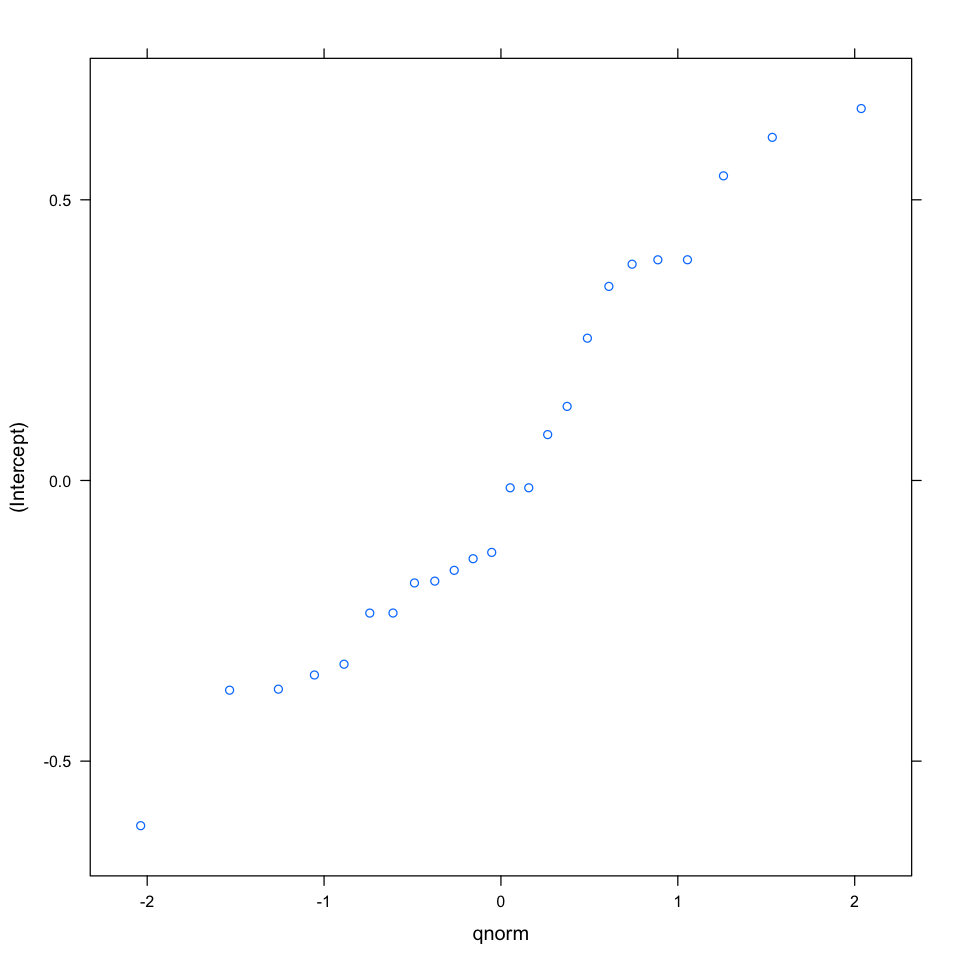

In [49]:
options(repr.plot.width =8, repr.plot.height = 8) #for plotting size in jupyter
plot(ranef(glmm_ICC))

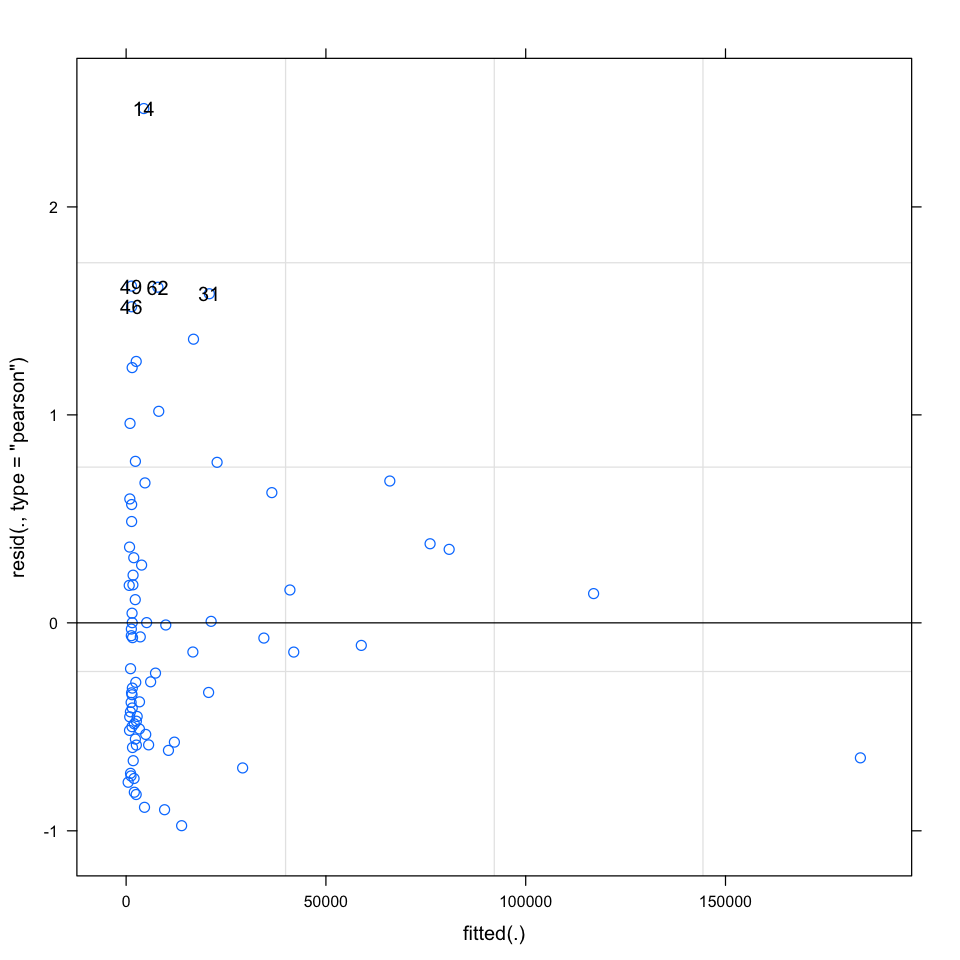

In [50]:
options(repr.plot.width =8, repr.plot.height = 8) #for plotting size in jupyter
plot(glmm_ICC,id=0.05,idLabels=~.obs)

This plot looks similar to Zuur (A beginner's guide to glmm in R) pg 194 figure 6.14A (but more sparse)

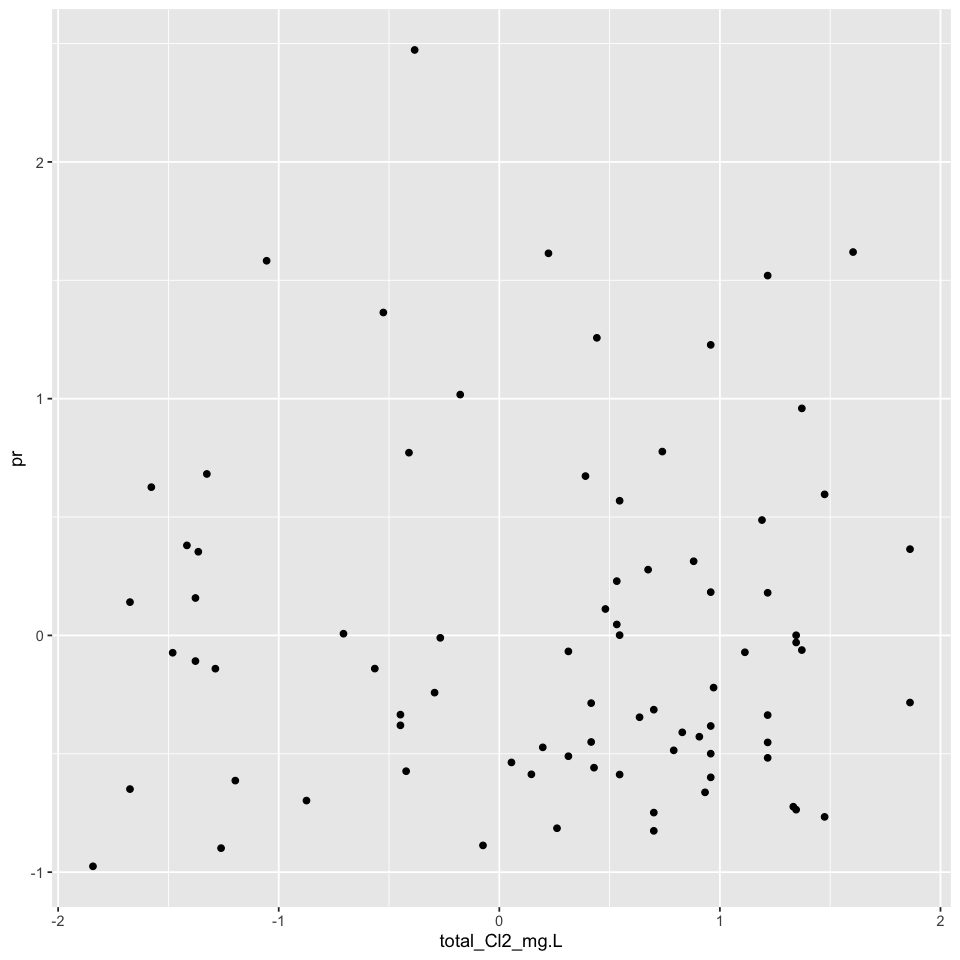

In [51]:
pr<-residuals(glmm_ICC, "pearson")

ggplot(data=CAM_ICC,aes( x=total_Cl2_mg.L,y=pr) )+geom_point()

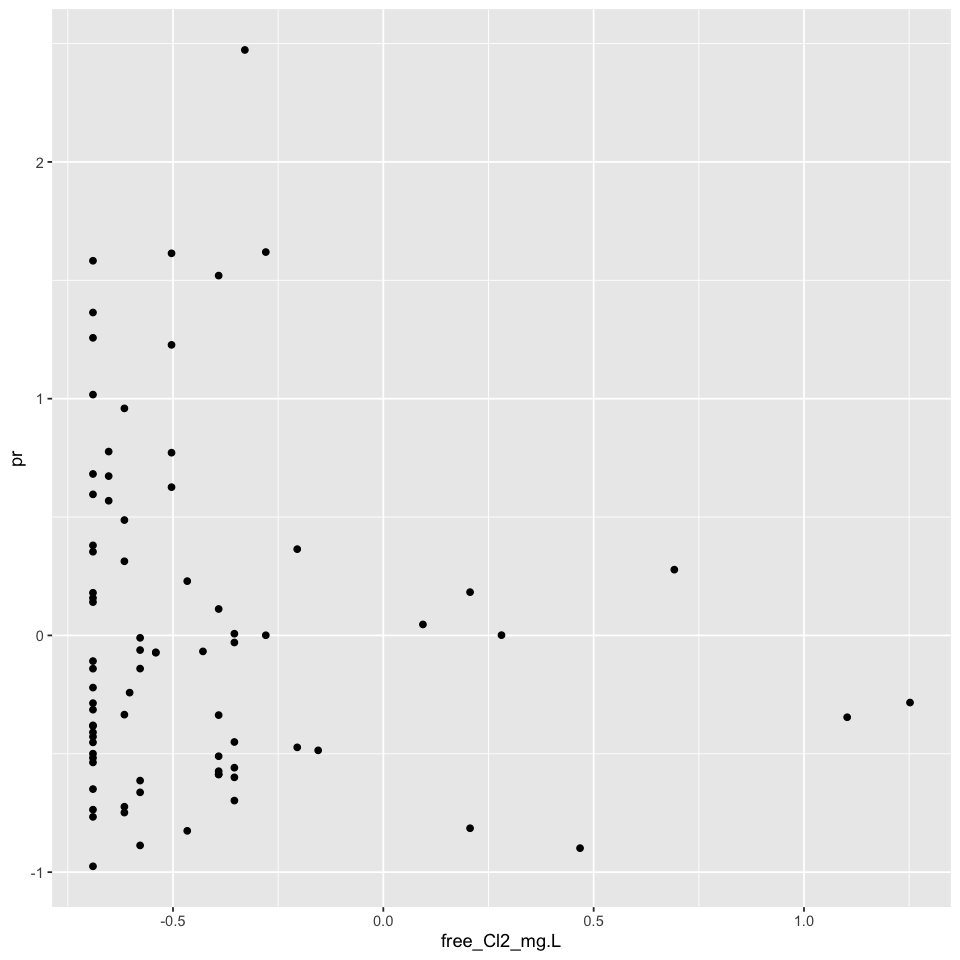

In [52]:
# total_Cl2_mg.L+free_Cl2_mg.L+pH+temp_C+free_Cl2_mg.L:pH  +total_Cl2_mg.L:pH + free_Cl2_mg.L:temp_C  +total_Cl2_mg.L:temp_C

ggplot(data=CAM_ICC,aes( x=free_Cl2_mg.L,y=pr) )+geom_point()

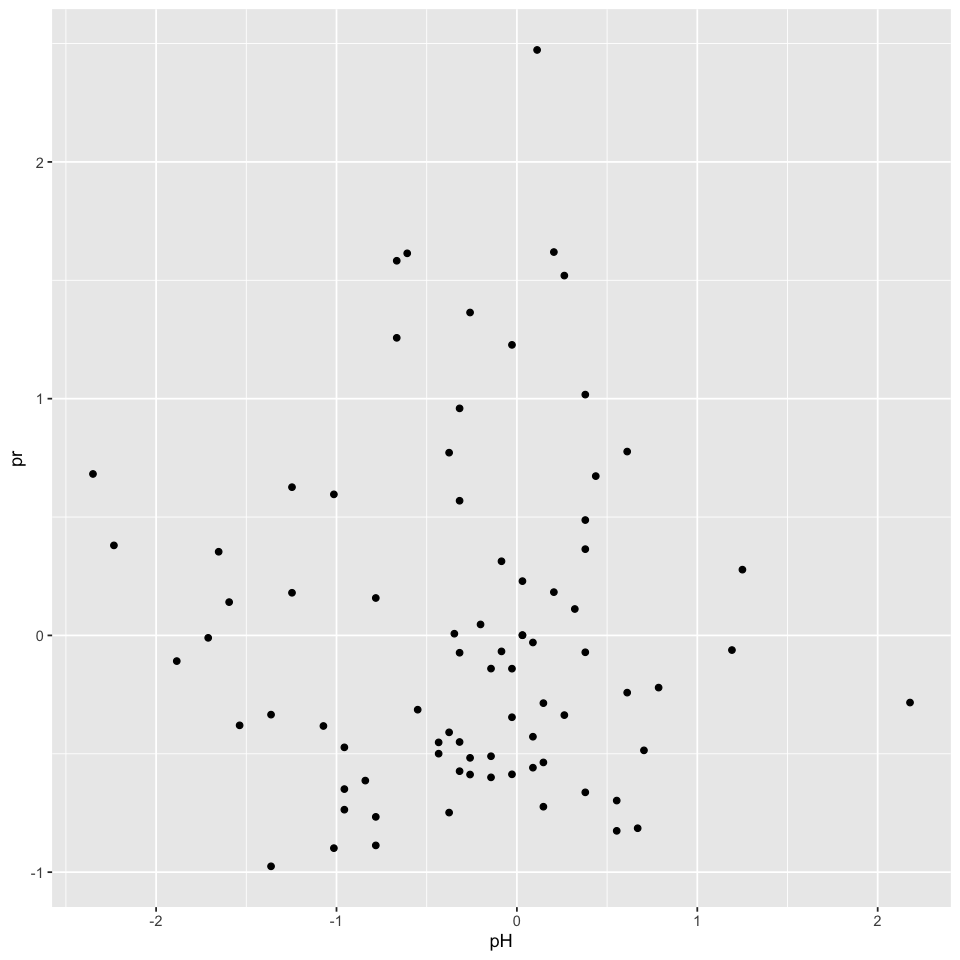

In [53]:
# total_Cl2_mg.L+free_Cl2_mg.L+pH+temp_C+free_Cl2_mg.L:pH  +total_Cl2_mg.L:pH + free_Cl2_mg.L:temp_C  +total_Cl2_mg.L:temp_C

ggplot(data=CAM_ICC,aes( x=pH,y=pr) )+geom_point()

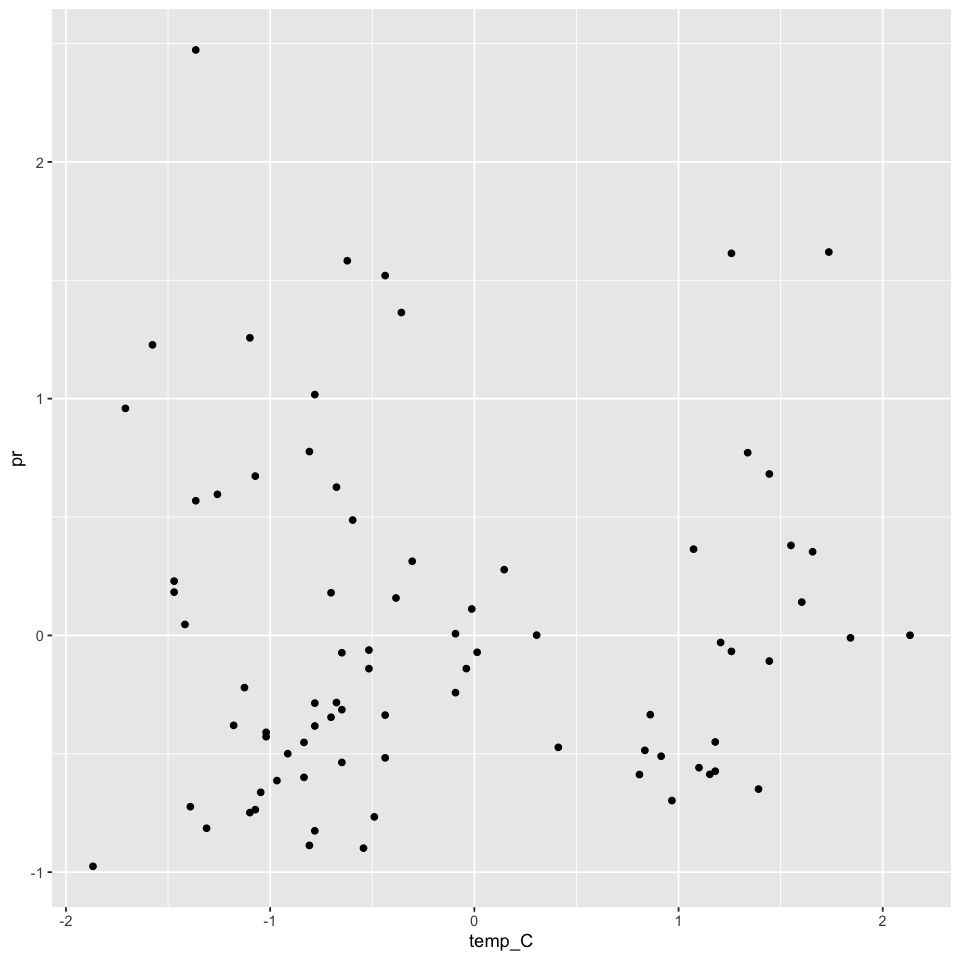

In [54]:
# total_Cl2_mg.L+free_Cl2_mg.L+pH+temp_C+free_Cl2_mg.L:pH  +total_Cl2_mg.L:pH + free_Cl2_mg.L:temp_C  +total_Cl2_mg.L:temp_C

ggplot(data=CAM_ICC,aes( x=temp_C,y=pr) )+geom_point()

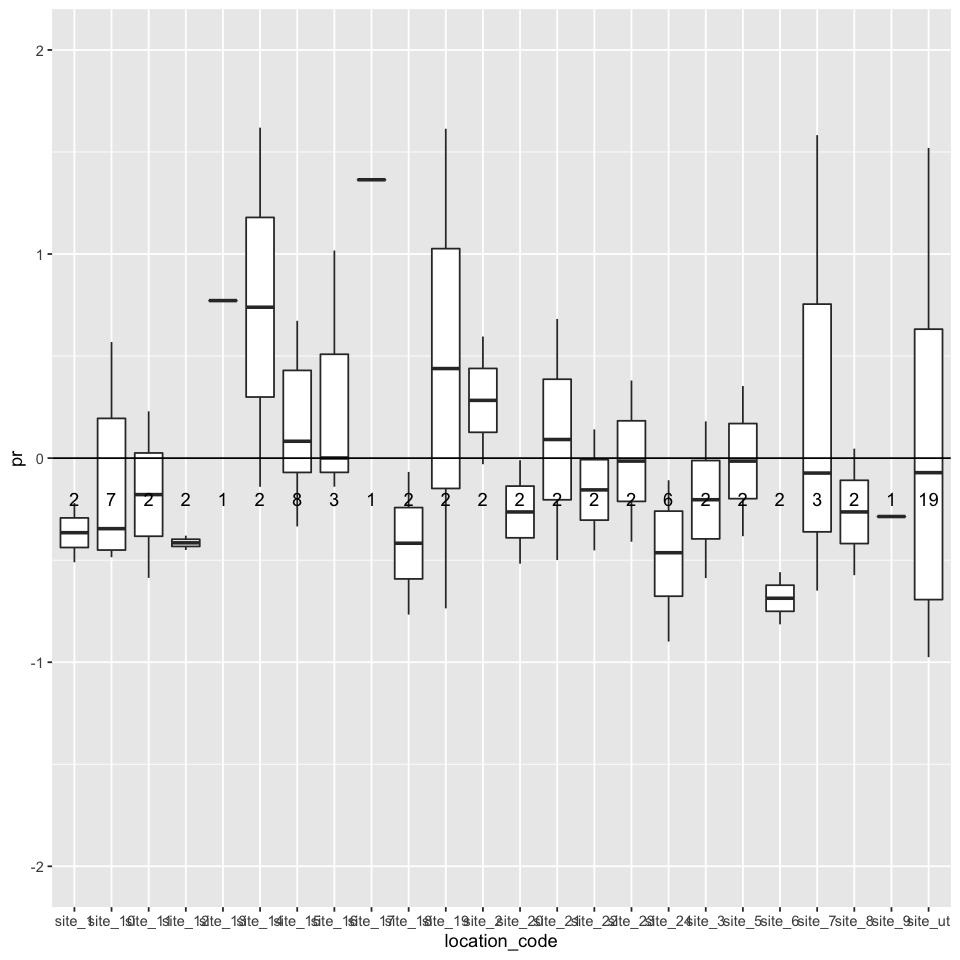

In [55]:
ggplot(data=CAM_ICC,aes( x=location_code,y=pr) )+geom_boxplot()+
geom_hline(yintercept=0)+ylim(-2,2)+stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))  

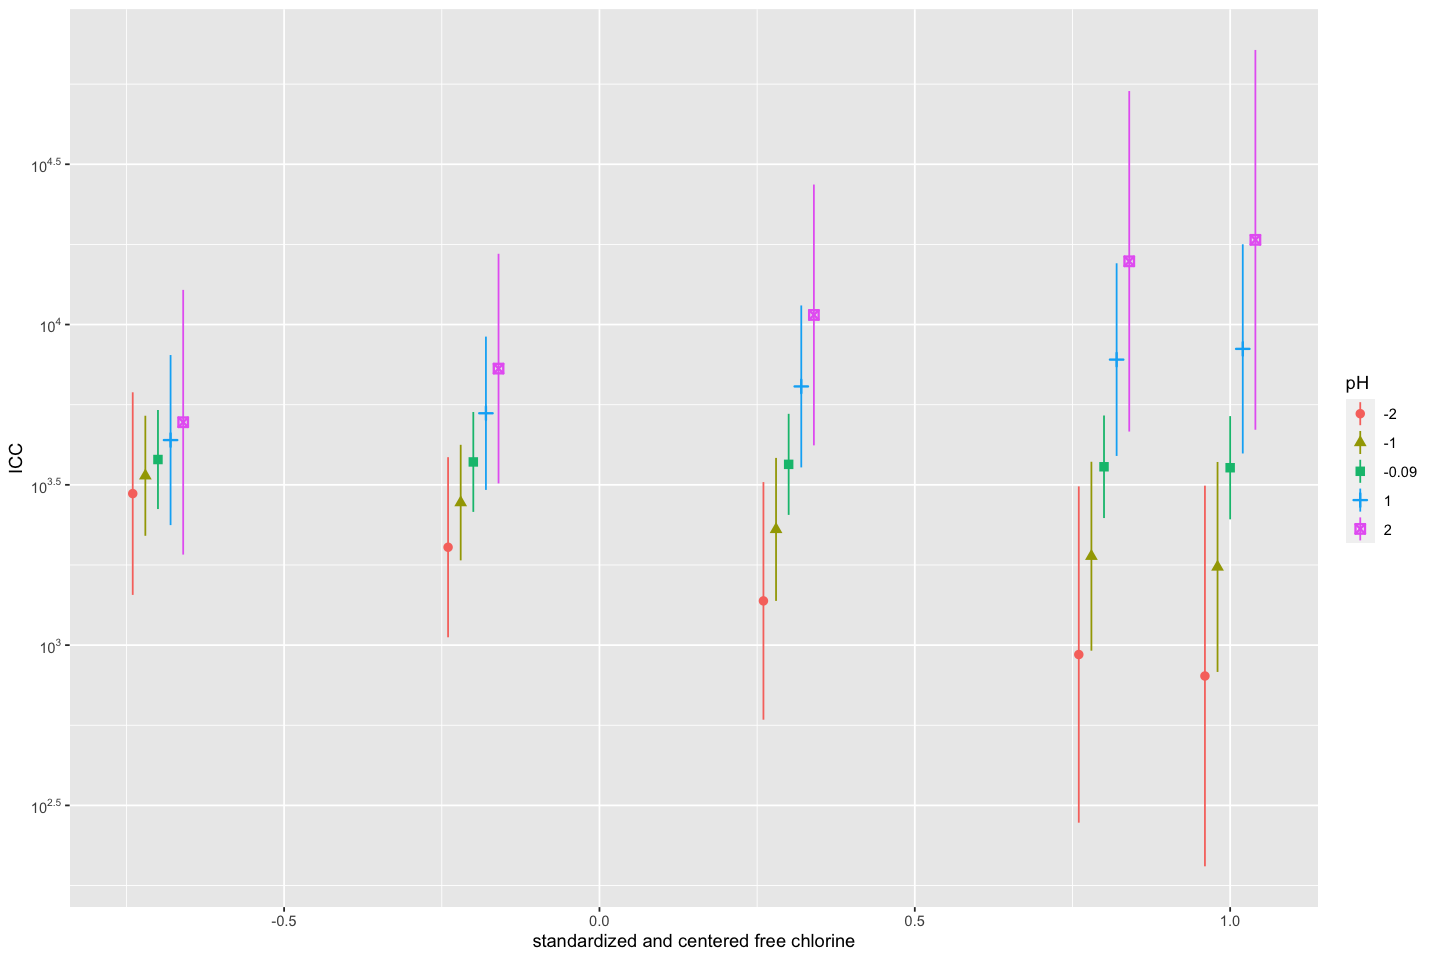

In [56]:
options(repr.plot.width =12, repr.plot.height = 8) #for plotting size in jupyter

e<-allEffects(glmm_ICC)
e.df1 <- as.data.frame(e)[1]
e.df1 <- as.data.frame(e.df1)
colnames(e.df1)<-c("pH","free_Cl2_mg.L","fit","se","lower","upper")
e.df1$pH<-as.factor(e.df1$pH)

g <- ggplot(e.df1,aes(x=free_Cl2_mg.L,y=fit,color=pH,shape=pH,ymin=lower,ymax=upper)) + 
    geom_pointrange(position=position_dodge(width=.1)) + 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
    xlab("standardized and centered free chlorine") + ylab("ICC") 
plot(g)

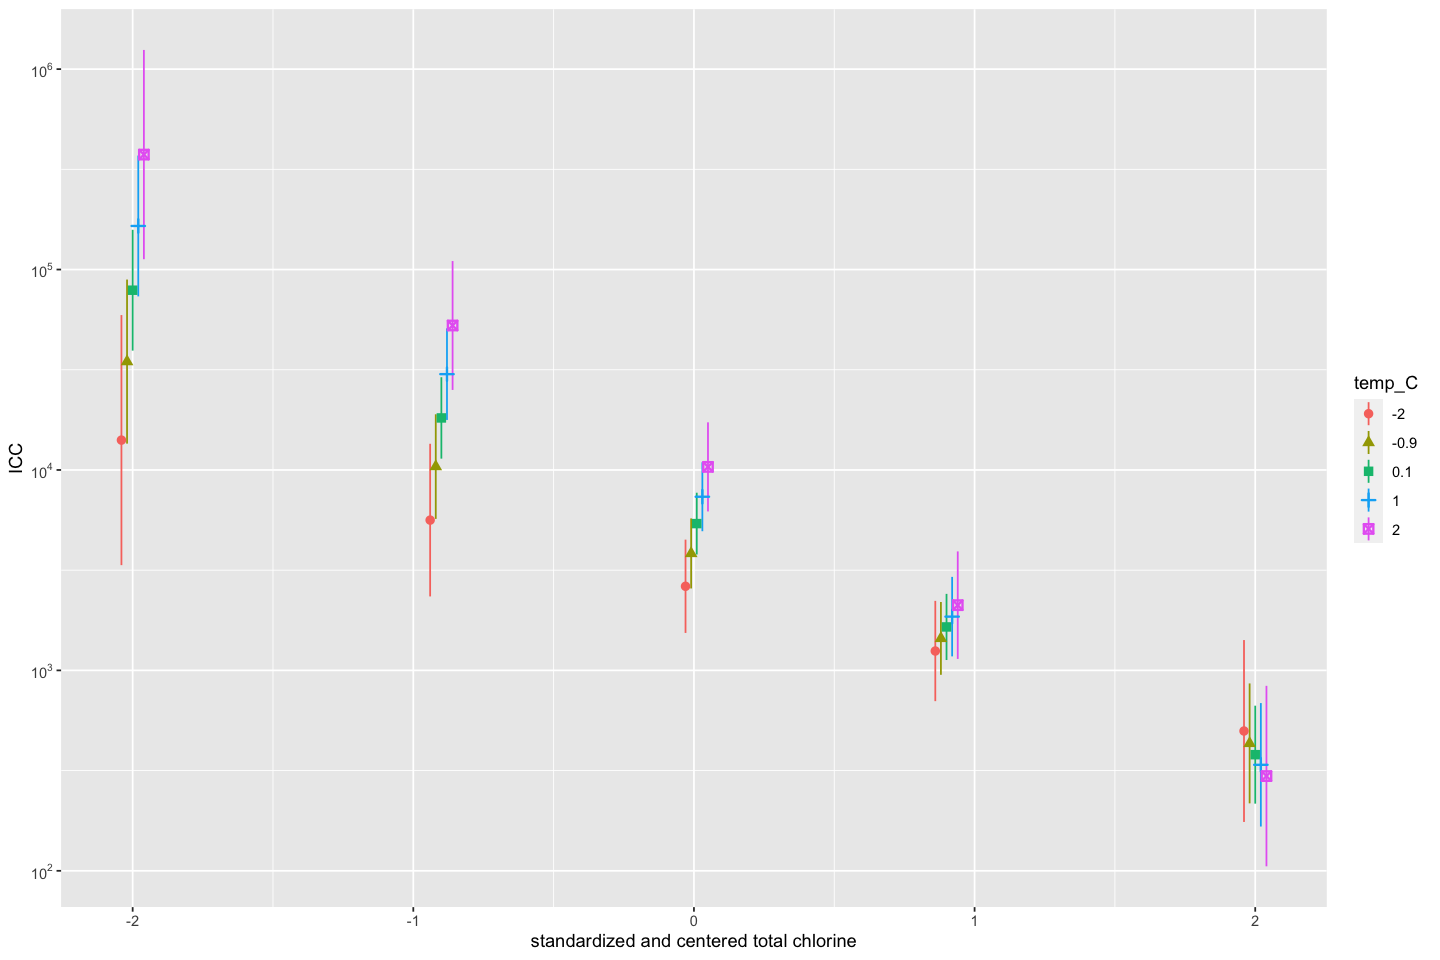

In [57]:
options(repr.plot.width =12, repr.plot.height = 8) #for plotting size in jupyter

e<-allEffects(glmm_ICC)
e.df2 <- as.data.frame(e)[2]
e.df2 <- as.data.frame(e.df2)
colnames(e.df2)<-c("total_Cl2_mg.L","temp_C","fit","se","lower","upper")
e.df2$temp_C<-as.factor(e.df2$temp_C)

g <- ggplot(e.df2,aes(x=total_Cl2_mg.L,y=fit,color=temp_C,shape=temp_C,ymin=lower,ymax=upper)) + 
    geom_pointrange(position=position_dodge(width=.1)) + 
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
    xlab("standardized and centered total chlorine") + ylab("ICC") 
plot(g)

## Figures 3 & S3

##### model visualization

##### predictions

In [58]:
#predictions

#using the example here https://www.rdocumentation.org/packages/lme4/versions/1.1-23/topics/predict.merMod
# model visualization total chlorine on the x axis where temp, pH and free chlorine are fixed
options(repr.plot.width =12, repr.plot.height = 8) #for plotting size in jupyter
l<-length(unique(CAM_ICC$location_code))
obs.points<-1:l
df.predicted <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =l),
                temp_C = mean(CAM_ICC$temp_C),
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))
predict.fun <- function(my.lmm) {
    predict(my.lmm, newdata = df.predicted, re.form = NA, type="response") } # This is predict.merMod 
#     make_predictions(glmm_ICC,total_Cl2_mg.L, interval=FALSE, )}
# 
df.predicted$ml.value <- predict.fun(glmm_ICC)

# Make predictions in 100 bootstraps of the LMM. Use these to get confidence intervals.
glmm.boots <- bootMer(glmm_ICC, predict.fun, nsim = 100) #this takes awhile!
df.predicted <- cbind(df.predicted, confint(glmm.boots))

quant<-as.data.frame(quantile(CAM_ICC$temp_C))[,1]
code<-factor( c("0%","25%","50%", "75%","100%"),levels=c("0%","25%","50%", "75%","100%"))
num=100
obs.points<-1:num
quant 
df.p1 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[1],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p2 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[2],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p3 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[3],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p4 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[4],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p5 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[5],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))



df.p1$pred<-predict(glmm_ICC, newdata = df.p1, re.form = NA, type="response") 
df.p1$code<-code[1]
df.p2$pred<-predict(glmm_ICC, newdata = df.p2, re.form = NA, type="response") 
df.p2$code<-code[2]
df.p3$pred<-predict(glmm_ICC, newdata = df.p3, re.form = NA, type="response") 
df.p3$code<-code[3]
df.p4$pred<-predict(glmm_ICC, newdata = df.p4, re.form = NA, type="response") 
df.p4$code<-code[4]
df.p5$pred<-predict(glmm_ICC, newdata = df.p5, re.form = NA, type="response") 
df.p5$code<-code[5]

df.predicted.quant<-rbind(df.p1,df.p2,df.p3,df.p4,df.p5)

df.predicted.a=df.predicted
df.predicted.quant.a=df.predicted.quant

[1] -1.8678364 -0.9800995 -0.5296062  0.8748729  2.1336043

In [59]:
# total_Cl2_mg.L:temp_C interaction demonstration with total chlorine on the x axis where  pH and free chlorine are fixed
quant<-as.data.frame(quantile(CAM_ICC$temp_C))[,1]
code<-factor( c("0%","25%","50%", "75%","100%"),levels=c("0%","25%","50%", "75%","100%"))
num=100
obs.points<-1:num
quant               
df.p1 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[1],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p2 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[2],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p3 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[3],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p4 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[4],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p5 <- data.frame(location_code = NA, x = obs.points,
                total_Cl2_mg.L = seq(min(CAM_ICC$total_Cl2_mg.L), max(CAM_ICC$total_Cl2_mg.L),length =num),
                temp_C = quant[5],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))



df.p1$pred<-predict(glmm_ICC, newdata = df.p1, re.form = NA, type="response") 
df.p1$code<-code[1]
df.p2$pred<-predict(glmm_ICC, newdata = df.p2, re.form = NA, type="response") 
df.p2$code<-code[2]
df.p3$pred<-predict(glmm_ICC, newdata = df.p3, re.form = NA, type="response") 
df.p3$code<-code[3]
df.p4$pred<-predict(glmm_ICC, newdata = df.p4, re.form = NA, type="response") 
df.p4$code<-code[4]
df.p5$pred<-predict(glmm_ICC, newdata = df.p5, re.form = NA, type="response") 
df.p5$code<-code[5]

df.predicted<-rbind(df.p1,df.p2,df.p3,df.p4,df.p5)

df.predicted.b=df.predicted

[1] -1.8678364 -0.9800995 -0.5296062  0.8748729  2.1336043

In [60]:
# total_Cl2_mg.L:temp_C interaction demonstration with temp on the x axis where  pH and free chlorine are fixed
quant<-as.data.frame(quantile(CAM_ICC$total_Cl2_mg.L))[,1]
quant
code<-factor( c("0%","25%","50%", "75%","100%"),levels=c("0%","25%","50%", "75%","100%"))
num=100
obs.points<-1:num
              
df.p1 <- data.frame(location_code = NA, x = obs.points,
                temp_C = seq(min(CAM_ICC$temp_C), max(CAM_ICC$temp_C),length =num),
                total_Cl2_mg.L = quant[1],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p2 <- data.frame(location_code = NA, x = obs.points,
                temp_C = seq(min(CAM_ICC$temp_C), max(CAM_ICC$temp_C),length =num),
                total_Cl2_mg.L= quant[2],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p3 <- data.frame(location_code = NA, x = obs.points,
                temp_C = seq(min(CAM_ICC$temp_C), max(CAM_ICC$temp_C),length =num),
                total_Cl2_mg.L = quant[3],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p4 <- data.frame(location_code = NA, x = obs.points,
                temp_C = seq(min(CAM_ICC$temp_C), max(CAM_ICC$temp_C),length =num),
                total_Cl2_mg.L = quant[4],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))

df.p5 <- data.frame(location_code = NA, x = obs.points,
                temp_C = seq(min(CAM_ICC$temp_C), max(CAM_ICC$temp_C),length =num),
                total_Cl2_mg.L = quant[5],
                free_Cl2_mg.L= mean(CAM_ICC$free_Cl2_mg.L),
                pH = mean(CAM_ICC$pH))



df.p1$pred<-predict(glmm_ICC, newdata = df.p1, re.form = NA, type="response") 
df.p1$code<-code[1]
df.p2$pred<-predict(glmm_ICC, newdata = df.p2, re.form = NA, type="response") 
df.p2$code<-code[2]
df.p3$pred<-predict(glmm_ICC, newdata = df.p3, re.form = NA, type="response") 
df.p3$code<-code[3]
df.p4$pred<-predict(glmm_ICC, newdata = df.p4, re.form = NA, type="response") 
df.p4$code<-code[4]
df.p5$pred<-predict(glmm_ICC, newdata = df.p5, re.form = NA, type="response") 
df.p5$code<-code[5]

df.predicted<-rbind(df.p1,df.p2,df.p3,df.p4,df.p5)
df.predicted.c=df.predicted

[1] -1.8420675 -0.4288948  0.5067675  0.9584665  1.8618645

In [61]:
# free chlorine:pH interaction demonstration with pH on the x axis where  temp and total chlorine are fixed
quant<-as.data.frame(quantile(CAM_ICC$free_Cl2_mg.L))[,1]
quant
code<-factor( c("0%","25%","50%", "75%","100%"),levels=c("0%","25%","50%", "75%","100%"))
num=100
obs.points<-1:num
              
df.p1 <- data.frame(location_code = NA, x = obs.points,
                pH= seq(min(CAM_ICC$pH), max(CAM_ICC$pH),length =num),
                free_Cl2_mg.L = quant[1],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p2 <- data.frame(location_code = NA, x = obs.points,
                pH= seq(min(CAM_ICC$pH), max(CAM_ICC$pH),length =num),
                free_Cl2_mg.L = quant[2],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p3 <- data.frame(location_code = NA, x = obs.points,
                pH= seq(min(CAM_ICC$pH), max(CAM_ICC$pH),length =num),
                free_Cl2_mg.L = quant[3],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p4 <- data.frame(location_code = NA, x = obs.points,
                pH= seq(min(CAM_ICC$pH), max(CAM_ICC$pH),length =num),
                free_Cl2_mg.L = quant[4],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p5 <- data.frame(location_code = NA, x = obs.points,
                pH= seq(min(CAM_ICC$pH), max(CAM_ICC$pH),length =num),
                free_Cl2_mg.L = quant[5],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))



df.p1$pred<-predict(glmm_ICC, newdata = df.p1, re.form = NA, type="response") 
df.p1$code<-code[1]
df.p2$pred<-predict(glmm_ICC, newdata = df.p2, re.form = NA, type="response") 
df.p2$code<-code[2]
df.p3$pred<-predict(glmm_ICC, newdata = df.p3, re.form = NA, type="response") 
df.p3$code<-code[3]
df.p4$pred<-predict(glmm_ICC, newdata = df.p4, re.form = NA, type="response") 
df.p4$code<-code[4]
df.p5$pred<-predict(glmm_ICC, newdata = df.p5, re.form = NA, type="response") 
df.p5$code<-code[5]

df.predicted<-rbind(df.p1,df.p2,df.p3,df.p4,df.p5)
df.predicted.d=df.predicted

[1] -0.6902148 -0.6902148 -0.5781607 -0.3820659  1.2520569

In [62]:
# free chlorine:pH interaction demonstration with free chlorine on the x axis where  temp and total chlorine are fixed
quant<-as.data.frame(quantile(CAM_ICC$pH))[,1]
quant
code<-factor( c("0%","25%","50%", "75%","100%"),levels=c("0%","25%","50%", "75%","100%"))
num=100
obs.points<-1:num
              
df.p1 <- data.frame(location_code = NA, x = obs.points,
                free_Cl2_mg.L= seq(min(CAM_ICC$free_Cl2_mg.L), max(CAM_ICC$free_Cl2_mg.L),length =num),
                pH = quant[1],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p2 <- data.frame(location_code = NA, x = obs.points,
                free_Cl2_mg.L= seq(min(CAM_ICC$free_Cl2_mg.L), max(CAM_ICC$free_Cl2_mg.L),length =num),
                pH = quant[2],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p3 <-data.frame(location_code = NA, x = obs.points,
                free_Cl2_mg.L= seq(min(CAM_ICC$free_Cl2_mg.L), max(CAM_ICC$free_Cl2_mg.L),length =num),
                pH = quant[3],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p4 <- data.frame(location_code = NA, x = obs.points,
                free_Cl2_mg.L= seq(min(CAM_ICC$free_Cl2_mg.L), max(CAM_ICC$free_Cl2_mg.L),length =num),
                pH = quant[4],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))

df.p5 <- data.frame(location_code = NA, x = obs.points,
                free_Cl2_mg.L= seq(min(CAM_ICC$free_Cl2_mg.L), max(CAM_ICC$free_Cl2_mg.L),length =num),
                pH = quant[5],
                total_Cl2_mg.L= mean(CAM_ICC$total_Cl2_mg.L),
                temp_C = mean(CAM_ICC$temp_C))



df.p1$pred<-predict(glmm_ICC, newdata = df.p1, re.form = NA, type="response") 
df.p1$code<-code[1]
df.p2$pred<-predict(glmm_ICC, newdata = df.p2, re.form = NA, type="response") 
df.p2$code<-code[2]
df.p3$pred<-predict(glmm_ICC, newdata = df.p3, re.form = NA, type="response") 
df.p3$code<-code[3]
df.p4$pred<-predict(glmm_ICC, newdata = df.p4, re.form = NA, type="response") 
df.p4$code<-code[4]
df.p5$pred<-predict(glmm_ICC, newdata = df.p5, re.form = NA, type="response") 
df.p5$code<-code[5]

df.predicted<-rbind(df.p1,df.p2,df.p3,df.p4,df.p5)

df.predicted.e=df.predicted

[1] -2.3500293 -0.7822156 -0.1725102  0.2049264  2.1792104

##### plot code

In [63]:
w2=6
h2=4 
l=0.5
options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=7, base_family="Arial"))#, base_line_size= 1))

In [64]:
# Plot the ML prediction and its confidence intervals
a<-ggplot(data=CAM_ICC) + 
geom_line(data=df.predicted.a, aes(x=total_Cl2_mg.L, y=ml.value), linetype="dashed",lwd=l) +
  geom_ribbon(data=df.predicted.a, aes(x=total_Cl2_mg.L, ymin=`2.5 %`,
                                          ymax=`97.5 %`),
                   fill="gray", alpha=0.5, inherit.aes = FALSE)+
    geom_line(data=df.predicted.quant.a, aes(x=total_Cl2_mg.L, y=pred, color=code), lwd=l) +
    ylim(-1, max(CAM_ICC$SGPI+1000))+
    ylab("intact cell count\n(cells per mL)")+
    xlab("total chlorine concentration\n(standardized and centered)")+
    labs(color = " quantiles of temperature\n(standardized and centered)")+
    scale_color_viridis_d()+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 


In [65]:
# Plot the predictions based on 
b<-ggplot(data=CAM_ICC)+ geom_line(data=df.predicted.b, aes(x=total_Cl2_mg.L, y=pred, color=code), lwd=l) +
    ylim(-1, max(CAM_ICC$SGPI+1000))+
    ylab("intact cell count\n(cells per mL)")+
    xlab("total chlorine concentration\n(standardized and centered)")+
    labs(color = " quantiles\nof temperature\n(standardized\nand centered)")+
    scale_color_viridis_d()+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 

In [66]:
# Plot the predictions based on 
c<-ggplot(data=CAM_ICC) + geom_line(data=df.predicted.c, aes(x=temp_C, y=pred, color=code), lwd=l) +
    ylim(-1, max(CAM_ICC$SGPI+1000))+
    ylab("intact cell count\n(cells per mL)")+
    xlab("temperature\n(standardized and centered)")+
    labs(color = " quantiles\nof total chlorine\n(standardized\nand centered)")+
    scale_color_viridis_d()+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 

In [67]:
# Plot the predictions based on 
d<-ggplot(data=CAM_ICC)  + geom_line(data=df.predicted.d, aes(x=pH, y=pred, color=code), lwd=l) +
    ylim(-1, max(CAM_ICC$SGPI+1000))+
    ylab("intact cell count\n(cells per mL)")+
    xlab("pH\n(standardized and centered)")+
    labs(color = " quantiles\nof free chlorine\n(standardized\nand centered)")+
    scale_color_viridis_d()+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 

In [68]:

# Plot the predictions based on 
e<-ggplot(data=CAM_ICC)  + geom_line(data=df.predicted.e, aes(x=free_Cl2_mg.L, y=pred, color=code), lwd=l) +
    ylim(-1, max(CAM_ICC$SGPI+1000))+
    ylab("intact cell count\n(cells per mL)")+
    xlab("free chlorine\n(standardized and centered)")+
    labs(color = " quantiles\nof pH\n(standardized\nand centered)")+
    scale_color_viridis_d()+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 

### plot

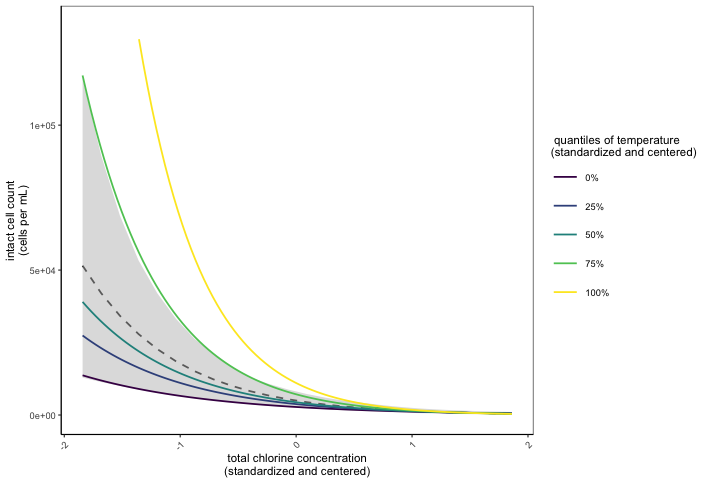

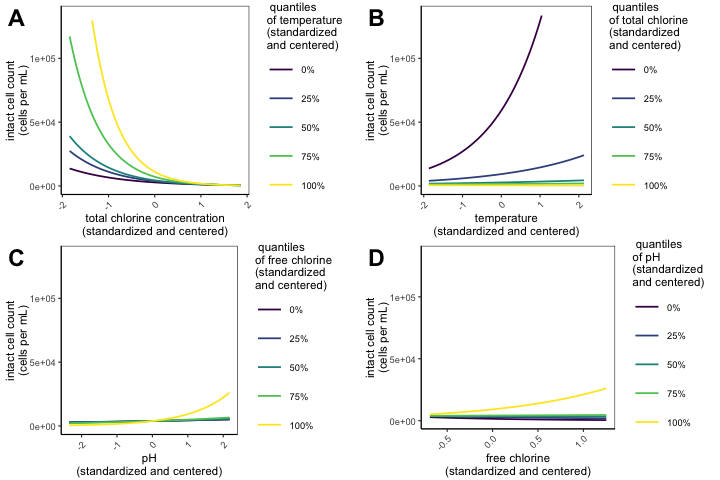

In [69]:
#Figure 3
a
ggsave(paste(path_fig,"Figure_3.pdf",sep=""), device= cairo_pdf, units='mm', width=single.col_w, height=max_h/5)

#Figure S3
ggarrange(b,c,d,e,
          labels = c("A", "B","C","D"),
           ncol = 2, nrow = 2, common.legend=FALSE)
#           ncol = 1, nrow = 3, common.legend=TRUE, legend= NULL, align="v")


ggsave(paste(path_fig,"Figure_S3.pdf",sep=""), device= cairo_pdf, units='mm', width=max_w, height=(max_h/2))




In [70]:
#https://r-sig-mixed-models.r-project.narkive.com/4jQJ7hfz/r-sig-me-residual-variance-or-dispersion-of-gamma-glmer
glmm_ICC
sigma(glmm_ICC) #this is an estimate of the coefficient of variation or 1/sqrt(shape parameter)
tau<-(1/sigma(glmm_ICC))^2
tau
VarCorr(glmm_ICC)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: 
SGPI ~ total_Cl2_mg.L + pH + temp_C + (1 | location_code) + free_Cl2_mg.L:pH +  
    total_Cl2_mg.L:temp_C
   Data: CAM_ICC
      AIC       BIC    logLik  deviance  df.resid 
1524.3504 1543.4066 -754.1752 1508.3504        72 
Random effects:
 Groups        Name        Std.Dev.
 location_code (Intercept) 0.5107  
 Residual                  0.7630  
Number of obs: 80, groups:  location_code, 24
Fixed Effects:
          (Intercept)         total_Cl2_mg.L                     pH  
               8.6349                -1.3103                 0.3979  
               temp_C       pH:free_Cl2_mg.L  total_Cl2_mg.L:temp_C  
               0.3453                 0.3853                -0.2374  

[1] 0.7630079

[1] 1.717678

 Groups        Name        Std.Dev.
 location_code (Intercept) 0.51065 
 Residual                  0.76301 

In [71]:
#Using code from this site to test my assumption above: https://github.com/lme4/lme4/issues/290

set.seed(101)
d <- expand.grid(block=LETTERS[1:26], rep=1:100, KEEP.OUT.ATTRS = FALSE)
d$x <- runif(nrow(d))  ## sd=1
reff_f <- rnorm(length(levels(d$block)),sd=1)
## need intercept large enough to avoid negative values
d$eta0 <- 4+3*d$x  ## fixed effects only
d$eta <- d$eta0+reff_f[d$block]

shapevec <- tau
res <- expand.grid(rep=1:10,shape=shapevec,est=NA) ## order matters
k <- 1
i <- 1
numOK <- 0
## for (i in seq_along(shapevec)) {
## cat(".")
for (j in 1:10) {
    dgl <- d
    dgl$mu <- exp(d$eta)
    dgl$y <- rgamma(nrow(d),scale=dgl$mu/2,shape=shapevec[i])
    ggl1 <- try(glmer(y ~ x + (1|block), data=dgl, family=Gamma(link="log")))
    if (!is(ggl1,"try-error")) numOK <- numOK+1
    ## res[k,"est"] <- 1/sigma(ggl1)^2
    k <- k+1
}

sigma(ggl1)#checks out
set.seed(30)

[1] 0.7626323

## 4. Rename

##### Rename columns for plotting

In [72]:

utility_name<- "site ut"
SG_all$location_code <- gsub("site_ut", utility_name, SG_all$location_code)
SGPI_all$location_code <- gsub("site_ut", utility_name, SGPI_all$location_code)
ATP_long$location_code <- gsub("site_ut", utility_name, ATP_long$location_code)
fcm_all_long$location_code <- gsub("site_ut", utility_name, fcm_all_long$location_code)

#call raw
raw_name<- "raw water"
SG_all$location_code <- gsub("raw_water", raw_name, SG_all$location_code)
SGPI_all$location_code <- gsub("raw_water", raw_name, SGPI_all$location_code)
ATP_long$location_code <- gsub("raw_water", raw_name, ATP_long$location_code)
fcm_all_long$location_code <- gsub("raw_water", raw_name, fcm_all_long$location_code)

#call eff
eff_name<- "finished water"
SG_all$location_code <- gsub("finished_water", eff_name, SG_all$location_code)
SGPI_all$location_code <- gsub("finished_water", eff_name, SGPI_all$location_code)
ATP_long$location_code <- gsub("finished_water", eff_name, ATP_long$location_code)
fcm_all_long$location_code <- gsub("finished_water", eff_name, fcm_all_long$location_code)


#paper
D_A<-"system A"
D_B<-"system B"
D_C<-"system C"
D_D<-"system D"
D_F<-"system F"
D_E<-"system E"

#call other descriptors
TCC_l<-"total cell count"
ICC_l<-"intact cell count"

ATPi_l<- "intracellular ATP"
ATPt_l<- "total ATP"

lc<- "sampling_site"
bl<- "sampling_location"
atp<-"ATP assay"
ccl<-"cell count"

#call other descriptors plotting!
TCC_lp<-"`total cell count`"
ICC_lp<-"`intact cell count`"

ATPi_lp<- "`intracellular ATP`"
ATPt_lp<- "`total ATP`"

lcp<- "`sampling_site`"
blp<- "`sampling_location`"
atpp<-"`ATP assay`"
cclp<-"`cell count`"

#quantification Limits & label BDL values where needed
TCC_d=geom_hline(yintercept=TCC_lim, linetype="solid", color = "black", size = 0.25) #lower limit of quantification
ICC_d=geom_hline(yintercept=ICC_lim, linetype="dashed", color = "black", size = 0.5) #lower limit of quantification
ATPt_d=geom_hline(yintercept=ATPt_lim, linetype="solid", color = "black", size = 0.25)  # Total ATP lower limit of quantification
ATPi_d=geom_hline(yintercept=ATPi_lim, linetype="dashed", color = "black", size = 0.5)  # Intracellular ATP limit of quantification
HPC_d=geom_hline(yintercept=HPC_lim, linetype="dashed", color = "black", size = 0.5)  

#axis labels- x
flow_x=xlab("flow cytometer")
free_x= xlab("free chlorine residual (mg/L)")
total_x= xlab("total chlorine residual (mg/L)")
date_x= xlab("sampling date")
lc_x<- xlab("sampling site")

#axis labels- y
IT_y= ylab("proportion of intact cells")
TCC_y=ylab("total cell count (cells/mL)")
ICC_y=ylab("intact cell count (cells/mL)")
CC_y=ylab("cell count (cells/mL)")
ATPi_y= ylab("intracellular ATP (nM)")
 ATPt_y= ylab("total ATP (nM)")
R_y=ylab("regrowth potential")
HPC_y= ylab("HPC\n(most probable number per 100 mL)")
ATP_y= ylab("ATP (nM)")
regf_y=ylab("increase in total cell count (\u0025)")
cl2_y= ylab("chlorine (mg/L)")


In [73]:
#rename everything for plots
SG_all$site <- gsub("other_site_in_", "other site\nin ", SG_all$site)
SGPI_all$site <- gsub("other_site_in_", "other site\nin ", SGPI_all$site)
ATP_long$site <- gsub("other_site_in_", "other site\nin ", ATP_long$site)
fcm_all_long$site <- gsub("other_site_in_", "other site\nin ", fcm_all_long$site)

SG_all$site <- gsub("DWDS_A", D_A, SG_all$site)
SGPI_all$site <- gsub("DWDS_A", D_A, SGPI_all$site)
ATP_long$site <- gsub("DWDS_A", D_A, ATP_long$site)
fcm_all_long$site <- gsub("DWDS_A", D_A, fcm_all_long$site)

SG_all$site <- gsub("DWDS_B", D_B, SG_all$site)
SGPI_all$site <- gsub("DWDS_B", D_B, SGPI_all$site)
ATP_long$site <- gsub("DWDS_B", D_B, ATP_long$site)
fcm_all_long$site <- gsub("DWDS_B", D_B, fcm_all_long$site)

SG_all$site <- gsub("DWDS_C", D_C, SG_all$site)
SGPI_all$site <- gsub("DWDS_C", D_C, SGPI_all$site)
ATP_long$site <- gsub("DWDS_C", D_C, ATP_long$site)
fcm_all_long$site <- gsub("DWDS_C", D_C,fcm_all_long$site)


SG_all$site <- gsub("DWDS_F", D_F, SG_all$site)
SGPI_all$site <- gsub("DWDS_F", D_F, SGPI_all$site)
ATP_long$site <- gsub("DWDS_F", D_F, ATP_long$site)
fcm_all_long$site <- gsub("DWDS_F", D_F, fcm_all_long$site)

SG_all$broad_location <- gsub("DWDS_A", D_A, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_A", D_A, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_A", D_A, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_A", D_A, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_A", D_A, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_A", D_A, fcm_all_long$broad_location)

SG_all$broad_location <- gsub("DWDS_B", D_B, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_B", D_B, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_B", D_B, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_B", D_B, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_B", D_B, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_B", D_B, fcm_all_long$broad_location)

SG_all$broad_location <- gsub("DWDS_C", D_C, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_C", D_C, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_C", D_C, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_C", D_C, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_C", D_C, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_C", D_C,fcm_all_long$broad_location)

SG_all$broad_location <- gsub("DWDS_D", D_D, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_D", D_D, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_D", D_D, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_D", D_D, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_D", D_D, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_D", D_D, fcm_all_long$broad_location)

SG_all$broad_location <- gsub("DWDS_E", D_E, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_E", D_E, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_E", D_E, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_E", D_E, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_E", D_E, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_E", D_E, fcm_all_long$broad_location)

SG_all$broad_location <- gsub("DWDS_F", D_F, SG_all$broad_location)
SGPI_all$broad_location <- gsub("DWDS_F", D_F, SGPI_all$broad_location)
ATP_long$broad_location <- gsub("DWDS_F", D_F, ATP_long$broad_location)
mwq_all$broad_location <- gsub("DWDS_F", D_F, mwq_all$broad_location)
mwq_quant$broad_location <- gsub("DWDS_F", D_F, mwq_quant$broad_location)
fcm_all_long$broad_location <- gsub("DWDS_F", D_F, fcm_all_long$broad_location)

ATP_long$variable <- gsub("total_ATP_gmean_nM", ATPt_l, ATP_long$variable)
ATP_long$variable <- gsub("intra_ATP_gmean_nM", ATPi_l, ATP_long$variable)

SG_all$stain <- gsub("SG", TCC_l, SG_all$stain)
SGPI_all$stain <- gsub("SGPI", ICC_l, SGPI_all$stain)
fcm_all_long$stain <- gsub("SGPI", ICC_l, fcm_all_long$stain)
fcm_all_long$stain <- gsub("SG", TCC_l, fcm_all_long$stain)

names(SGPI_all)[names(SGPI_all) == "location_code"] <- lc
names(SG_all)[names(SG_all) == "location_code"] <- lc
names(ATP_long)[names(ATP_long) == "location_code"] <- lc
names(mwq_all)[names(mwq_all) == "location_code"] <- lc
names(mwq_quant)[names(mwq_quant) == "location_code"] <- lc
names(fcm_all_long)[names(fcm_all_long) == "location_code"] <- lc

names(SGPI_all)[names(SGPI_all) == "broad_location"] <- bl
names(SG_all)[names(SG_all) == "broad_location"] <- bl
names(ATP_long)[names(ATP_long) == "broad_location"] <- bl
names(mwq_all)[names(mwq_all) == "broad_location"] <- bl
names(mwq_quant)[names(mwq_quant) == "broad_location"] <- bl
names(fcm_all_long)[names(fcm_all_long) == "broad_location"] <- bl

names(mwq_all)[names(mwq_all) == "SG"] <- TCC_l
names(mwq_all)[names(mwq_all) == "SGPI"] <- ICC_l
names(mwq_quant)[names(mwq_quant) == "SG"] <- TCC_l
names(mwq_quant)[names(mwq_quant) == "SGPI"] <- ICC_l

names(SGPI_all)[names(SGPI_all) == "intra_ATP_gmean_nM"] <- ATPi_l
names(SG_all)[names(SG_all) == "intra_ATP_gmean_nM"] <- ATPi_l
names(mwq_all)[names(mwq_all) == "intra_ATP_gmean_nM"] <- ATPi_l
names(mwq_quant)[names(mwq_quant) == "intra_ATP_gmean_nM"] <- ATPi_l

names(SGPI_all)[names(SGPI_all) == "total_ATP_gmean_nM"] <- ATPt_l
names(SG_all)[names(SG_all) == "total_ATP_gmean_nM"] <- ATPt_l
names(mwq_all)[names(mwq_all) == "total_ATP_gmean_nM"] <- ATPt_l
names(mwq_quant)[names(mwq_quant) == "total_ATP_gmean_nM"] <- ATPt_l

names(SGPI_all)[names(SGPI_all) == "stain"] <- ccl
names(SG_all)[names(SG_all) == "stain"] <- ccl
names(fcm_all_long)[names(fcm_all_long) == "stain"] <- ccl

names(ATP_long)[names(ATP_long) == "variable"] <- atp




## Tables 3 & S5

###### Assessment of detection limits

In [74]:

row_nam<-c("intact cell count","total cell count", "intracellular ATP", "total ATP","heterotrophic plate counts")
col_nam<- c("assay","n", 'percent quantifiable', 'percent below quantification limit','percent above quantification limit')

#totals (n)
tot_ATPi<-length(mwq_all_c[!is.na(mwq_all_c$intra_ATP_gmean_nM),"intra_ATP_gmean_nM"])
tot_ATPt<-length(mwq_all_c[!is.na(mwq_all_c$total_ATP_gmean_nM),"total_ATP_gmean_nM"])
tot_SGPI<-length(mwq_all_c[!is.na(mwq_all_c$SGPI),"SGPI"])
tot_SG<-length(mwq_all_c[!is.na(mwq_all_c$SG),"SG"])
tot_HPC<-length(mwq_all_c[!is.na(mwq_all_c$HPC_gmean_MPN_per_100mL),"HPC_gmean_MPN_per_100mL"])
tots<-c(tot_SGPI,tot_SG,tot_ATPi,tot_ATPt, tot_HPC)

#number of quantifiable samples 
nq_ATPi<-length(mwq_quant_ATPi[!is.na(mwq_quant_ATPi$intra_ATP_gmean_nM),"intra_ATP_gmean_nM"])
nq_ATPt<-length(mwq_quant_ATPt[!is.na(mwq_quant_ATPt$total_ATP_gmean_nM),"total_ATP_gmean_nM"])
nq_SGPI<-length(mwq_quant_SGPI[!is.na(mwq_quant_SGPI$SGPI),"SGPI"])
nq_SG<-length(mwq_quant_SG[!is.na(mwq_quant_SG$SG),"SG"])
nq_HPC<-length(mwq_quant_HPC[!is.na(mwq_quant_HPC$HPC_gmean_MPN_per_100mL),"HPC_gmean_MPN_per_100mL"])
pq<-(c(nq_SGPI,nq_SG,nq_ATPi,nq_ATPt,nq_HPC)*100)/tots

#number below quantification limit
bdl_ATPi<- tot_ATPi-nq_ATPi
bdl_ATPt<- tot_ATPt-nq_ATPt
bdl_SGPI<-tot_SGPI-nq_SGPI
bdl_SG<-tot_SG-nq_SG
bdl_HPC<-length(mwq_all[((mwq_all$HPC_label=="BDL")&(!is.na(mwq_all$HPC_label))),]$HPC_gmean_MPN_per_100mL)
pbdl<-(c(bdl_SGPI,bdl_SG,bdl_ATPi,bdl_ATPt,bdl_HPC)*100)/tots

#number above quantification limit (only HPC)
adl_ATPi<- 0
adl_ATPt<- 0
adl_SGPI<-0
adl_SG<-0
adl_HPC<-length(mwq_all[((mwq_all$HPC_label=="ADL")&(!is.na(mwq_all$HPC_label))),]$HPC_gmean_MPN_per_100mL)
padl<-(c(adl_SGPI,adl_SG, adl_ATPi,adl_ATPt,adl_HPC)*100)/tots

#check
adl_HPC + bdl_HPC +nq_HPC ==tot_HPC
pq+pbdl+padl 


[1] TRUE

[1] 100 100 100 100 100

### Table 3

###### quantifiable samples by assay

In [75]:
#generate table

table1<- as.data.frame(cbind(row_nam, tots,pq,pbdl,padl))
names(table1)<- col_nam
table1

stargazer(table1,type="html", summary=FALSE,  out=paste(path_tab,"Table_3.doc"))


assay                      n   percent quantifiable
1 intact cell count          166 97.5903614457831    
2 total cell count           166 100                 
3 intracellular ATP          115 69.5652173913043    
4 total ATP                  115 100                 
5 heterotrophic plate counts 102 81.3725490196078    
  percent below quantification limit percent above quantification limit
1 2.40963855421687                   0                                 
2 0                                  0                                 
3 30.4347826086957                   0                                 
4 0                                  0                                 
5 14.7058823529412                   3.92156862745098


<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>assay</td><td>n</td><td>percent quantifiable</td><td>percent below quantification limit</td><td>percent above quantification limit</td></tr>
<tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>intact cell count</td><td>166</td><td>97.5903614457831</td><td>2.40963855421687</td><td>0</td></tr>
<tr><td style="text-align:left">2</td><td>total cell count</td><td>166</td><td>100</td><td>0</td><td>0</td></tr>
<tr><td style="text-align:left">3</td><td>intracellular ATP</td><td>115</td><td>69.5652173913043</td><td>30.4347826086957</td><td>0</td></tr>
<tr><td style="text-align:left">4</td><td>total ATP</td><td>115</td><td>100</td><td>0</td><td>0</td></tr>
<tr><td style="text-align:left">5</td><td>heterotrophic plate counts</td><td>102</td><td>81.3725490196078</td><td>14.7058823529412</td><td>3.92

### Table S5 

###### quantifiable samples by DWDS

In [76]:
#same as above but by broad location
locations<-sort(unique(mwq_all_c$broad_location))[1:6]#DWDS

locations
table<- row_nam
for (i in locations) {
    a<-mwq_all_c[mwq_all_c$broad_location== i,]
    
    #totals (n)
    tot_ATPi<-length(a$intra_ATP_gmean_nM[!is.na(a$intra_ATP_gmean_nM)])
    tot_ATPt<-length(a$total_ATP_gmean_nM[!is.na(a$total_ATP_gmean_nM)])
    tot_SGPI<-length(a$SGPI[!is.na(a$SGPI)])
    tot_SG<-length(a$SG[!is.na(a$SG)])
    tot_HPC<-length(a$HPC_gmean_MPN_per_100mL[!is.na(a$HPC_gmean_MPN_per_100mL)])
    tots<-c(tot_SGPI,tot_SG, tot_ATPi,tot_ATPt,tot_HPC)
    
    
    #find how many per location
    la<-unique(mwq_quant_ATPi$broad_location)
    li<-unique(mwq_quant_SGPI$broad_location)
    lh<-unique(mwq_quant_HPC$broad_location)
    
    if (i %in% la){
        qai<-mwq_quant_ATPi[mwq_quant_ATPi$broad_location== i,]
        qat<-mwq_quant_ATPt[mwq_quant_ATPt$broad_location== i,]
    }
    else{
        qai<-"-"
        qat<-"-"
    }    
    if (i %in% li){
        qi<-mwq_quant_SGPI[mwq_quant_SGPI$broad_location== i,]
        qt<-mwq_quant_SG[mwq_quant_SG$broad_location== i,]
    }
    else{
        qi<-"-"
        qt<-"-"
    }
    if (i %in% lh){
        qh<-mwq_quant_HPC[mwq_quant_HPC$broad_location== i,]
        
    }
    else{
        qh<-"-"
    }
        
    # calculate number of quantifiable samples 
    nq_ATPi<-length(qai$intra_ATP_gmean_nM[!is.na(qai$intra_ATP_gmean_nM)])
    nq_ATPt<-length(qat$total_ATP_gmean_nM[!is.na(qat$total_ATP_gmean_nM)])
    nq_SGPI<-length(qi$SGPI[!is.na(qi$SGPI)])
    nq_SG<-length(qt$SG[!is.na(qt$SG)])
    nq_HPC<-length(qh$HPC_gmean_MPN_per_100mL[!is.na(qh$HPC_gmean_MPN_per_100mL)])
    pq<-round(((c(nq_SGPI,nq_SG, nq_ATPi,nq_ATPt,nq_HPC)*100)/tots),1)
    
    #tack onto table
    new<-as.data.frame(cbind(tots, pq))
    ntot<-paste("n (", i, ")", sep="")
    nnq<- paste("percent quantifiable (", i, ")", sep="")
    names(new)<- c(ntot, nnq)
    table<-cbind(table, new)
}
table

[1] DWDS_A DWDS_B DWDS_C DWDS_D DWDS_E DWDS_F
Levels: DWDS_A DWDS_B DWDS_C DWDS_D DWDS_E DWDS_F

table                      n (DWDS_A) percent quantifiable (DWDS_A)
1 intact cell count          22         100.0                        
2 total cell count           22         100.0                        
3 intracellular ATP          11          90.9                        
4 total ATP                  11         100.0                        
5 heterotrophic plate counts 21          76.2                        
  n (DWDS_B) percent quantifiable (DWDS_B) n (DWDS_C)
1 20         100                           12        
2 20         100                           12        
3 10          90                            0        
4 10         100                            0        
5 10          90                            0        
  percent quantifiable (DWDS_C) n (DWDS_D) percent quantifiable (DWDS_D)
1 100                           7           85.7                        
2 100                           7          100.0                        
3 NaN                           0            NaN                        
4 NaN                           0            NaN                        
5 NaN                           0            NaN                        
  n (DWDS_E) percent quantifiable (DWDS_E) n (DWDS_F)
1 5           40                           100       
2 5          100                           100       
3 0          NaN                            94       
4 0          NaN                            94       
5 0          NaN                            71       
  percent quantifiable (DWDS_F)
1 100.0                        
2 100.0                        
3  64.9                        
4 100.0                        
5  81.7

In [77]:
#export
stargazer(table,type="html", summary=FALSE,  out=paste(path_tab,"Table_S5.doc"))
table


<table style="text-align:center"><tr><td colspan="14" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>table</td><td>n (DWDS_A)</td><td>percent quantifiable (DWDS_A)</td><td>n (DWDS_B)</td><td>percent quantifiable (DWDS_B)</td><td>n (DWDS_C)</td><td>percent quantifiable (DWDS_C)</td><td>n (DWDS_D)</td><td>percent quantifiable (DWDS_D)</td><td>n (DWDS_E)</td><td>percent quantifiable (DWDS_E)</td><td>n (DWDS_F)</td><td>percent quantifiable (DWDS_F)</td></tr>
<tr><td colspan="14" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>intact cell count</td><td>22</td><td>100</td><td>20</td><td>100</td><td>12</td><td>100</td><td>7</td><td>85.700</td><td>5</td><td>40</td><td>100</td><td>100</td></tr>
<tr><td style="text-align:left">2</td><td>total cell count</td><td>22</td><td>100</td><td>20</td><td>100</td><td>12</td><td>100</td><td>7</td><td>100</td><td>5</td><td>100</td><td>100</td><td>100</td></tr>
<tr><td styl

table                      n (DWDS_A) percent quantifiable (DWDS_A)
1 intact cell count          22         100.0                        
2 total cell count           22         100.0                        
3 intracellular ATP          11          90.9                        
4 total ATP                  11         100.0                        
5 heterotrophic plate counts 21          76.2                        
  n (DWDS_B) percent quantifiable (DWDS_B) n (DWDS_C)
1 20         100                           12        
2 20         100                           12        
3 10          90                            0        
4 10         100                            0        
5 10          90                            0        
  percent quantifiable (DWDS_C) n (DWDS_D) percent quantifiable (DWDS_D)
1 100                           7           85.7                        
2 100                           7          100.0                        
3 NaN                           0            NaN                        
4 NaN                           0            NaN                        
5 NaN                           0            NaN                        
  n (DWDS_E) percent quantifiable (DWDS_E) n (DWDS_F)
1 5           40                           100       
2 5          100                           100       
3 0          NaN                            94       
4 0          NaN                            94       
5 0          NaN                            71       
  percent quantifiable (DWDS_F)
1 100.0                        
2 100.0                        
3  64.9                        
4 100.0                        
5  81.7

## 5. Remove ADL samples 

###### remove samples that were above the detection limit for HPC for further analysis (4 samples)

In [78]:
sum(!is.na(SGPI_all$HPC_gmean_MPN_per_100mL))
sum(!is.na(mwq_all$HPC_gmean_MPN_per_100mL))
length(SGPI_all[(!is.na(SG_all$HPC_label)&(SG_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"])#4 samples

SG_all[(!is.na(SG_all$HPC_label)&(SG_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA
SGPI_all[(!is.na(SGPI_all$HPC_label)&(SGPI_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA
mwq_all[(!is.na(mwq_all$HPC_label)&(mwq_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA
mwq_quant[(!is.na(mwq_quant$HPC_label)&(mwq_quant$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA
mwq_all_c[(!is.na(mwq_all_c$HPC_label)&(mwq_all_c$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA
mwq_quant_c[(!is.na(mwq_quant_c$HPC_label)&(mwq_quant_c$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"]<- NA

SG_all[(!is.na(SG_all$HPC_label)&(SG_all$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA
SGPI_all[(!is.na(SGPI_all$HPC_label)&(SGPI_all$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA
mwq_all[(!is.na(mwq_all$HPC_label)&(mwq_all$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA
mwq_quant[(!is.na(mwq_quant$HPC_label)&(mwq_quant$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA
mwq_all_c[(!is.na(mwq_all_c$HPC_label)&(mwq_all_c$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA
mwq_quant_c[(!is.na(mwq_quant_c$HPC_label)&(mwq_quant_c$HPC_label == "ADL")),"HPC_gstd_MPN_per_100mL"]<- NA

unique(SG_all[(!is.na(SG_all$HPC_label)&(SG_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"])
unique(SGPI_all[(!is.na(SGPI_all$HPC_label)&(SGPI_all$HPC_label == "ADL")),"HPC_gmean_MPN_per_100mL"])

sum(!is.na(SGPI_all$HPC_gmean_MPN_per_100mL))
sum(!is.na(mwq_all$HPC_gmean_MPN_per_100mL))


[1] 102

[1] 102

[1] 4

[1] NA

[1] NA

[1] 98

[1] 98

## Figure 1 

###### ICC, HPC, and ATPi in all DWDSs vs disinfectant concentration

In [79]:
w2=6
h2=6 
p=0.25
c= "other site\nin system C\n"
f= "other site\nin system F\n"
o="site_24\n\n"

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=10, base_family="Arial"))#, base_line_size= 1))

In [80]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")

a$site<-gsub("other site\nin system C",c, a$site)
a$site<-gsub("other site\nin system F",f, a$site)
a$site<-gsub("site_24",o, a$site)
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10",o,f, c))

#plot
f2_a<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="avg_cells_per_mL_gmean", color= blp))+
    geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/avg_cells_per_mL_gstd, 
                    ymax=avg_cells_per_mL_gmean *avg_cells_per_mL_gstd, shape=site, fill=site),size=p)+
    ICC_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)),limits=c(1,500000)) +
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= c(grey_s[1],grey_s[1],grey_s[1],grey_s[1],grey_s[1],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
    ICC_y +
    total_x+
    scale_x_continuous(limits=c(0,3))+
     guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
 

In [81]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chlorine")
a=subset(a, a$wtp=="No")
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))



f2_d<-ggplot(a, aes_string(x="free_Cl2_mg.L", y="avg_cells_per_mL_gmean", color=blp))+
    geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/avg_cells_per_mL_gstd, 
                    ymax=avg_cells_per_mL_gmean *avg_cells_per_mL_gstd, shape=sampling_year), size=p)+
    ICC_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)),limits=c(1,500000)) +
    scale_shape_manual(values= c(12,8))+
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
    ICC_y +
    free_x+
    scale_x_continuous(limits=c(0,2.15))+
          guides(shape=guide_legend(title.position="top",title.hjust=0.25,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
    

In [82]:
a=SG_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")

a$site<-gsub("other site\nin system C",c, a$site)
a$site<-gsub("other site\nin system F",f, a$site)
a$site<-gsub("site_24",o, a$site)
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10",o,f, c))

f2_c<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="HPC_gmean_MPN_per_100mL", color=blp))+
    geom_pointrange(aes(ymin=HPC_gmean_MPN_per_100mL/HPC_gstd_MPN_per_100mL, 
                    ymax=HPC_gmean_MPN_per_100mL*HPC_gstd_MPN_per_100mL, shape=site, fill= site),size=p)+
    HPC_d+
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= c(grey_s[1],grey_s[1],grey_s[1],grey_s[1],grey_s[1],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x)), limits=c(0.1,15000)) +
    HPC_y+
    total_x+
    scale_x_continuous(limits=c(0,3))+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 


In [83]:
a=SG_all
a=subset(a, a$disinfectant=="Chlorine")
a=subset(a, a$wtp=="No")


f2_f<-ggplot(a, aes_string(x="free_Cl2_mg.L", y="HPC_gmean_MPN_per_100mL", color=blp))+
    geom_pointrange(aes(ymin=HPC_gmean_MPN_per_100mL/HPC_gstd_MPN_per_100mL, 
                    ymax=HPC_gmean_MPN_per_100mL*HPC_gstd_MPN_per_100mL,shape=sampling_year),size=p)+
    HPC_d+
    scale_shape_manual(values= c(12,8))+
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x)), limits=c(0.1,15000)) +
    HPC_y+
    free_x+
    scale_x_continuous(limits=c(0,2.15))+            
          guides(shape=guide_legend(title.position="top",title.hjust=0.25,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
       

In [84]:
a=ATP_long
a=subset(a, a$disinfectant=="Chloramine")
a<-a[a[[atp]]==ATPi_l,]

a=subset(a, a$wtp=="No")

a$site<-gsub("other site\nin system C",c, a$site)
a$site<-gsub("other site\nin system F",f, a$site)
a$site<-gsub("site_24",o, a$site)
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10",o,f, c))


f2_b<- ggplot(a, aes_string(x="total_Cl2_mg.L", y="value", color=blp))+
    geom_pointrange(aes(ymin=value/ATP_stdev, 
                    ymax=value*ATP_stdev,shape=site,fill=site),size=p)+ 
    #ATPt_d+
    ATPi_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)), limits=c(0.000001,0.1)) +
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= c(grey_s[1],grey_s[1],grey_s[1],grey_s[1],grey_s[1],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
    ATPi_y+ 
    total_x+
    scale_x_continuous(limits=c(0,3))+
              guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
                  

In [85]:
a=ATP_long
a=subset(a, a$disinfectant=="Chlorine")
a<-a[a[[atp]]==ATPi_l,]
a=subset(a, a$wtp=="No")



f2_e<-ggplot(a, aes_string(x="free_Cl2_mg.L", y="value", color= blp))+
           geom_pointrange(aes(ymin=value/ATP_stdev, 
                    ymax=value * ATP_stdev, shape=sampling_year),size=p)+
    #ATPt_d+
    ATPi_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)),limits=c(0.000001,0.1)) +
    scale_shape_manual(values= c(12,8))+
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
    ATPi_y+ 
    free_x+
    scale_x_continuous(limits=c(0,2.15))+
       guides(shape=guide_legend(title.position="top",title.hjust=0.25,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
        


### plot

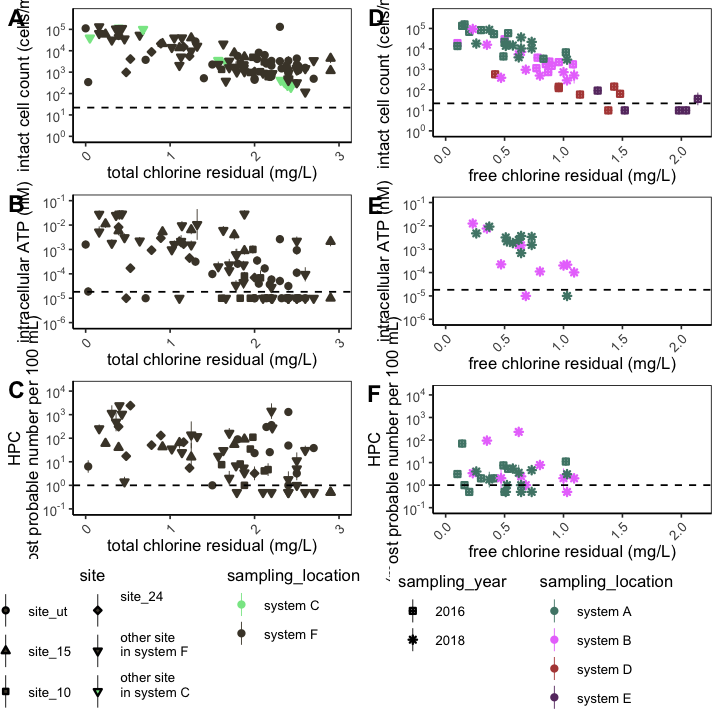

In [86]:
# combine into plot2

#paper
pa<-ggarrange(f2_a,  f2_b,f2_c,
          labels = c("A", "B", "C"),
#            ncol = 1, nrow = 3, legend="none")
          ncol = 1, nrow = 3, common.legend=TRUE, legend= "bottom", align="v")

pb<-ggarrange(f2_d, f2_e, f2_f,
          labels = c("D", "E", "F"),
#         ncol = 1, nrow = 3, legend="none")
          ncol = 1, nrow = 3, common.legend=TRUE, legend= "bottom", align="v")

ggarrange(pa,pb, ncol = 2, nrow = 1)

ggsave(paste(path_fig,"Figure_1.pdf",sep=""),  units='mm',device= cairo_pdf,width=max_w, height=max_h)




## Table S2

##### geometric and arithmetic means for variables in all DWDS

In [87]:
a<-subset(mwq_quant, mwq_quant$wtp=="No")
a<-subset(a, a$disinfectant=="Chlorine")

a<-a[,c("sample_date","sampling_site","sampling_location","total cell count", "intact cell count", "free_Cl2_mg.L", "total_Cl2_mg.L", "pH", "temp_C", "intracellular ATP", "HPC_gmean_MPN_per_100mL", "total ATP")]

colnames(a)<- c("sample_date","location_code","broad_location","B.TCC", "A.ICC", "F.free", "G.total", "H.pH", "I.temp", "C.ATPi", "E.HPC", "D.ATPt")


In [88]:
#summary table output to word
#need to convert to scientific notation by copying and pasting in excel but easy after this

df.sum<- a %>% dplyr::select(B.TCC, A.ICC, F.free, G.total, H.pH, I.temp, C.ATPi, D.ATPt, E.HPC ) %>% 
    dplyr::summarise_each(funs(n=sum(!is.na(.)),min=min(.,na.rm=TRUE),median=median(.,na.rm=TRUE), max=max(.,na.rm=TRUE), mean=mean(.,na.rm=TRUE), sd=sd(.,na.rm=TRUE), gmean=Gmean(.,na.rm=TRUE), gsd=Gsd(.,na.rm=TRUE))) 

df.stats.tidy <- df.sum %>% gather(stat, val, na.rm=TRUE) %>%
    separate(stat, into = c("var", "stat"), sep = "_") %>%
    spread(stat, val) %>%
    dplyr::select(var, n, min, median, max, gmean, gsd, mean, sd)

df.stats.tidy$var<-c("intact cell count (cells/mL)","total cell count (cells/mL)", "intracellular ATP (nM)",  "total ATP (nM)","HPC (MPN/100 mL)","free chlorine (mg/L)", "total chlorine (mg/L)", "pH", "temperature (C)")
colnames(df.stats.tidy)<- c("indicator","n","min","median","max", "geometric mean", "geometric standard deviation","arithmetic mean", "arithmetic standard deviation")

df.stats.tidy$disinfectant='Chlorine'
df.stats.tidy.chl=df.stats.tidy

# stargazer(df.stats.tidy,type="html", summary=FALSE,  out=paste(path_tab,"Table_S2.doc"))

In [89]:
a<-subset(mwq_quant, mwq_quant$wtp=="No")
a<-subset(a, a$disinfectant=="Chloramine")

a<-a[,c("sample_date","sampling_site","sampling_location","total cell count", "intact cell count", "free_Cl2_mg.L", "total_Cl2_mg.L", "pH", "temp_C", "intracellular ATP", "HPC_gmean_MPN_per_100mL", "total ATP")]

colnames(a)<- c("sample_date","location_code","broad_location","B.TCC", "A.ICC", "F.free", "G.total", "H.pH", "I.temp", "C.ATPi", "E.HPC", "D.ATPt")



In [90]:
#summary table output to word
#need to convert to scientific notation by copying and pasting in excel but easy after this

df.sum<- a %>% dplyr::select(B.TCC, A.ICC, F.free, G.total, H.pH, I.temp, C.ATPi, D.ATPt, E.HPC ) %>% 
    dplyr::summarise_each(funs(n=sum(!is.na(.)),min=min(.,na.rm=TRUE),median=median(.,na.rm=TRUE), max=max(.,na.rm=TRUE), mean=mean(.,na.rm=TRUE), sd=sd(.,na.rm=TRUE), gmean=Gmean(.,na.rm=TRUE), gsd=Gsd(.,na.rm=TRUE))) 

df.stats.tidy <- df.sum %>% gather(stat, val, na.rm=TRUE) %>%
    separate(stat, into = c("var", "stat"), sep = "_") %>%
    spread(stat, val) %>%
    dplyr::select(var, n, min, median, max, gmean, gsd, mean, sd)

df.stats.tidy$var<-c("intact cell count (cells/mL)","total cell count (cells/mL)", "intracellular ATP (nM)",  "total ATP (nM)","HPC (MPN/100 mL)","free chlorine (mg/L)", "total chlorine (mg/L)", "pH", "temperature (C)")
colnames(df.stats.tidy)<- c("indicator","n","min","median","max", "geometric mean", "geometric standard deviation","arithmetic mean", "arithmetic standard deviation")

df.stats.tidy$disinfectant='Chloramine'
df.stats.tidy.cam=df.stats.tidy

# stargazer(df.stats.tidy,type="html", summary=FALSE,  out=paste(path_tab,"Table_S2.doc"))

In [91]:
#stack
df.stats.tidy=rbind(df.stats.tidy.cam,df.stats.tidy.chl)
df.stats.tidy=df.stats.tidy[,c("indicator","disinfectant","n","min","median","max","geometric mean", "geometric standard deviation","arithmetic mean", "arithmetic standard deviation")]
df.stats.tidy
stargazer(df.stats.tidy,type="html", summary=FALSE,  out=paste(path_tab,"Table_S2.doc"))

indicator                    disinfectant n   min          median      
1  intact cell count (cells/mL) Chloramine   112 1.183529e+02 2.420524e+03
2  total cell count (cells/mL)  Chloramine   112 3.496986e+02 9.761390e+03
3  intracellular ATP (nM)       Chloramine    94 1.830000e-05 1.045635e-04
4  total ATP (nM)               Chloramine    94 1.852030e-04 1.447990e-03
5  HPC (MPN/100 mL)             Chloramine    67 9.999000e-01 2.471639e+01
6  free chlorine (mg/L)         Chloramine    96 2.000000e-02 5.000000e-02
7  total chlorine (mg/L)        Chloramine   109 2.000000e-02 1.880000e+00
8  pH                           Chloramine    84 7.670000e+00 8.045000e+00
9  temperature (C)              Chloramine    82 1.370000e+01 1.860000e+01
10 intact cell count (cells/mL) Chlorine      54 2.200000e+01 3.531297e+03
11 total cell count (cells/mL)  Chlorine      54 3.169952e+01 7.131288e+03
12 intracellular ATP (nM)       Chlorine      21 1.830000e-05 1.527416e-03
13 total ATP (nM)               Chlorine      21 3.079871e-03 8.249141e-03
14 HPC (MPN/100 mL)             Chlorine      31 9.999000e-01 2.024846e+00
15 free chlorine (mg/L)         Chlorine      54 1.000000e-01 7.300000e-01
16 total chlorine (mg/L)        Chlorine      32 2.400000e-01 7.100000e-01
17 pH                           Chlorine      44 7.400000e+00 8.215000e+00
18 temperature (C)              Chlorine      35 1.570000e+01 2.290000e+01
   max          geometric mean geometric standard deviation arithmetic mean
1  1.525889e+05 3.622185e+03    6.159357                    1.774842e+04   
2  6.225489e+05 1.323047e+04    5.332778                    4.770147e+04   
3  2.851924e-02 2.102746e-04   11.612957                    2.655195e-03   
4  3.116579e-02 1.686672e-03    4.102431                    4.565095e-03   
5  2.419699e+03 2.064089e+01   10.041279                    1.999600e+02   
6  5.400000e-01 5.518927e-02    2.418697                    8.414931e-02   
7  2.900000e+00 1.351862e+00    2.492229                    1.707890e+00   
8  8.450000e+00 8.024885e+00    1.017904                    8.026131e+00   
9  2.880000e+01 1.959481e+01    1.213723                    1.996829e+01   
10 1.577827e+05 2.579431e+03   12.939336                    1.914526e+04   
11 1.584745e+05 4.974886e+03   10.011207                    2.350253e+04   
12 1.261051e-02 9.138329e-04    6.844273                    2.727259e-03   
13 1.541837e-02 7.416968e-03    1.728333                    8.474786e-03   
14 2.298086e+02 3.263910e+00    4.018444                    1.538160e+01   
15 2.140000e+00 6.432283e-01    2.028444                    7.896296e-01   
16 1.220000e+00 6.644208e-01    1.547896                    7.221875e-01   
17 8.740000e+00 8.220875e+00    1.037688                    8.226364e+00   
18 2.610000e+01 2.210280e+01    1.113721                    2.222286e+01   
   arithmetic standard deviation
1  3.360931e+04                 
2  8.747140e+04                 
3  6.411827e-03                 
4  7.315716e-03                 
5  4.921558e+02                 
6  9.509583e-02                 
7  7.815261e-01                 
8  1.420682e-01                 
9  3.984627e+00                 
10 3.437179e+04                 
11 3.697614e+04                 
12 3.381604e-03                 
13 4.229014e-03                 
14 4.458125e+01                 
15 4.723245e-01                 
16 2.763440e-01                 
17 3.034767e-01                 
18 2.263663e+00


<table style="text-align:center"><tr><td colspan="11" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>indicator</td><td>disinfectant</td><td>n</td><td>min</td><td>median</td><td>max</td><td>geometric mean</td><td>geometric standard deviation</td><td>arithmetic mean</td><td>arithmetic standard deviation</td></tr>
<tr><td colspan="11" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>intact cell count (cells/mL)</td><td>Chloramine</td><td>112</td><td>118.353</td><td>2,420.524</td><td>152,588.900</td><td>3,622.185</td><td>6.159</td><td>17,748.420</td><td>33,609.310</td></tr>
<tr><td style="text-align:left">2</td><td>total cell count (cells/mL)</td><td>Chloramine</td><td>112</td><td>349.699</td><td>9,761.390</td><td>622,548.900</td><td>13,230.470</td><td>5.333</td><td>47,701.470</td><td>87,471.400</td></tr>
<tr><td style="text-align:left">3</td><td>intracellular ATP (nM)</td><td>Chloramine</td><td>94</td><t

## Table S4 

##### geometric and arithmetic means for variables in DWDS F

In [92]:
#chloraminated or chlorinated
a<-subset(mwq_quant, mwq_quant$wtp=="No")
a<-subset(a, mwq_quant$disinfectant=="Chloramine")
a<-a[,c("sample_date",lc,bl,"total cell count", "intact cell count", "free_Cl2_mg.L", "total_Cl2_mg.L", "pH", "temp_C", "intracellular ATP", "HPC_gmean_MPN_per_100mL", "total ATP")]
colnames(a)<- c("sample_date","location_code","broad_location","B.TCC", "A.ICC", "F.free", "G.total", "H.pH", "I.temp", "C.ATPi", "E.HPC", "D.ATPt")


In [93]:
#summary table output to word

df.sum<- a %>% dplyr::select(B.TCC, A.ICC, F.free, G.total, H.pH, I.temp, C.ATPi, D.ATPt, E.HPC ) %>% 
    dplyr::summarise_each(funs(n=sum(!is.na(.)),min=min(.,na.rm=TRUE),median=median(.,na.rm=TRUE), max=max(.,na.rm=TRUE), mean=mean(.,na.rm=TRUE), sd=sd(.,na.rm=TRUE), gmean=Gmean(.,na.rm=TRUE), gsd=Gsd(.,na.rm=TRUE))) 

df.stats.tidy <- df.sum %>% gather(stat, val, na.rm=TRUE) %>%
    separate(stat, into = c("var", "stat"), sep = "_") %>%
    spread(stat, val) %>%
    dplyr::select(var, n, min, median, max, gmean, gsd, mean, sd)

df.stats.tidy$var<-c("intact cell count (cells/mL)","total cell count (cells/mL)", "intracellular ATP (nM)",  "total ATP (nM)","HPC (MPN/100 mL)","free chlorine (mg/L)", "total chlorine (mg/L)", "pH", "temperature (C)")
colnames(df.stats.tidy)<- c("indicator","n","min","median","max", "geometric mean", "geometric standard deviation","arithmetic mean", "arithmetic standard deviation")

df.stats.tidy
stargazer(df.stats.tidy,type="html", summary=FALSE,  out=paste(path_tab,"Table_S4.doc"))


indicator                    n   min          median       max         
1 intact cell count (cells/mL) 112 1.183529e+02 2.420524e+03 1.525889e+05
2 total cell count (cells/mL)  112 3.496986e+02 9.761390e+03 6.225489e+05
3 intracellular ATP (nM)        94 1.830000e-05 1.045635e-04 2.851924e-02
4 total ATP (nM)                94 1.852030e-04 1.447990e-03 3.116579e-02
5 HPC (MPN/100 mL)              67 9.999000e-01 2.471639e+01 2.419699e+03
6 free chlorine (mg/L)          96 2.000000e-02 5.000000e-02 5.400000e-01
7 total chlorine (mg/L)        109 2.000000e-02 1.880000e+00 2.900000e+00
8 pH                            84 7.670000e+00 8.045000e+00 8.450000e+00
9 temperature (C)               82 1.370000e+01 1.860000e+01 2.880000e+01
  geometric mean geometric standard deviation arithmetic mean
1 3.622185e+03    6.159357                    1.774842e+04   
2 1.323047e+04    5.332778                    4.770147e+04   
3 2.102746e-04   11.612957                    2.655195e-03   
4 1.686672e-03    4.102431                    4.565095e-03   
5 2.064089e+01   10.041279                    1.999600e+02   
6 5.518927e-02    2.418697                    8.414931e-02   
7 1.351862e+00    2.492229                    1.707890e+00   
8 8.024885e+00    1.017904                    8.026131e+00   
9 1.959481e+01    1.213723                    1.996829e+01   
  arithmetic standard deviation
1 3.360931e+04                 
2 8.747140e+04                 
3 6.411827e-03                 
4 7.315716e-03                 
5 4.921558e+02                 
6 9.509583e-02                 
7 7.815261e-01                 
8 1.420682e-01                 
9 3.984627e+00


<table style="text-align:center"><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>indicator</td><td>n</td><td>min</td><td>median</td><td>max</td><td>geometric mean</td><td>geometric standard deviation</td><td>arithmetic mean</td><td>arithmetic standard deviation</td></tr>
<tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>intact cell count (cells/mL)</td><td>112</td><td>118.353</td><td>2,420.524</td><td>152,588.900</td><td>3,622.185</td><td>6.159</td><td>17,748.420</td><td>33,609.310</td></tr>
<tr><td style="text-align:left">2</td><td>total cell count (cells/mL)</td><td>112</td><td>349.699</td><td>9,761.390</td><td>622,548.900</td><td>13,230.470</td><td>5.333</td><td>47,701.470</td><td>87,471.400</td></tr>
<tr><td style="text-align:left">3</td><td>intracellular ATP (nM)</td><td>94</td><td>0.00002</td><td>0.0001</td><td>0.029</td><td>0.0002</td><td>11.613</td><td>0

## Table 4

##### coefficient of variation

In [94]:
a<-mwq_quant
#rename cols
a<-a[,c("std_note","HPC_label","sample_date",lc,bl,"SG_gstd", "SGPI_gstd", "intra_ATP_gstd_nM","intracellular ATP", "total_ATP_gstd_nM", "intact cell count","total ATP","HPC_gstd_MPN_per_100mL","HPC_gmean_MPN_per_100mL","total cell count")]
colnames(a)<- c("std_note","HPC_label","sample_date","location_code","broad_location","B.TCC", "A.ICC", "C.ATPi","ATPi_m","E.ATPt","ICC_m","ATPt_m","D.HPC","HPC_m","TCC_m")

#subset to remove unquantifiable samps (because have no stdev)
a[(!is.na(a$ATPi_m) & (a$ATPi_m== ATPi_lim)) & (a$C.ATPi==1),"C.ATPi"]<- NA
a[(!is.na(a$ATPt_m) & (a$ATPt_m== ATPt_lim))& (a$E.ATPt==1),"E.ATPt"]<- NA
a[(!is.na(a$ICC_m) & (a$ICC_m== ICC_lim))& (a$A.ICC==1),"A.ICC"]<- NA
a[!is.na(a$HPC_label) & (a$HPC_label=="BDL"),"D.HPC"]<- NA
a[is.na(a$D.HPC)&(!is.na(a$HPC_m))&(is.na(a$HPC_label)),"location_code"] #these 10 samples will be removed because no replicates 

a[(!is.na(a$ATPi_m) & (a$ATPi_m== ATPi_lim)) ,"ATPi_m"]<- NA
a[(!is.na(a$ATPt_m) & (a$ATPt_m== ATPt_lim)),"ATPt_m"]<- NA
a[(!is.na(a$ICC_m) & (a$ICC_m== ICC_lim)),"ICC_m"]<- NA
a[!is.na(a$HPC_label) & (a$HPC_label=="BDL"),"HPC_m"]<- NA

#fin
length(!is.na(a$D.HPC))
a[(!is.na(a$std_note)&(a$std_note== 'exclude')),"D.HPC"]<-NA
length(!is.na(a$D.HPC))
a<-dplyr::select(a,-std_note)
a<-a[,c("sample_date","location_code","broad_location","B.TCC", "A.ICC", "C.ATPi", "D.HPC", "E.ATPt")]
a[,c("B.TCC", "A.ICC", "C.ATPi", "D.HPC", "E.ATPt")]<- a[,c("B.TCC", "A.ICC", "C.ATPi", "D.HPC", "E.ATPt")] -1
colnames(a)<-c("sample_date","location_code","broad_location","B.TCC", "A.ICC", "C.ATPi", "E.HPC", "D.ATPt")
subset(a, a$A.ICC==0)
subset(a, a$C.ATPi==0)
subset(a, a$E.ATPt==0)
subset(a, a$D.HPC==0) 

factor(0)
69 Levels: site_1 site_10 site_11 site_12 site_13 site_14 site_15 ... site_ut

[1] 168

[1] 168

sample_date location_code broad_location B.TCC A.ICC C.ATPi E.HPC D.ATPt

sample_date location_code broad_location B.TCC A.ICC C.ATPi E.HPC D.ATPt

sample_date location_code broad_location B.TCC A.ICC C.ATPi E.HPC D.ATPt

sample_date location_code broad_location B.TCC A.ICC C.ATPi E.HPC D.ATPt

### table

In [95]:
# consistency calculations-- similar to intra assay CV- average coefficient of variation between replicates

df.sum<- a %>% dplyr::select(B.TCC, A.ICC, D.ATPt, C.ATPi, E.HPC) %>% 
    dplyr::summarise_each(funs(n=sum(!is.na(.)),min=min(.,na.rm=TRUE),median=median(.,na.rm=TRUE), max=max(.,na.rm=TRUE),mean=mean(.,na.rm=TRUE))) 
df.stats.tidy <- df.sum %>% gather(stat, val, na.rm=TRUE) %>%
    separate(stat, into = c("var", "stat"), sep = "_") %>%
    spread(stat, val) %>%
    dplyr::select(var, n, min, median, max, mean)

df.stats.tidy$var<-c("intact cell count","total cell count", "intracellular ATP",  "total ATP", "HPC")
colnames(df.stats.tidy)<- c("indicator","n","min","median","max", "intra-assay coefficient of variation" )

#report as percentages
df.stats.tidy[,c("min","median","max", "intra-assay coefficient of variation" )]<- df.stats.tidy[,c("min","median","max", "intra-assay coefficient of variation") ]*100



df.stats.tidy
stargazer(df.stats.tidy,type="html", summary=FALSE,  out=paste(path_tab,"Table_4.doc"))



indicator         n   min        median    max     
1 intact cell count 162  0.0266000  9.778128 148.1027
2 total cell count  166  0.3179580  6.154096 255.6794
3 intracellular ATP  80 42.9840566 48.630348 327.9336
4 total ATP         115  0.3885756  4.810641  65.9587
5 HPC                73  0.0000000 27.131735 293.2202
  intra-assay coefficient of variation
1 16.936797                           
2 16.953986                           
3 55.994417                           
4  9.307352                           
5 49.390096


<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td>indicator</td><td>n</td><td>min</td><td>median</td><td>max</td><td>intra-assay coefficient of variation</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">1</td><td>intact cell count</td><td>162</td><td>0.027</td><td>9.778</td><td>148.103</td><td>16.937</td></tr>
<tr><td style="text-align:left">2</td><td>total cell count</td><td>166</td><td>0.318</td><td>6.154</td><td>255.679</td><td>16.954</td></tr>
<tr><td style="text-align:left">3</td><td>intracellular ATP</td><td>80</td><td>42.984</td><td>48.630</td><td>327.934</td><td>55.994</td></tr>
<tr><td style="text-align:left">4</td><td>total ATP</td><td>115</td><td>0.389</td><td>4.811</td><td>65.959</td><td>9.307</td></tr>
<tr><td style="text-align:left">5</td><td>HPC</td><td>73</td><td>0</td><td>27.132</td><td>293.220</td><td>49.390</td></

## Figure S4

##### decay in total chlorine with water age in DWDS F by date

In [96]:
#plot 2 sizes
w2=6
h2=6 
theme_set(theme_classic(base_size=10, base_family="Arial"))#, base_line_size= 1))
p=2.5

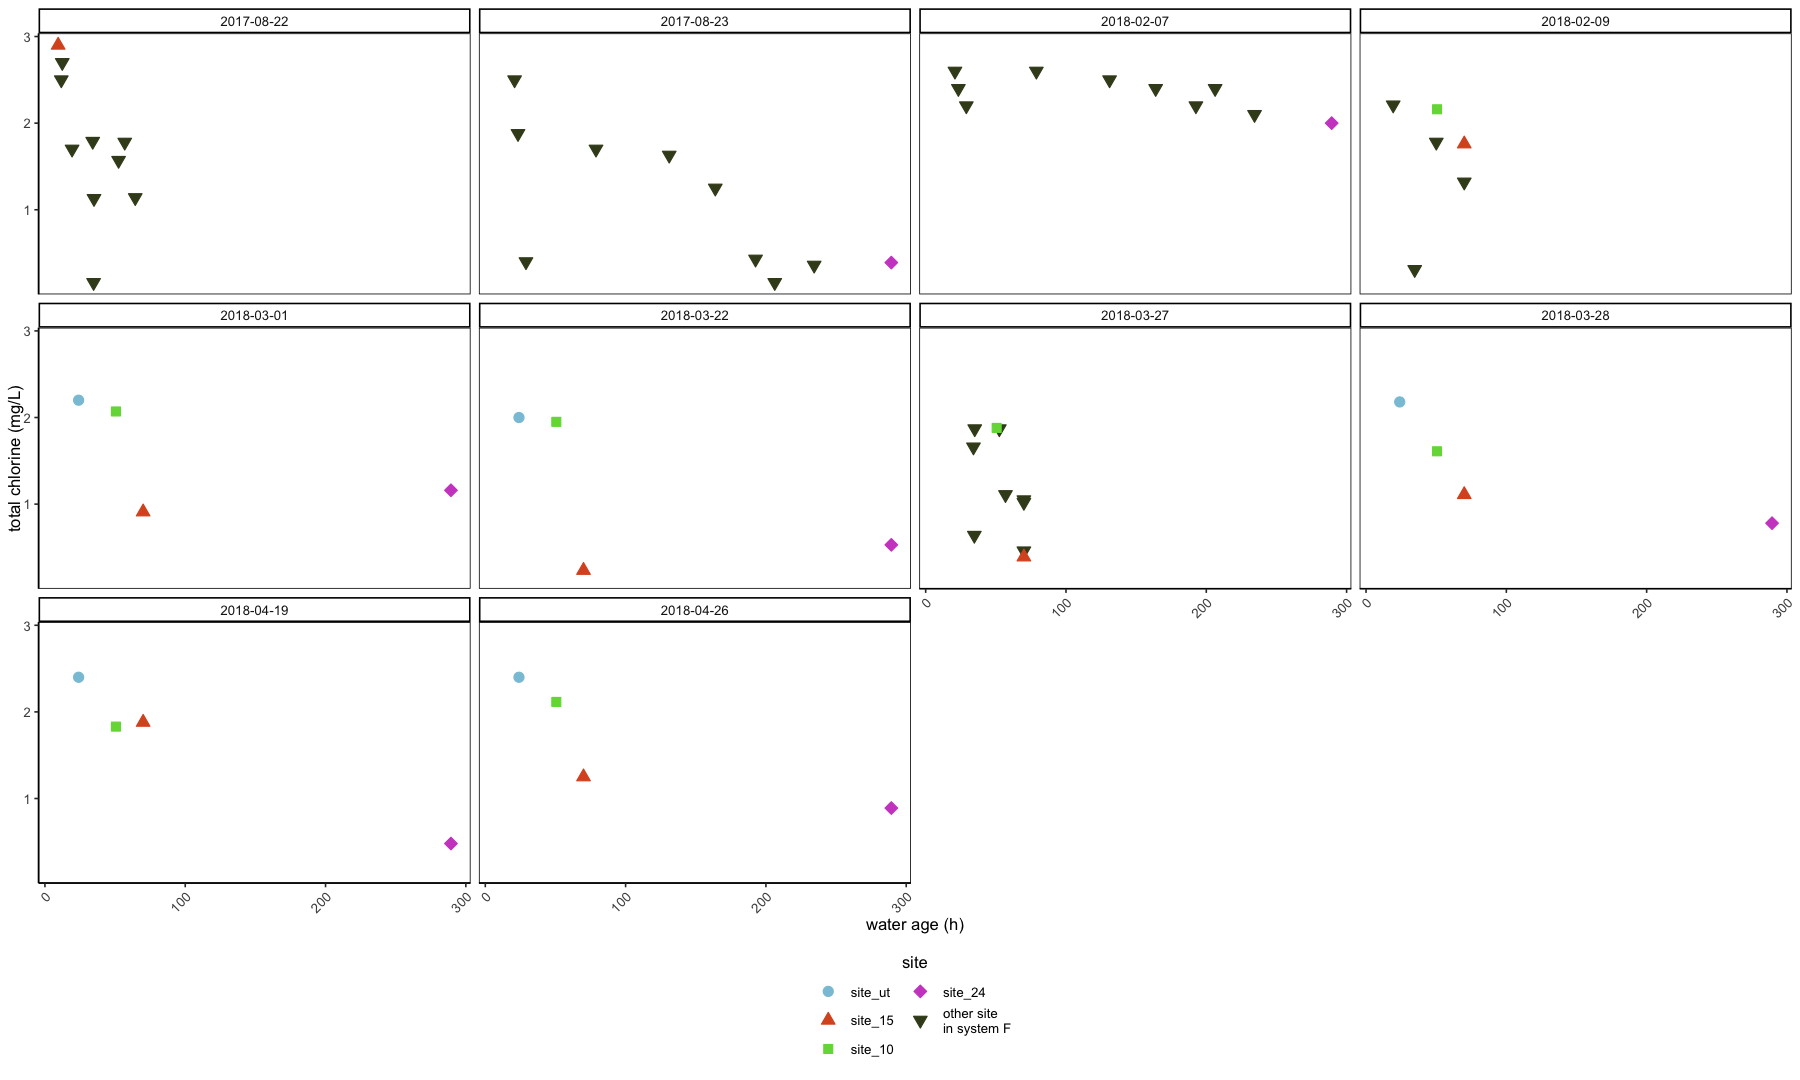

In [97]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")
a$sample_date<- as.factor(a$sample_date)
dates<- a %>%
  count(sample_date)%>%
    subset(n > 2)
dates<-dates$sample_date
a=subset(a, a$sample_date %in% dates)
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))
f<-a[a[[bl]]==D_F,]
options(repr.plot.width = w2*2.5, repr.plot.height = h2*1.5) #for plotting size in jupyter

ggplot(f, aes_string(x="water_age_h", y="total_Cl2_mg.L", color="site", shape="site", fill="site"))+
    geom_point(size=p)+
     scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= colors)+
    scale_color_manual(values= colors)+
    ylab("total chlorine (mg/L)")+
    xlab("water age (h)")+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom")+facet_wrap(~sample_date)

ggsave(paste(path_fig,"Figure_S4.pdf",sep=""),  units='mm',device= cairo_pdf,width=max_w, height=max_h/1.5)

## Figure 4 

##### decay in total chlorine with water age in DWDS F

In [98]:
w2=6
h2=4 
p=0.3

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=12, base_family="Arial"))#, base_line_size= 1))

In [99]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")

a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))
f<-a[a[[bl]]==D_F,]

wa1<-ggplot(f, aes_string(x="water_age_h", y="avg_cells_per_mL_gmean", color="site", shape="site", fill="site"))+ #site
    geom_pointrange(aes(min=avg_cells_per_mL_gmean/avg_cells_per_mL_gstd, 
                    ymax=avg_cells_per_mL_gmean *avg_cells_per_mL_gstd ), size=p)+
    ICC_d+
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= colors)+
    scale_color_manual(values= colors)+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x)), limits=c(1,1000000)) +
    ylab("intact cell count\n(cells/mL)")+
    xlab("water age (h)")+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 


In [100]:
a=ATP_long
a=subset(a, a$disinfectant=="Chloramine")
a<-a[a[[atp]]==ATPi_l,]
a=subset(a, a$wtp=="No")

a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))

wa2<- ggplot(a, aes_string(x="water_age_h", y="value", color="site", shape="site", fill="site"))+ #site
    geom_pointrange(aes(ymin=value/ATP_stdev, 
                    ymax=value*ATP_stdev),size=p)+ 
    ATPi_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)), limits=c(0.000001,0.1)) +
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= colors)+
    scale_color_manual(values= colors)+
    ylab("intracellular ATP\n(nM)")+
    xlab("water age (h)")+
              guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 
                  
 

In [101]:
a=SG_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")

a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))
f<-a[a[[bl]]==D_F,]

wa3<-ggplot(a, aes_string(x="water_age_h", y="HPC_gmean_MPN_per_100mL", color="site", shape="site", fill="site"))+ #site
    geom_pointrange(aes(ymin=HPC_gmean_MPN_per_100mL/HPC_gstd_MPN_per_100mL, 
                    ymax=HPC_gmean_MPN_per_100mL*HPC_gstd_MPN_per_100mL),size=p)+
    HPC_d+
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= colors)+
    scale_color_manual(values= colors)+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x)), limits=c(0.1,15000)) +
ylab("HPC\n(most probable number\nper 100 mL)")+
 xlab("water age (h)")+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 



In [102]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")
a$sample_date<- as.factor(a$sample_date)

a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))
f<-a[a[[bl]]==D_F,]

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter


wa4<-ggplot(f, aes_string(x="water_age_h", y="total_Cl2_mg.L", color="site", shape="site", fill="site"))+#site
    geom_point(size=2)+
     scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= colors)+
    scale_color_manual(values= colors)+
    ylab("total chlorine\n(mg/L)")+
    xlab("water age (h)")+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=2),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="right") 



### plot

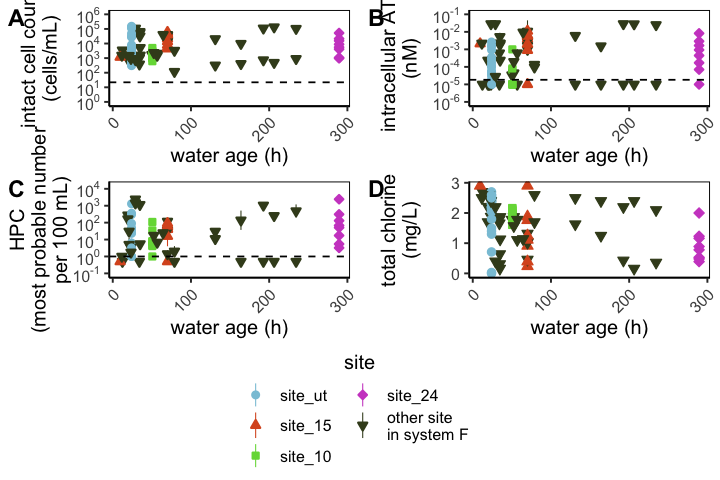

In [103]:
ggarrange(wa1, wa2, wa3,wa4,
          labels = c("A", "B","C","D"),
          ncol = 2, nrow = 2, common.legend=TRUE, legend="bottom" , align="v")

ggsave(paste(path_fig,"Figure_4.pdf",sep=""), device= cairo_pdf, units='mm', width=max_w, height=(max_h/1.5))



## Figure S2

###### ICC/TCC by disinfectant in all DWDSs

In [104]:
w2=10
h2=4
p=1.5

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=8, base_family="Arial"))#, base_line_size= 1))

In [105]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))
#plot
g2_a<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="ICC_to_TCC", color= blp,shape="site", fill="site"))+
    geom_point(size=p, stroke=p/2)+
    scale_shape_manual(values= c(21,24,22,23,25,25))+
    scale_fill_manual(values= c(grey_s[1],grey_s[1],grey_s[1],grey_s[1],grey_s[1],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
   ylab("   fraction of potentially viable cells")+
    total_x+
    scale_x_continuous(limits=c(0,3))+
     scale_y_continuous(limits=c(0,1.2))+
     guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 


In [106]:
a=SGPI_all
a=subset(a, a$disinfectant=="Chlorine")
a=subset(a, a$wtp=="No")
options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
a$site<-factor(a$site, levels=c("site_ut","site_15", "site_10","site_24","other site\nin system F","other site\nin system C"))

g2_b<-ggplot(a, aes_string(x="free_Cl2_mg.L", y="ICC_to_TCC", color= blp, shape="sampling_year"))+
    geom_point(size=p,stroke=p/2)+
    scale_shape_manual(values= c(12,8))+
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
   ylab("   fraction of potentially viable cells")+
    free_x+
    scale_x_continuous(limits=c(0,2.15))+
scale_y_continuous(limits=c(0,1.2))+
          guides(shape=guide_legend(title.position="top",title.hjust=0.25,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
    

### plot

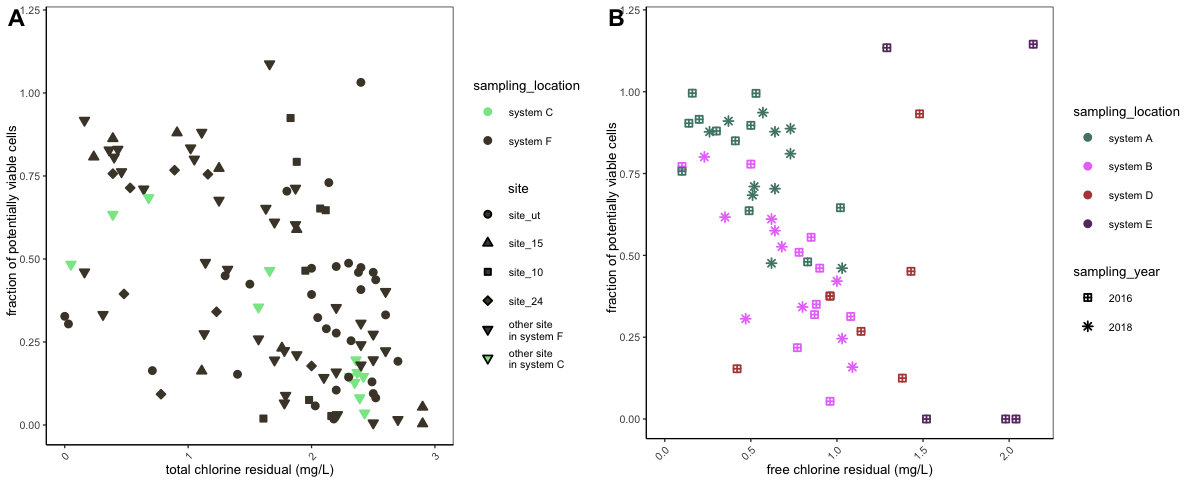

In [107]:
ggarrange(g2_a,  g2_b,
          labels = c("A", "B"),
          ncol = 2, nrow = 1,  common.legend=FALSE, legend= "right", align="v")
ggsave(paste(path_fig,"Figure_S2.pdf",sep=""), device= cairo_pdf, units='mm', width=max_w, height=max_h/4)




## Figure S1 

##### ICC & TCC compared to ATPi & ATPt in all DWDSs by disinfectant concentration

In [108]:
w2=6
h2=4 
p=0.25

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=10, base_family="Arial"))#, base_line_size= 1))

In [109]:

a=SG_all
a=subset(a, a$disinfectant=="Chloramine")
a=subset(a, a$wtp=="No")


#plot
s2a<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="avg_cells_per_mL_gmean", color=blp))+
      geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/avg_cells_per_mL_gstd, 
                    ymax=avg_cells_per_mL_gmean *avg_cells_per_mL_gstd),size=p)+
    TCC_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)),limits=c(1,500000)) +
    scale_fill_manual(values= c(grey_s[3],grey_s[4],grey_s[5],grey_s[6],grey_s[2],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
    TCC_y +
    total_x+
    scale_x_continuous(limits=c(0,3))+
     guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
        
        

In [110]:
a=SG_all
a=subset(a, a$disinfectant=="Chlorine")
a=subset(a, a$wtp=="No")


s2b<-ggplot(a, aes_string(x="free_Cl2_mg.L", y="avg_cells_per_mL_gmean", color=blp))+
geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/avg_cells_per_mL_gstd, 
                    ymax=avg_cells_per_mL_gmean *avg_cells_per_mL_gstd,),size=p)+
    TCC_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)),limits=c(1,500000)) +
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
    TCC_y +
    free_x+
    scale_x_continuous(limits=c(0,1.6))+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=1),color=guide_legend(title.position="top",ncol=2))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
        
        
    

In [111]:
a=ATP_long
a=subset(a, a$disinfectant=="Chloramine")
a<- a[(a[[atp]]!= "extra_ATP_gmean_nM"),]
a<- a[(a[[atp]]== "total ATP"),]
a=subset(a, a$wtp=="No")
a[[atp]]<-factor(a[[atp]], levels=(c(ATPt_l, ATPi_l)))


s2c<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="value", color= blp))+
    geom_pointrange(aes(ymin=value/ATP_stdev, 
                    ymax=value*ATP_stdev),size=p)+
    ATPt_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)), limits=c(0.00001,0.1)) +
    scale_fill_manual(values= c(grey_s[3],grey_s[4],grey_s[5],grey_s[6],grey_s[2],green_s[2]))+
    scale_color_manual(values= c(green_s[2],grey_s[1]))+
    ATPt_y+ 
    total_x+
    scale_x_continuous(limits=c(0,3))+
             guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=1),color=guide_legend(title.position="top",ncol=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
                               

In [112]:
a=ATP_long
a=subset(a, a$disinfectant=="Chlorine")
a<- a[(a[[atp]]!= "extra_ATP_gmean_nM"),]
a<- a[(a[[atp]]== "total ATP"),]
a=subset(a, a$wtp=="No")
a[[atp]]<-factor(a[[atp]], levels=(c(ATPt_l, ATPi_l)))


s2d<-ggplot(a, aes_string(x="total_Cl2_mg.L", y="value", color= blp))+
    geom_pointrange(aes(ymin=value/ATP_stdev, 
                    ymax=value*ATP_stdev),size=p)+
    ATPt_d+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)), limits=c(0.00001,0.1)) +
    scale_color_manual(values= c(blue_s[3],pink_s[1],brown_s[2],pink_s[3]))+
    ATPt_y +
    free_x+
    scale_x_continuous(limits=c(0,1.6))+
          guides(shape=guide_legend(title.position="top",title.hjust=0.5,ncol=1),color=guide_legend(title.position="top",ncol=2))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),plot.caption = element_text(hjust = 0.5),legend.position="bottom") 
                       

### plot

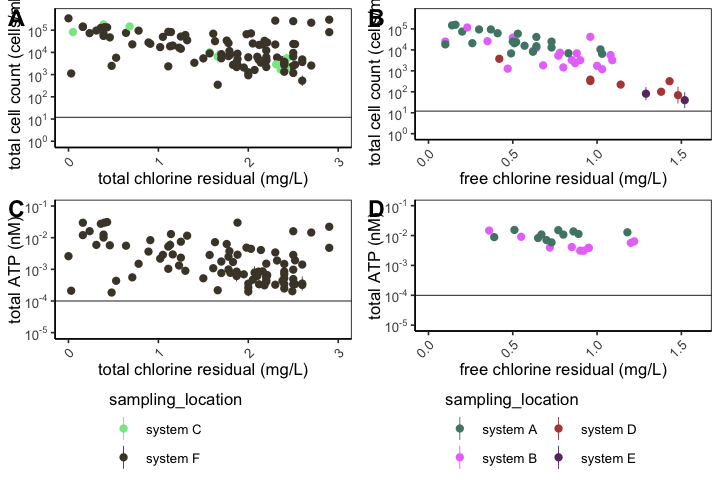

In [113]:
# combine into plot2

pa<-ggarrange(s2a,  s2c,
          labels = c("A", "C"),
          ncol = 1, nrow = 2,  common.legend=TRUE, legend= "bottom", align="v")

pb<-ggarrange(s2b,s2d,
          labels = c("B","D"),
          ncol = 1, nrow = 2, common.legend=TRUE, legend= "bottom", align="v")

ggarrange(pa,pb, ncol = 2, nrow = 1)

ggsave(paste(path_fig,"Figure_S1.pdf",sep=""), device= cairo_pdf, units='mm', width=max_w, height=(max_h/1.5))


## Figure 2

##### Spearman's correlation plots

In [114]:
#order for figure
nam<-c("intact cell count", "total cell count", "intracellular ATP", "total ATP", "HPC", "pH", "temperature", "free chlorine", "total chlorine") 

wg<-8
hg<-8
s=2.5
options(repr.plot.width = wg, repr.plot.height = hg) #for plotting size in jupyter
theme_set(theme_classic(base_size=7, base_family="Arial"))#, base_line_size= 1))

In [115]:
# Get upper triangle of the correlation matrix
#order for figure

  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    diag(cormat)=NA
    return(cormat)
  }

  get_lower_tri <- function(cormat){
    cormat[upper.tri(cormat)]<- NA
    diag(cormat)=NA
    cormat<-rotate(cormat)
    return(cormat)
  }

rotate <- function(x) t(apply(x, 2, rev))

 reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd)
cormat <-cormat[hc$order, hc$order]
}


 reorder_cormat_mini <- function(cormat){
# Use correlation between variables as distance
cormat <-cormat[nam,nam]

}

 reorder_cormat_mini2 <- function(cormat){
   cormat <-cormat[nam,nam]
# Use correlation between variables as distance
# cormat <-cormat[order(rownames(cormat)),order(colnames(cormat))]
}




In [116]:
cols=c("HPC_gmean_MPN_per_100mL","total cell count","intact cell count", "total ATP", "intracellular ATP", "pH", "temp_C", "total_Cl2_mg.L","free_Cl2_mg.L")

#chloraminated
test<-mwq_quant
test<-subset(test, test$wtp=="No")
test<-subset(test, test$disinfectant=="Chloramine")
test<-test[,which(!sapply(test,is.character))]
test<-test[,cols]
names(test)[names(test)=="HPC_gmean_MPN_per_100mL"] <- "HPC"
names(test)[names(test)=="temp_C"] <- "temperature"
names(test)[names(test)=="total_Cl2_mg.L"] <- "total chlorine"
names(test)[names(test)=="free_Cl2_mg.L"] <- "free chlorine"
test<- test[which(complete.cases(test)),]
#log transform
test[,c("HPC","total cell count","intact cell count", "total ATP", "intracellular ATP") ] <- log10(test[,c("HPC","total cell count","intact cell count", "total ATP", "intracellular ATP") ])

cor<-rcorr(as.matrix(test), type="spearman")
head(cor$r)
#reorder matrices
cor_or<-reorder_cormat_mini(cor$r)
corP_or<-cor$P[rownames(cor_or),] 
corP_or<-corP_or[,colnames(cor_or)]
upper_tri_r<-get_upper_tri(cor_or)
upper_tri_P<-get_upper_tri(corP_or)

 diag(cor_or)<- NA
melted_r<-melt(upper_tri_r,na.rm=TRUE)
melted_P<-melt(upper_tri_P,na.rm=TRUE)
melted_P$stars <- ifelse(melted_P$value < 0.0001, "\n***", 
                  ifelse(melted_P$value  < 0.001, "\n**", 
                         ifelse(melted_P$value  < 0.01, "\n*", "")))
unique(melted_r[,1:2]==melted_P[,1:2]) #double check
stars<-melted_P$stars
pvalue<-melted_P$value
melted=cbind(melted_r,stars)
melted=cbind(melted,pvalue)
melted$fill<- paste(round(melted$value,2),melted$stars, sep=" ")
melted_mini<- melted

melted_mini[melted_mini$pvalue>0.01,"value" ]<-NA

melted_mini$text<-0
melted_mini[!is.na(melted_mini$value)&(melted_mini$value>0),"text"]<-1
melted_mini$text<- as.factor(melted_mini$text)

HPC        total cell count intact cell count total ATP 
HPC                1.0000000 0.24291574        0.5291601        0.26325930
total cell count   0.2429157 1.00000000        0.6965098        0.77859305
intact cell count  0.5291601 0.69650978        1.0000000        0.75799521
total ATP          0.2632593 0.77859305        0.7579952        1.00000000
intracellular ATP  0.3669691 0.62131649        0.7559113        0.78523641
pH                -0.2227906 0.07272199       -0.1325609        0.01834608
                  intracellular ATP pH          temperature total chlorine
HPC                0.3669691        -0.22279059  0.06699522 -0.4527885    
total cell count   0.6213165         0.07272199  0.51487664 -0.3570229    
intact cell count  0.7559113        -0.13256089  0.44013648 -0.6733067    
total ATP          0.7852364         0.01834608  0.61855835 -0.4035873    
intracellular ATP  1.0000000        -0.20189676  0.47651168 -0.6487009    
pH                -0.2018968         1.00000000 -0.10987630  0.3913797    
                  free chlorine
HPC               -0.07821950  
total cell count   0.13150334  
intact cell count  0.05096333  
total ATP          0.19401965  
intracellular ATP -0.02797829  
pH                 0.46188897

Var1 Var2
10 TRUE TRUE

In [117]:
grey1<-ggplot(data = melted_mini, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_viridis(name="spearman\ncorrelation",limit = c(-1,1),option="inferno",na.value="#999999")+ 
    geom_text(aes(Var2, Var1, label = fill, color=text), size = s) +
    ylab("")+
    xlab("")+
    scale_color_manual(values= c("white","black"))+
    guides(color=FALSE)+
 coord_fixed()+theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
axis.text.x = element_text(angle = 45, hjust = 1),legend.position="left")


In [118]:
#chlorinated
test<-mwq_quant
test<-subset(test, test$wtp=="No")
test<-subset(test, test$disinfectant=="Chlorine")
test<-test[,which(!sapply(test,is.character))]
test<-test[,cols]
names(test)[names(test)=="HPC_gmean_MPN_per_100mL"] <- "HPC"
names(test)[names(test)=="temp_C"] <- "temperature"
names(test)[names(test)=="total_Cl2_mg.L"] <- "total chlorine"
names(test)[names(test)=="free_Cl2_mg.L"] <- "free chlorine"
test<- test[which(complete.cases(test)),]
test<-test[,nam]
#log transform
# test[,c("HPC","total cell count","intact cell count", "total ATP", "intracellular ATP") ] <- log10(test[,c("HPC","total cell count","intact cell count", "total ATP", "intracellular ATP") ])
cor<-rcorr(as.matrix(test), type="spearman")

#reorder matrices
cor_or<-reorder_cormat_mini2(cor$r)
corP_or<-cor$P[rownames(cor_or),] 
corP_or<-corP_or[,colnames(cor_or)]

upper_tri_r<-get_lower_tri(cor_or)
upper_tri_P<-get_lower_tri(corP_or)

melted_r<-melt(upper_tri_r,na.rm=TRUE)
melted_P<-melt(upper_tri_P,na.rm=TRUE)
melted_P$stars <- ifelse(melted_P$value < 0.0001, "\n***", 
                  ifelse(melted_P$value  < 0.001, "\n**", 
                         ifelse(melted_P$value  < 0.01, "\n*", "")))
unique(melted_r[,1:2]==melted_P[,1:2]) #double check
stars<-melted_P$stars
pvalue<-melted_P$value
melted=cbind(melted_r,stars)
melted=cbind(melted,pvalue)
melted$fill<- paste(round(melted$value,2),melted$stars, sep=" ")
melted_mini<- melted
melted_mini[melted_mini$pvalue>0.01,"value" ]<-NA
melted_mini$text<-0
melted_mini[!is.na(melted_mini$value)&(melted_mini$value>0),"text"]<-1
melted_mini$text<- as.factor(melted_mini$text)

Var1 Var2
1 TRUE TRUE

In [119]:
grey2<-ggplot(data = melted_mini, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_y_discrete(position="right")+
 scale_fill_viridis(name="spearman\ncorrelation",limit = c(-1,1),option="inferno",na.value="#999999")+ 
    geom_text(aes(Var2, Var1, label = fill, color=text), size = s) +
    ylab("")+
    xlab("")+
    scale_color_manual(values= c("white","black"))+
    guides(color=FALSE)+
 coord_fixed()+theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
axis.text.x = element_text(angle = 45, hjust = 1),legend.position="right")



### plot

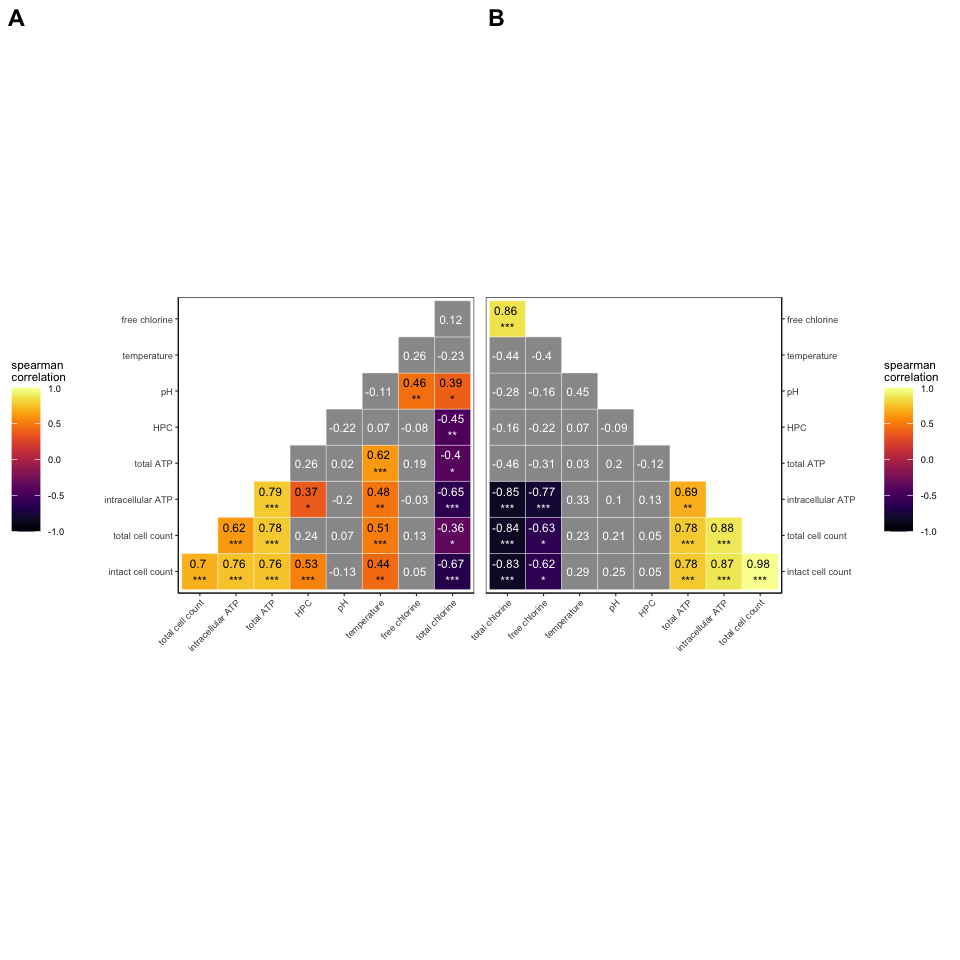

In [120]:

ggarrange(grey1,grey2,
          labels = c("A", "B"),
           ncol = 2, nrow = 1)

ggsave(paste(path_fig,"Figure_2.pdf", sep=""), device= cairo_pdf,units='mm', width=max_w, height=max_h/2.5)

## Figure S5

###### total chlorine at sites in DWDS F over time

In [121]:
w2=6
h2=4 

options(repr.plot.width = w2, repr.plot.height = h2) #for plotting size in jupyter
theme_set(theme_classic(base_size=10, base_family="Arial"))#, base_line_size= 1))

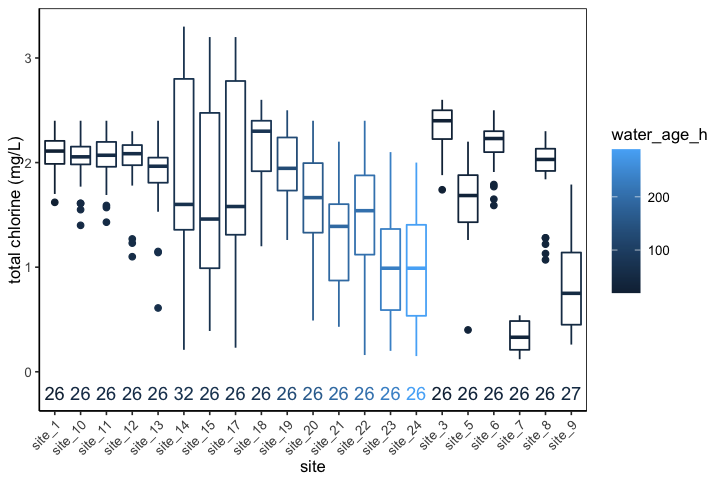

In [122]:
a=DWDS_F_dat
a$location_code<-as.factor(a$site)
a$location_code<-with(a, reorder(x = site , X= total_Cl2_mg.L, FUN = function(m) sd(m, na.rm = TRUE)))
                
ggplot(a, aes(x=site, y=total_Cl2_mg.L, color= water_age_h))+
geom_boxplot()+
    stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))  +
   ylab("total chlorine (mg/L)")+
   xlab("site")+
        theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1),legend.position="right")

ggsave(paste(path_fig,"Figure_S5.pdf",sep=""), device= cairo_pdf, units='mm', width=max_w, height=(max_h/2.5))